<a href="https://colab.research.google.com/github/alim98/MPI/blob/main/MPI_VITANDVGG_enhanced_2d_representation_added.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Essential downloads

In [ ]:
!wget -O downloaded_file.zip "https://drive.usercontent.google.com/download?id=1iHPBdBOPEagvPTHZmrN__LD49emXwReY&export=download&authuser=0&confirm=t&uuid=631d60dd-569c-4bb1-a9e8-d681f0ed3d43&at=APvzH3r4me8x_LwP3n8O7lgPo8oK%3A1733988188000"

!unzip downloaded_file.zip

In [ ]:

!pip install transformers scikit-learn matplotlib seaborn torch torchvision umap-learn git+https://github.com/funkelab/funlib.learn.torch.git
!pip install openpyxl


In [ ]:

import os
import glob
import imageio.v2 as iio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
from torch.utils.data import Dataset, DataLoader
from transformers import ViTImageProcessor, ViTModel
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from umap import UMAP
import torch.nn.functional as F
from funlib.learn.torch.models import Vgg3D

# 2

Total synapses loaded from all bboxes: 220
Combined Dataset and DataLoader initialized.
VGG3D checkpoint already exists.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-1-b3e9154816dd>:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary 

VGG3D model loaded and in eval mode.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ViT model loaded and in eval mode.
Processed 10 batches.
Extracted combined features for 220 synapses.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

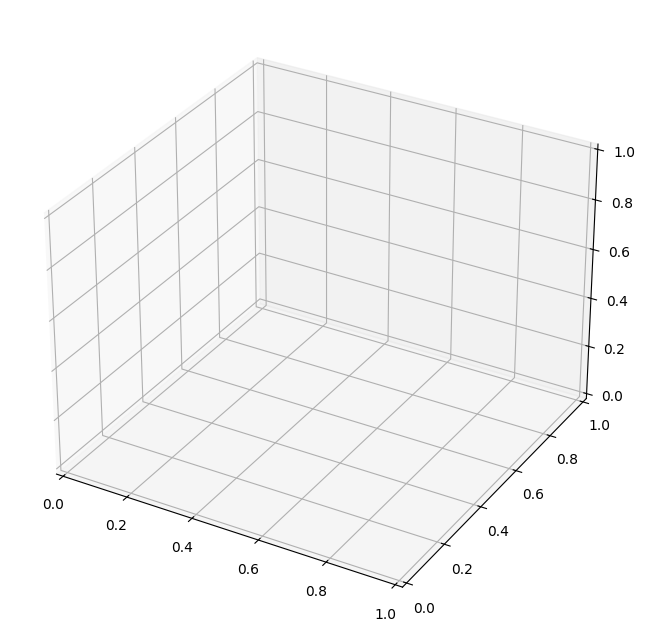

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from transformers import ViTImageProcessor, ViTModel
from funlib.learn.torch.models import Vgg3D
import seaborn as sns
import umap
from PIL import Image
import imageio.v2 as iio
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import torch.nn.functional as F


raw_base_dir = '/content/raw'
seg_base_dir = '/content/seg'
bbox_names = [f'bbox{i}' for i in range(1,4)]  # bbox1 to bbox4 because in google colab im running out of RAM

def load_bbox_data(bbox_name, max_slices=None):
    raw_dir = os.path.join(raw_base_dir, bbox_name)
    seg_dir = os.path.join(seg_base_dir, bbox_name)

    raw_tif_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
    seg_tif_files = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))

    if max_slices is not None:
        raw_tif_files = raw_tif_files[:max_slices]
        seg_tif_files = seg_tif_files[:max_slices]

    assert len(raw_tif_files) == len(seg_tif_files), f"Raw/Seg mismatch in {bbox_name}"

    raw_slices = [iio.imread(f) for f in raw_tif_files]
    seg_slices = [iio.imread(f).astype(np.uint32) for f in seg_tif_files]

    raw_vol = np.stack(raw_slices, axis=0)  # (Z, Y, X)
    seg_vol = np.stack(seg_slices, axis=0)  # (Z, Y, X)
    return raw_vol, seg_vol

def create_segment_masks(seg_vol, side1_coord, side2_coord):
    x1, y1, z1 = [int(c) for c in side1_coord]
    x2, y2, z2 = [int(c) for c in side2_coord]

    seg_id_1 = seg_vol[z1, y1, x1]
    seg_id_2 = seg_vol[z2, y2, x2]

    mask_1 = (seg_vol == seg_id_1) if seg_id_1 != 0 else np.zeros_like(seg_vol, dtype=bool)
    mask_2 = (seg_vol == seg_id_2) if seg_id_2 != 0 else np.zeros_like(seg_vol, dtype=bool)
    return mask_1, mask_2

class SynapseDataset(Dataset):
    def __init__(self, vol_data_list, combined_synapse_df, subvol_size=80):
        self.vol_data_list = vol_data_list
        self.synapse_df = combined_synapse_df.reset_index(drop=True)
        self.subvol_size = subvol_size
        self.half_size = subvol_size // 2

    def __len__(self):
        return len(self.synapse_df)

    def __getitem__(self, idx):
        syn_info = self.synapse_df.iloc[idx]
        bbox_index = syn_info['bbox_index']
        raw_vol, seg_vol = self.vol_data_list[bbox_index]

        central_coord = (
            int(syn_info['central_coord_1']),
            int(syn_info['central_coord_2']),
            int(syn_info['central_coord_3'])
        )
        side1_coord = (
            int(syn_info['side_1_coord_1']),
            int(syn_info['side_1_coord_2']),
            int(syn_info['side_1_coord_3'])
        )
        side2_coord = (
            int(syn_info['side_2_coord_1']),
            int(syn_info['side_2_coord_2']),
            int(syn_info['side_2_coord_3'])
        )

        mask_1_full, mask_2_full = create_segment_masks(seg_vol, side1_coord, side2_coord)

        cx, cy, cz = central_coord
        x_start = max(cx - self.half_size, 0)
        x_end = min(cx + self.half_size, raw_vol.shape[2])
        y_start = max(cy - self.half_size, 0)
        y_end = min(cy + self.half_size, raw_vol.shape[1])
        z_start = max(cz - self.half_size, 0)
        z_end = min(cz + self.half_size, raw_vol.shape[0])

        sub_raw = raw_vol[z_start:z_end, y_start:y_end, x_start:x_end]
        sub_mask_1 = mask_1_full[z_start:z_end, y_start:y_end, x_start:x_end]
        sub_mask_2 = mask_2_full[z_start:z_end, y_start:y_end, x_start:x_end]

        desired_shape = (self.subvol_size, self.subvol_size, self.subvol_size)
        padded_sub_raw = np.zeros(desired_shape, dtype=sub_raw.dtype)
        padded_sub_mask_1 = np.zeros(desired_shape, dtype=bool)
        padded_sub_mask_2 = np.zeros(desired_shape, dtype=bool)

        dz, dy, dx = sub_raw.shape
        padded_sub_raw[:dz, :dy, :dx] = sub_raw
        padded_sub_mask_1[:dz, :dy, :dx] = sub_mask_1
        padded_sub_mask_2[:dz, :dy, :dx] = sub_mask_2

        axial_slice = padded_sub_raw[self.half_size, :, :]     # XY
        coronal_slice = padded_sub_raw[:, self.half_size, :]   # XZ
        sagittal_slice = padded_sub_raw[:, :, self.half_size]  # YZ

        sub_raw_tensor = torch.from_numpy(padded_sub_raw).unsqueeze(0).float()
        axial_slice_tensor = torch.from_numpy(axial_slice).unsqueeze(0).float()
        coronal_slice_tensor = torch.from_numpy(coronal_slice).unsqueeze(0).float()
        sagittal_slice_tensor = torch.from_numpy(sagittal_slice).unsqueeze(0).float()

        return sub_raw_tensor, [axial_slice_tensor, coronal_slice_tensor, sagittal_slice_tensor]

vol_data_list = []
combined_synapse_df_list = []
for i, bbox_name in enumerate(bbox_names):
    raw_vol, seg_vol = load_bbox_data(bbox_name)
    vol_data_list.append((raw_vol, seg_vol))
    excel_file = f'{bbox_name}.xlsx'
    syn_df = pd.read_excel(excel_file)
    syn_df['bbox_index'] = i
    syn_df['bbox_name'] = bbox_name
    combined_synapse_df_list.append(syn_df)

combined_synapse_df = pd.concat(combined_synapse_df_list, ignore_index=True)
required_columns = [
    'central_coord_1', 'central_coord_2', 'central_coord_3',
    'side_1_coord_1', 'side_1_coord_2', 'side_1_coord_3',
    'side_2_coord_1', 'side_2_coord_2', 'side_2_coord_3'
]
missing_columns = [col for col in required_columns if col not in combined_synapse_df.columns]
if missing_columns:
    raise KeyError(f"Missing required columns: {missing_columns}")

print(f"Total synapses loaded from all bboxes: {len(combined_synapse_df)}")

dataset = SynapseDataset(vol_data_list, combined_synapse_df, subvol_size=80)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=4)
print("Combined Dataset and DataLoader initialized.")

checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
checkpoint_path = 'hemibrain_production.checkpoint'
if not os.path.exists(checkpoint_path):
    print("Downloading VGG3D checkpoint...")
    import requests
    response = requests.get(checkpoint_url, stream=True)
    with open(checkpoint_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print("Downloaded VGG3D checkpoint.")
else:
    print("VGG3D checkpoint already exists.")

model_vgg = Vgg3D(
    input_size=(80, 80, 80),
    fmaps=24,
    downsample_factors=[(2, 2, 2)] * 4,
    fmap_inc=[2, 2, 2, 2],
    n_convolutions=[4, 2, 2, 2],
    output_classes=7
)

checkpoint = torch.load(checkpoint_path, map_location='cpu')
model_vgg.load_state_dict(checkpoint['model_state_dict'])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_vgg.to(device)
model_vgg.eval()
print("VGG3D model loaded and in eval mode.")

model_name = "google/vit-base-patch16-224-in21k"
image_processor = ViTImageProcessor.from_pretrained(model_name)
model_vit = ViTModel.from_pretrained(model_name).to(device)
model_vit.eval()
print("ViT model loaded and in eval mode.")

class Vgg3D_FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(Vgg3D_FeatureExtractor, self).__init__()
        self.features = original_model.features
        self.classifier = original_model.classifier
        self.classifier = nn.Sequential(*list(self.classifier.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        features = self.classifier(x)
        return features

model_vgg_feat = Vgg3D_FeatureExtractor(model_vgg).to(device)
model_vgg_feat.eval()

def get_vit_features_batch(slices):
    pil_images = []
    for img in slices:
        if len(img.shape) == 2:
            img = np.stack([img]*3, axis=-1)
        pil_img = Image.fromarray(img.astype('uint8')).resize((224, 224))
        pil_images.append(pil_img)

    inputs = image_processor(images=pil_images, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model_vit(**inputs)
        feats = outputs.pooler_output.cpu().numpy()
    return feats

all_features_combined = []
bbox_indices = []
for batch_idx, (sub_raw, central_slices) in enumerate(dataloader):
    sub_raw = sub_raw.to(device)
    axial_slices = central_slices[0].to(device)
    coronal_slices = central_slices[1].to(device)
    sagittal_slices = central_slices[2].to(device)

    with torch.no_grad():
        vgg_feats = model_vgg_feat(sub_raw)
    vgg_feats = vgg_feats.cpu().numpy()

    axial_slices_np = [axial_slices[i].squeeze(0).cpu().numpy() for i in range(axial_slices.size(0))]
    coronal_slices_np = [coronal_slices[i].squeeze(0).cpu().numpy() for i in range(coronal_slices.size(0))]
    sagittal_slices_np = [sagittal_slices[i].squeeze(0).cpu().numpy() for i in range(sagittal_slices.size(0))]

    vit_feats_axial = get_vit_features_batch(axial_slices_np)
    vit_feats_coronal = get_vit_features_batch(coronal_slices_np)
    vit_feats_sagittal = get_vit_features_batch(sagittal_slices_np)

    vit_feats = (vit_feats_axial + vit_feats_coronal + vit_feats_sagittal) / 3.0

    scalar_feats = sub_raw.mean(dim=[2,3,4]).cpu().numpy()

    combined_features = np.concatenate([vgg_feats, vit_feats, scalar_feats], axis=1)
    all_features_combined.append(combined_features)

    start_idx = batch_idx * 16
    end_idx = start_idx + combined_features.shape[0]

    if (batch_idx + 1) % 10 == 0:
        print(f"Processed {batch_idx + 1} batches.")

all_features_combined = np.concatenate(all_features_combined, axis=0)
print(f"Extracted combined features for {all_features_combined.shape[0]} synapses.")

combined_synapse_df = combined_synapse_df.iloc[:all_features_combined.shape[0]]  # Just in case
combined_synapse_df = combined_synapse_df.reset_index(drop=True)

scaler = StandardScaler()
all_features_scaled = scaler.fit_transform(all_features_combined)
pca = PCA(n_components=50, random_state=42)
all_features_pca = pca.fit_transform(all_features_scaled)

reducer = umap.UMAP(n_components=3, random_state=42)
embedding_3d = reducer.fit_transform(all_features_pca)

combined_synapse_df['UMAP_1'] = embedding_3d[:, 0]
combined_synapse_df['UMAP_2'] = embedding_3d[:, 1]
combined_synapse_df['UMAP_3'] = embedding_3d[:, 2]

# bbox_unique = combined_synapse_df['bbox_name'].unique()
# colors = plt.cm.rainbow(np.linspace(0,1,len(bbox_unique)))
# color_map = dict(zip(bbox_unique, colors))

# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# for bbox in bbox_unique:
#     subset = combined_synapse_df[combined_synapse_df['bbox_name'] == bbox]
#     ax.scatter(subset['UMAP_1'], subset['UMAP_2'], subset['UMAP_3'],
#                color=color_map[bbox], label=bbox, alpha=0.7)

# ax.set_title("3D UMAP of Synapse Features by Bounding Box")
# ax.set_xlabel("UMAP Dimension 1")
# ax.set_ylabel("UMAP Dimension 2")
# ax.set_zlabel("UMAP Dimension 3")
# ax.legend()
# plt.show()

# print("3D UMAP visualization completed (colored by bounding box).")


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


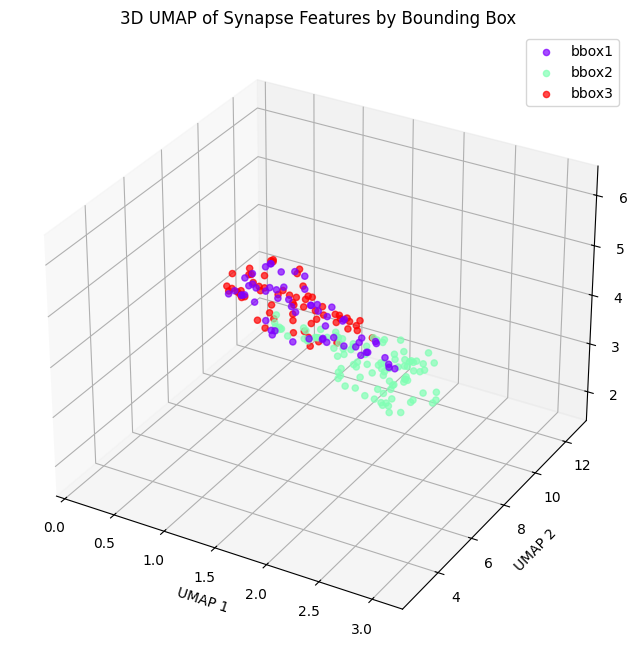

3D UMAP visualization completed.


In [ ]:

scaler = StandardScaler()
all_features_scaled = scaler.fit_transform(all_features_combined)

pca = PCA(n_components=50, random_state=42)
all_features_pca = pca.fit_transform(all_features_scaled)

reducer = umap.UMAP(n_components=3, random_state=42)
embedding_3d = reducer.fit_transform(all_features_pca)

combined_synapse_df['UMAP_1'] = embedding_3d[:, 0]
combined_synapse_df['UMAP_2'] = embedding_3d[:, 1]
combined_synapse_df['UMAP_3'] = embedding_3d[:, 2]

bbox_unique = combined_synapse_df['bbox_name'].unique()
colors = plt.cm.rainbow(np.linspace(0,1,len(bbox_unique)))
color_map = dict(zip(bbox_unique, colors))

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

for bbox in bbox_unique:
    subset = combined_synapse_df[combined_synapse_df['bbox_name'] == bbox]
    ax.scatter(subset['UMAP_1'], subset['UMAP_2'], subset['UMAP_3'],
               color=tuple(color_map[bbox]), label=bbox, alpha=0.7)

ax.set_title("3D UMAP of Synapse Features by Bounding Box")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
ax.legend()
plt.show()

print("3D UMAP visualization completed.")

In [ ]:
import plotly.express as px
import pandas as pd

fig = px.scatter_3d(
    combined_synapse_df,
    x='UMAP_1',
    y='UMAP_2',
    z='UMAP_3',
    color='bbox_name'
)

fig.update_traces(marker=dict(size=3))
fig.show()


# Processing all boxes Sequentially and save in csv

Downloaded VGG3D checkpoint.


<ipython-input-4-3b41e0d5ed9d>:145: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')


VGG3D model loaded and in eval mode.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViT model loaded and in eval mode.
Processing bbox1...
Saved features for bbox1 to csv_outputs/bbox1_features.csv
Processing bbox2...
Saved features for bbox2 to csv_outputs/bbox2_features.csv
Processing bbox3...
Saved features for bbox3 to csv_outputs/bbox3_features.csv
Processing bbox4...
Saved features for bbox4 to csv_outputs/bbox4_features.csv
Processing bbox5...
Saved features for bbox5 to csv_outputs/bbox5_features.csv
Processing bbox6...
Saved features for bbox6 to csv_outputs/bbox6_features.csv
Processing bbox7...
Saved features for bbox7 to csv_outputs/bbox7_features.csv
Merged 7 CSVs into one DataFrame with 509 synapses.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


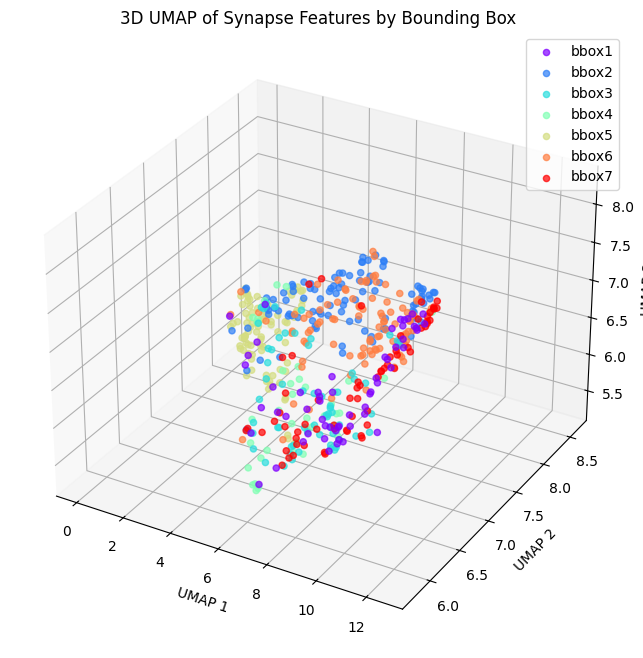

3D UMAP visualization completed.


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from transformers import ViTImageProcessor, ViTModel
from funlib.learn.torch.models import Vgg3D
import seaborn as sns
import umap
from PIL import Image
import imageio.v2 as iio
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import torch.nn.functional as F


raw_base_dir = '/content/raw'
seg_base_dir = '/content/seg'
bbox_names = [f'bbox{i}' for i in range(1,8)]  # Change to bbox(1,8) for all 7 if desired

def load_bbox_data(bbox_name, max_slices=None):
    raw_dir = os.path.join(raw_base_dir, bbox_name)
    seg_dir = os.path.join(seg_base_dir, bbox_name)

    raw_tif_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
    seg_tif_files = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))

    if max_slices is not None:
        raw_tif_files = raw_tif_files[:max_slices]
        seg_tif_files = seg_tif_files[:max_slices]

    assert len(raw_tif_files) == len(seg_tif_files), f"Raw/Seg mismatch in {bbox_name}"

    raw_slices = [iio.imread(f) for f in raw_tif_files]
    seg_slices = [iio.imread(f).astype(np.uint32) for f in seg_tif_files]

    raw_vol = np.stack(raw_slices, axis=0)  # (Z, Y, X)
    seg_vol = np.stack(seg_slices, axis=0)  # (Z, Y, X)
    return raw_vol, seg_vol

def create_segment_masks(seg_vol, side1_coord, side2_coord):
    x1, y1, z1 = [int(c) for c in side1_coord]
    x2, y2, z2 = [int(c) for c in side2_coord]

    seg_id_1 = seg_vol[z1, y1, x1]
    seg_id_2 = seg_vol[z2, y2, x2]

    mask_1 = (seg_vol == seg_id_1) if seg_id_1 != 0 else np.zeros_like(seg_vol, dtype=bool)
    mask_2 = (seg_vol == seg_id_2) if seg_id_2 != 0 else np.zeros_like(seg_vol, dtype=bool)
    return mask_1, mask_2

class SynapseDataset(Dataset):
    def __init__(self, vol_data_list, synapse_df, subvol_size=80):
        self.vol_data_list = vol_data_list
        self.synapse_df = synapse_df.reset_index(drop=True)
        self.subvol_size = subvol_size
        self.half_size = subvol_size // 2

    def __len__(self):
        return len(self.synapse_df)

    def __getitem__(self, idx):
        syn_info = self.synapse_df.iloc[idx]
        bbox_index = syn_info['bbox_index']  # Will be 0 for single-bbox processing
        raw_vol, seg_vol = self.vol_data_list[bbox_index]

        central_coord = (
            int(syn_info['central_coord_1']),
            int(syn_info['central_coord_2']),
            int(syn_info['central_coord_3'])
        )
        side1_coord = (
            int(syn_info['side_1_coord_1']),
            int(syn_info['side_1_coord_2']),
            int(syn_info['side_1_coord_3'])
        )
        side2_coord = (
            int(syn_info['side_2_coord_1']),
            int(syn_info['side_2_coord_2']),
            int(syn_info['side_2_coord_3'])
        )

        mask_1_full, mask_2_full = create_segment_masks(seg_vol, side1_coord, side2_coord)

        cx, cy, cz = central_coord
        x_start = max(cx - self.half_size, 0)
        x_end = min(cx + self.half_size, raw_vol.shape[2])
        y_start = max(cy - self.half_size, 0)
        y_end = min(cy + self.half_size, raw_vol.shape[1])
        z_start = max(cz - self.half_size, 0)
        z_end = min(cz + self.half_size, raw_vol.shape[0])

        sub_raw = raw_vol[z_start:z_end, y_start:y_end, x_start:x_end]

        desired_shape = (self.subvol_size, self.subvol_size, self.subvol_size)
        padded_sub_raw = np.zeros(desired_shape, dtype=sub_raw.dtype)

        dz, dy, dx = sub_raw.shape
        padded_sub_raw[:dz, :dy, :dx] = sub_raw

        # Extract slices
        axial_slice = padded_sub_raw[self.half_size, :, :]
        coronal_slice = padded_sub_raw[:, self.half_size, :]
        sagittal_slice = padded_sub_raw[:, :, self.half_size]

        sub_raw_tensor = torch.from_numpy(padded_sub_raw).unsqueeze(0).float()
        axial_slice_tensor = torch.from_numpy(axial_slice).unsqueeze(0).float()
        coronal_slice_tensor = torch.from_numpy(coronal_slice).unsqueeze(0).float()
        sagittal_slice_tensor = torch.from_numpy(sagittal_slice).unsqueeze(0).float()

        # Convert syn_info to dict (no DataFrame issues)
        syn_info_dict = syn_info.to_dict()

        return sub_raw_tensor, [axial_slice_tensor, coronal_slice_tensor, sagittal_slice_tensor], syn_info_dict


checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
checkpoint_path = 'hemibrain_production.checkpoint'
if not os.path.exists(checkpoint_path):
    print("Downloading VGG3D checkpoint...")
    import requests
    response = requests.get(checkpoint_url, stream=True)
    with open(checkpoint_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print("Downloaded VGG3D checkpoint.")
else:
    print("VGG3D checkpoint already exists.")

model_vgg = Vgg3D(
    input_size=(80, 80, 80),
    fmaps=24,
    downsample_factors=[(2, 2, 2)] * 4,
    fmap_inc=[2, 2, 2, 2],
    n_convolutions=[4, 2, 2, 2],
    output_classes=7
)

checkpoint = torch.load(checkpoint_path, map_location='cpu')
model_vgg.load_state_dict(checkpoint['model_state_dict'])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_vgg.to(device)
model_vgg.eval()
print("VGG3D model loaded and in eval mode.")

model_name = "google/vit-base-patch16-224-in21k"
image_processor = ViTImageProcessor.from_pretrained(model_name)
model_vit = ViTModel.from_pretrained(model_name).to(device)
model_vit.eval()
print("ViT model loaded and in eval mode.")

class Vgg3D_FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(Vgg3D_FeatureExtractor, self).__init__()
        self.features = original_model.features
        self.classifier = original_model.classifier
        # Remove last classification layer
        self.classifier = nn.Sequential(*list(self.classifier.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        features = self.classifier(x)
        return features

model_vgg_feat = Vgg3D_FeatureExtractor(model_vgg).to(device)
model_vgg_feat.eval()

def get_vit_features_batch(slices):
    pil_images = []
    for img in slices:
        if len(img.shape) == 2:
            img = np.stack([img]*3, axis=-1)
        pil_img = Image.fromarray(img.astype('uint8')).resize((224, 224))
        pil_images.append(pil_img)

    inputs = image_processor(images=pil_images, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model_vit(**inputs)
        feats = outputs.pooler_output.cpu().numpy()
    return feats

os.makedirs('csv_outputs', exist_ok=True)

# Process each bounding box sequentially
for i, bbox_name in enumerate(bbox_names):
    print(f"Processing {bbox_name}...")
    raw_vol, seg_vol = load_bbox_data(bbox_name)
    excel_file = f'{bbox_name}.xlsx'
    syn_df = pd.read_excel(excel_file)
    # Since we have only one bbox in vol_data_list for this loop, set bbox_index = 0
    syn_df['bbox_index'] = 0
    syn_df['bbox_name'] = bbox_name

    vol_data_list = [(raw_vol, seg_vol)]
    dataset_bbox = SynapseDataset(vol_data_list, syn_df, subvol_size=80)
    dataloader_bbox = DataLoader(dataset_bbox, batch_size=16, shuffle=False, num_workers=2)

    bbox_features = []
    bbox_syn_info = []

    for batch_idx, (sub_raw, triple_slices, syn_infos) in enumerate(dataloader_bbox):
        sub_raw = sub_raw.to(device)
        axial_slices = triple_slices[0].to(device)
        coronal_slices = triple_slices[1].to(device)
        sagittal_slices = triple_slices[2].to(device)

        with torch.no_grad():
            vgg_feats = model_vgg_feat(sub_raw)
        vgg_feats = vgg_feats.cpu().numpy()

        axial_slices_np = [axial_slices[i].squeeze(0).cpu().numpy() for i in range(axial_slices.size(0))]
        coronal_slices_np = [coronal_slices[i].squeeze(0).cpu().numpy() for i in range(coronal_slices.size(0))]
        sagittal_slices_np = [sagittal_slices[i].squeeze(0).cpu().numpy() for i in range(sagittal_slices.size(0))]

        vit_feats_axial = get_vit_features_batch(axial_slices_np)
        vit_feats_coronal = get_vit_features_batch(coronal_slices_np)
        vit_feats_sagittal = get_vit_features_batch(sagittal_slices_np)

        vit_feats = (vit_feats_axial + vit_feats_coronal + vit_feats_sagittal) / 3.0
        scalar_feats = sub_raw.mean(dim=[2,3,4]).cpu().numpy()

        combined_features = np.concatenate([vgg_feats, vit_feats, scalar_feats], axis=1)
        bbox_features.append(combined_features)

        syn_infos_df = pd.DataFrame(syn_infos)
        bbox_syn_info.append(syn_infos_df)

    bbox_features = np.concatenate(bbox_features, axis=0)
    bbox_syn_info = pd.concat(bbox_syn_info, axis=0).reset_index(drop=True)

    # Add features in one go to avoid fragmentation
    feature_cols = [f'feat_{j}' for j in range(bbox_features.shape[1])]
    features_df = pd.DataFrame(bbox_features, columns=feature_cols)

    output_df = pd.concat([bbox_syn_info, features_df], axis=1)
    output_csv_name = f'csv_outputs/{bbox_name}_features.csv'
    output_df.to_csv(output_csv_name, index=False)
    print(f"Saved features for {bbox_name} to {output_csv_name}")

# After processing all bboxes, combine CSVs
all_csvs = [f'csv_outputs/{bbox}_features.csv' for bbox in bbox_names]
merged_df = pd.concat([pd.read_csv(csv) for csv in all_csvs], ignore_index=True)
print(f"Merged {len(all_csvs)} CSVs into one DataFrame with {len(merged_df)} synapses.")

feature_cols = [c for c in merged_df.columns if c.startswith('feat_')]
all_features_combined = merged_df[feature_cols].values

# PCA and UMAP
scaler = StandardScaler()
all_features_scaled = scaler.fit_transform(all_features_combined)
pca = PCA(n_components=50, random_state=42)
all_features_pca = pca.fit_transform(all_features_scaled)

reducer = umap.UMAP(n_components=3, random_state=42)
embedding_3d = reducer.fit_transform(all_features_pca)

merged_df['UMAP_1'] = embedding_3d[:, 0]
merged_df['UMAP_2'] = embedding_3d[:, 1]
merged_df['UMAP_3'] = embedding_3d[:, 2]

bbox_unique = merged_df['bbox_name'].unique()
colors = plt.cm.rainbow(np.linspace(0,1,len(bbox_unique)))
color_map = dict(zip(bbox_unique, colors))

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
for bbox in bbox_unique:
    subset = merged_df[merged_df['bbox_name'] == bbox]
    ax.scatter(subset['UMAP_1'], subset['UMAP_2'], subset['UMAP_3'],
               color=tuple(color_map[bbox]), label=bbox, alpha=0.7)

ax.set_title("3D UMAP of Synapse Features by Bounding Box")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
ax.legend()
plt.show()

print("3D UMAP visualization completed.")

import plotly.express as px
fig = px.scatter_3d(
    merged_df,
    x='UMAP_1',
    y='UMAP_2',
    z='UMAP_3',
    color='bbox_name'
)
fig.update_traces(marker=dict(size=3))
fig.show()


In [ ]:
merged_df.to_csv("merged.csv")

In [ ]:
 !pip install umap-learn[plot]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 67.9 MB/s eta 0:00:00


In [ ]:
import plotly.express as px

# Create the 3D scatter plot with default color and shape
fig = px.scatter_3d(
    merged_df,
    x='UMAP_1',
    y='UMAP_2',
    z='UMAP_3',
    color='bbox_name'
)

# Update marker size and border
fig.update_traces(marker=dict(size=3))

# Apply a light theme using layout templates
fig.update_layout(template="plotly")  # Default light theme

# Save the plot as an HTML file
output_file = "3D_UMAP_Light.html"
fig.write_html(output_file)

# Display the plot
fig.show()

print(f"Plot saved as {output_file}. You can open this file in any web browser.")


Plot saved as 3D_UMAP_Light.html. You can open this file in any web browser.


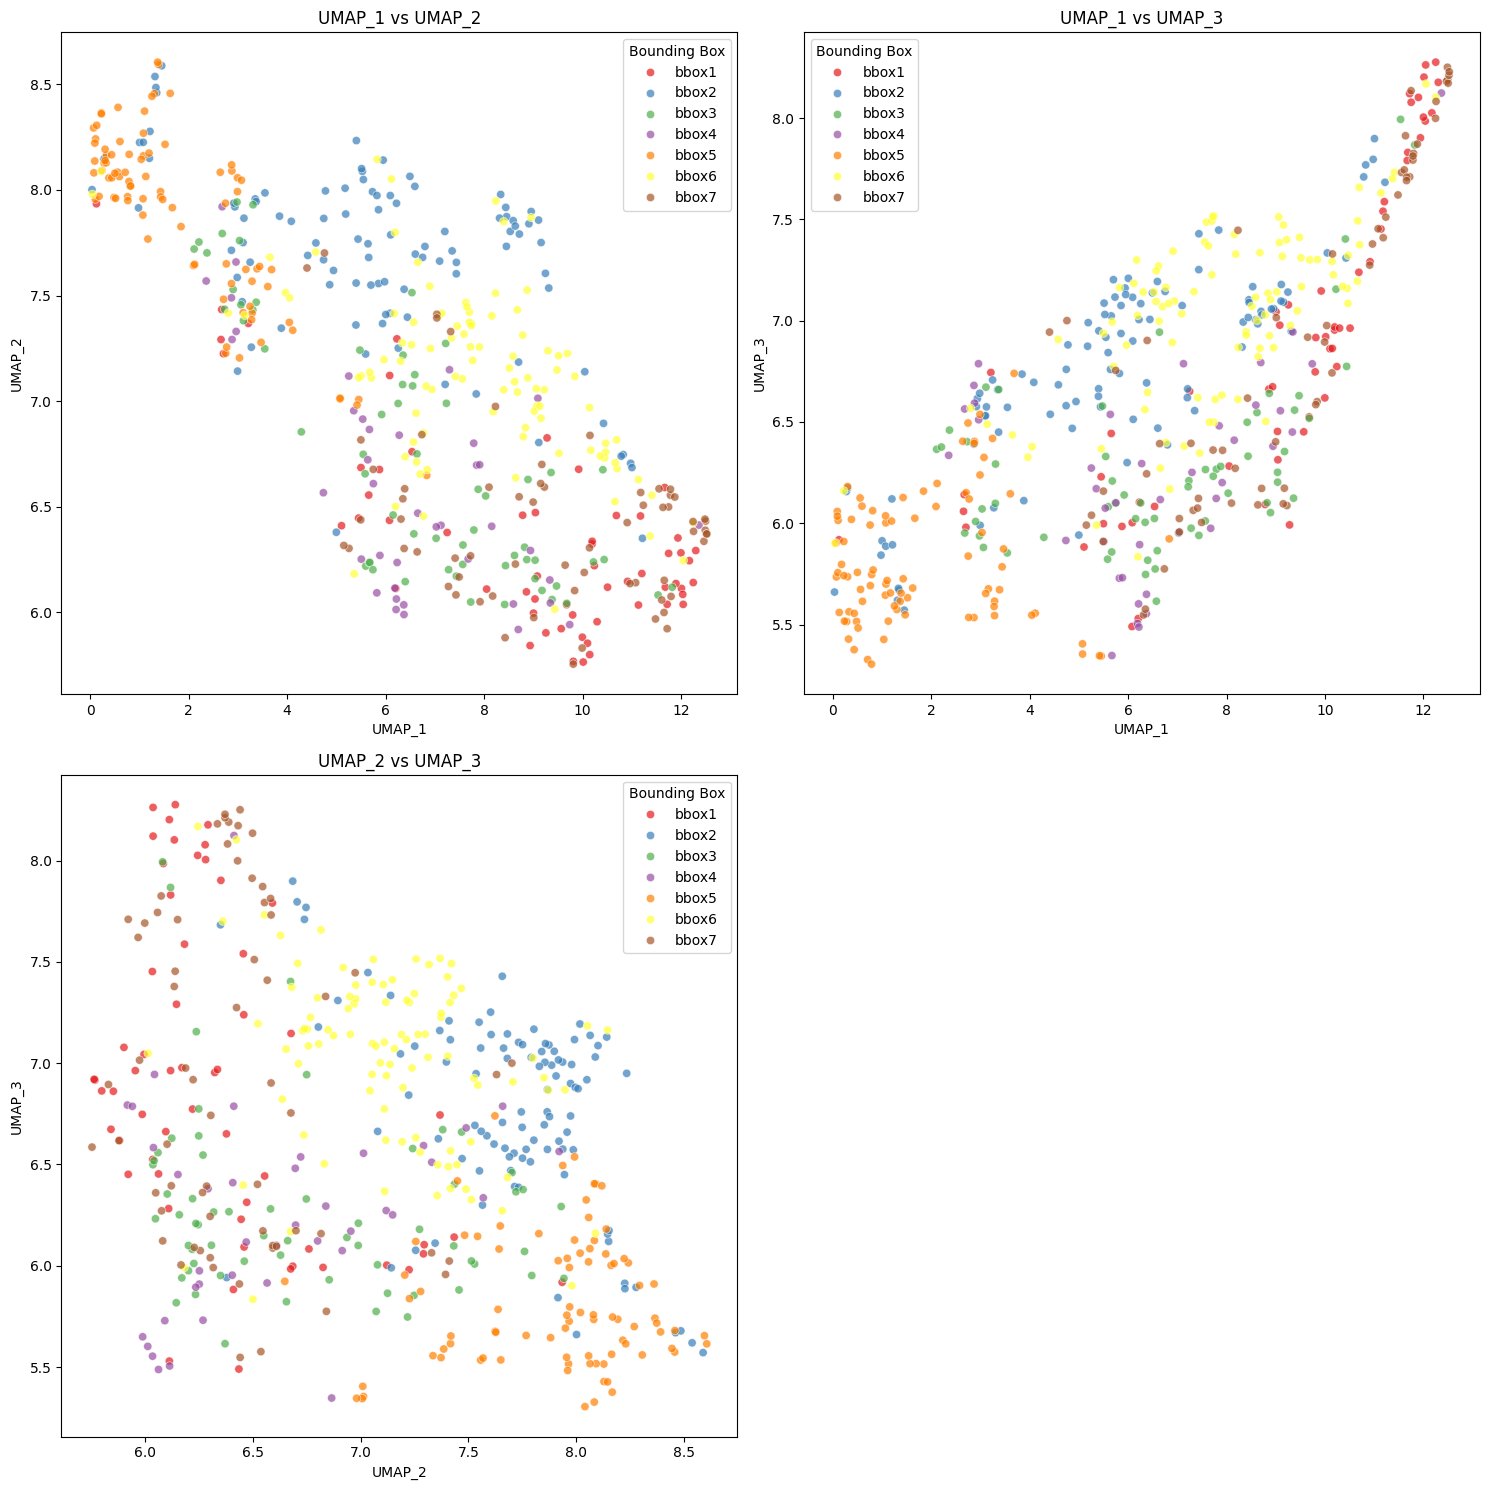

In [ ]:
# Plot different combinations of the three UMAP dimensions in 2D
def plot_2d_umap_combinations(df, bbox_col='bbox_name'):
    combinations = [('UMAP_1', 'UMAP_2'),
                    ('UMAP_1', 'UMAP_3'),
                    ('UMAP_2', 'UMAP_3')]
    plt.figure(figsize=(15, 15))

    for i, (dim_x, dim_y) in enumerate(combinations, start=1):
        plt.subplot(2, 2, i)
        sns.scatterplot(
            x=dim_x, y=dim_y,
            hue=bbox_col,
            palette='Set1',
            data=df,
            alpha=0.7
        )
        plt.title(f"{dim_x} vs {dim_y}")
        plt.xlabel(dim_x)
        plt.ylabel(dim_y)
        plt.legend(title='Bounding Box', loc='best')

    plt.tight_layout()
    plt.show()

# Call the function to generate 2D plots for the combined UMAP dimensions
plot_2d_umap_combinations(merged_df)


# 2D Representation

In [ ]:

# # Load bounding box data
# def load_bbox_data(bbox_name, max_slices=None):
#     raw_dir = os.path.join(raw_base_dir, bbox_name)
#     seg_dir = os.path.join(seg_base_dir, bbox_name)

#     raw_tif_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
#     seg_tif_files = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))

#     if max_slices:
#         raw_tif_files = raw_tif_files[:max_slices]
#         seg_tif_files = seg_tif_files[:max_slices]

#     assert len(raw_tif_files) == len(seg_tif_files), f"Raw/Seg mismatch in {bbox_name}"

#     raw_slices = [iio.imread(f) for f in raw_tif_files]
#     seg_slices = [iio.imread(f).astype(np.uint32) for f in seg_tif_files]

#     raw_vol = np.stack(raw_slices, axis=0)  # Shape: (Z, Y, X)
#     seg_vol = np.stack(seg_slices, axis=0)  # Shape: (Z, Y, X)
#     return raw_vol, seg_vol

# # Synapse Dataset
# class SynapseDataset(Dataset):
#     def __init__(self, vol_data_list, synapse_df, subvol_size=80):
#         self.vol_data_list = vol_data_list
#         self.synapse_df = synapse_df.reset_index(drop=True)
#         self.subvol_size = subvol_size
#         self.half_size = subvol_size // 2

#     def __len__(self):
#         return len(self.synapse_df)

#     def __getitem__(self, idx):
#         syn_info = self.synapse_df.iloc[idx]
#         bbox_index = syn_info['bbox_index']
#         raw_vol, seg_vol = self.vol_data_list[bbox_index]

#         central_coord = (
#             int(syn_info['central_coord_1']),
#             int(syn_info['central_coord_2']),
#             int(syn_info['central_coord_3'])
#         )

#         cx, cy, cz = central_coord
#         x_start = max(cx - self.half_size, 0)
#         x_end = min(cx + self.half_size, raw_vol.shape[2])
#         y_start = max(cy - self.half_size, 0)
#         y_end = min(cy + self.half_size, raw_vol.shape[1])
#         z_start = max(cz - self.half_size, 0)
#         z_end = min(cz + self.half_size, raw_vol.shape[0])

#         sub_raw = raw_vol[z_start:z_end, y_start:y_end, x_start:x_end]

#         desired_shape = (self.subvol_size, self.subvol_size, self.subvol_size)
#         padded_sub_raw = np.zeros(desired_shape, dtype=sub_raw.dtype)

#         dz, dy, dx = sub_raw.shape
#         padded_sub_raw[:dz, :dy, :dx] = sub_raw

#         axial_slice = padded_sub_raw[self.half_size, :, :]
#         coronal_slice = padded_sub_raw[:, self.half_size, :]
#         sagittal_slice = padded_sub_raw[:, :, self.half_size]

#         sub_raw_tensor = torch.from_numpy(padded_sub_raw).unsqueeze(0).float()
#         axial_slice_tensor = torch.from_numpy(axial_slice).unsqueeze(0).float()
#         coronal_slice_tensor = torch.from_numpy(coronal_slice).unsqueeze(0).float()
#         sagittal_slice_tensor = torch.from_numpy(sagittal_slice).unsqueeze(0).float()

#         return sub_raw_tensor, [axial_slice_tensor, coronal_slice_tensor, sagittal_slice_tensor], syn_info['Var1']


# for i, bbox_name in enumerate(bbox_names):
#     raw_vol, seg_vol = load_bbox_data(bbox_name)
#     excel_file = f'{bbox_name}.xlsx'
#     syn_df = pd.read_excel(excel_file)
#     syn_df['bbox_index'] = i  # Track which bbox the synapse belongs to
#     syn_df['bbox_name'] = bbox_name  # Add bbox name
#     processed_dfs.append(syn_df)

# # Combine all bounding box data
# merged_df = pd.concat(processed_dfs, ignore_index=True)

# # Dataset creation
# vol_data_list = [(load_bbox_data(bbox_name)) for bbox_name in bbox_names]
# dataset = SynapseDataset(vol_data_list, merged_df, subvol_size=80)
# dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=2)

# # Feature extraction placeholder
# all_features = []
# var1_list = []

# for batch_idx, (sub_raw, central_slices, var1) in enumerate(dataloader):
#     sub_raw = sub_raw.numpy()
#     all_features.append(sub_raw.mean(axis=(2, 3, 4)))  # Replace with real feature extraction
#     var1_list.extend(var1)

# # Combine features into a DataFrame
# all_features_combined = np.concatenate(all_features, axis=0)
# merged_df['Var1'] = var1_list

# # Perform UMAP
# scaler = StandardScaler()
# all_features_scaled = scaler.fit_transform(all_features_combined)
# reducer = umap.UMAP(n_components=3, random_state=42)
# embedding = reducer.fit_transform(all_features_scaled)

# merged_df['UMAP_1'] = embedding[:, 0]
# merged_df['UMAP_2'] = embedding[:, 1]
# merged_df['UMAP_3'] = embedding[:, 2]

# # Visualize with Var1 in hover
# def plot_umap_with_var1(df):
#     fig = px.scatter_3d(
#         df,
#         x='UMAP_1',
#         y='UMAP_2',
#         z='UMAP_3',
#         color='bbox_name',
#         hover_data=['Var1', 'bbox_name', 'UMAP_1', 'UMAP_2', 'UMAP_3'],
#         title="3D UMAP Visualization with Var1"
#     )
#     fig.update_traces(marker=dict(size=5))
#     fig.show()

# plot_umap_with_var1(merged_df)


# # Load and process data
# os.makedirs('csv_outputs', exist_ok=True)
# processed_dfs = []

# for i, bbox_name in enumerate(bbox_names):
#     raw_vol, seg_vol = load_bbox_data(bbox_name)
#     excel_file = f'{bbox_name}.xlsx'
#     syn_df = pd.read_excel(excel_file)
#     syn_df['bbox_index'] = i  # Track which bbox the synapse belongs to
#     syn_df['bbox_name'] = bbox_name  # Add bbox name
#     processed_dfs.append(syn_df)

# # Combine all bounding box data
# merged_df = pd.concat(processed_dfs, ignore_index=True)

# # Dataset creation
# vol_data_list = [(load_bbox_data(bbox_name)) for bbox_name in bbox_names]
# dataset = SynapseDataset(vol_data_list, merged_df, subvol_size=80)
# dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=2)

# # Perform UMAP
# scaler = StandardScaler()
# all_features_scaled = scaler.fit_transform(all_features_combined)
# reducer = umap.UMAP(n_components=3, random_state=42)
# embedding = reducer.fit_transform(all_features_scaled)

# merged_df['UMAP_1'] = embedding[:, 0]
# merged_df['UMAP_2'] = embedding[:, 1]
# merged_df['UMAP_3'] = embedding[:, 2]

# # Visualize with Var1 in hover
# def plot_umap_with_var1(df):
#     fig = px.scatter_3d(
#         df,
#         x='UMAP_1',
#         y='UMAP_2',
#         z='UMAP_3',
#         color='bbox_name',
#         hover_data=['Var1', 'bbox_name', 'UMAP_1', 'UMAP_2', 'UMAP_3'],
#         title="3D UMAP Visualization with Var1"
#     )
#     fig.update_traces(marker=dict(size=5))
#     fig.show()

# plot_umap_with_var1(merged_df)

KeyboardInterrupt: 

In [ ]:
import plotly.express as px

# Function to create interactive 2D UMAP projections with Plotly
def plot_2d_umap_combinations_plotly(df, bbox_col='bbox_name'):
    combinations = [
        ('UMAP_1', 'UMAP_2'),
        ('UMAP_1', 'UMAP_3'),
        ('UMAP_2', 'UMAP_3')
    ]

    for dim_x, dim_y in combinations:
        fig = px.scatter(
            df,
            x=dim_x,
            y=dim_y,
            color=bbox_col,
            title=f"2D UMAP Projection: {dim_x} vs {dim_y}",
            labels={dim_x: dim_x, dim_y: dim_y, bbox_col: 'Bounding Box'},
            color_discrete_sequence=px.colors.qualitative.Set1
        )
        fig.update_traces(marker=dict(size=5, opacity=0.8))
        fig.show()

# Call the function to visualize the 2D UMAP projections
plot_2d_umap_combinations_plotly(merged_df)


ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['Var1', 'central_coord_1', 'central_coord_2', 'central_coord_3', 'side_1_coord_1', 'side_1_coord_2', 'side_1_coord_3', 'side_2_coord_1', 'side_2_coord_2', 'side_2_coord_3', 'bbox_index', 'bbox_name'] but received: UMAP_1

In [ ]:
import plotly.express as px

# Function to create interactive 2D UMAP projections with sample metadata
def plot_2d_umap_with_metadata(df, bbox_col='bbox_name'):
    combinations = [
        ('UMAP_1', 'UMAP_2'),
        ('UMAP_1', 'UMAP_3'),
        ('UMAP_2', 'UMAP_3')
    ]

    # Ensure the DataFrame contains metadata columns
    metadata_cols = ['bbox_name', 'central_coord_1', 'central_coord_2', 'central_coord_3']
    metadata_cols = [col for col in metadata_cols if col in df.columns]

    for dim_x, dim_y in combinations:
        fig = px.scatter(
            df,
            x=dim_x,
            y=dim_y,
            color=bbox_col,
            hover_data=metadata_cols,  # Include metadata in hover tooltips
            title=f"2D UMAP Projection: {dim_x} vs {dim_y}",
            labels={dim_x: dim_x, dim_y: dim_y, bbox_col: 'Bounding Box'},
            color_discrete_sequence=px.colors.qualitative.Set1
        )
        fig.update_traces(marker=dict(size=5, opacity=0.8))
        fig.show()

# Call the function to visualize the 2D UMAP projections with metadata
plot_2d_umap_with_metadata(merged_df)


Processing bbox1...
Saved features for bbox1 to csv_outputs/bbox1_features.csv
Processing bbox2...
Saved features for bbox2 to csv_outputs/bbox2_features.csv
Processing bbox3...
Saved features for bbox3 to csv_outputs/bbox3_features.csv
Processing bbox4...
Saved features for bbox4 to csv_outputs/bbox4_features.csv
Processing bbox5...
Saved features for bbox5 to csv_outputs/bbox5_features.csv
Processing bbox6...
Saved features for bbox6 to csv_outputs/bbox6_features.csv
Processing bbox7...
Saved features for bbox7 to csv_outputs/bbox7_features.csv
Merged 7 CSVs into one DataFrame with 509 synapses.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



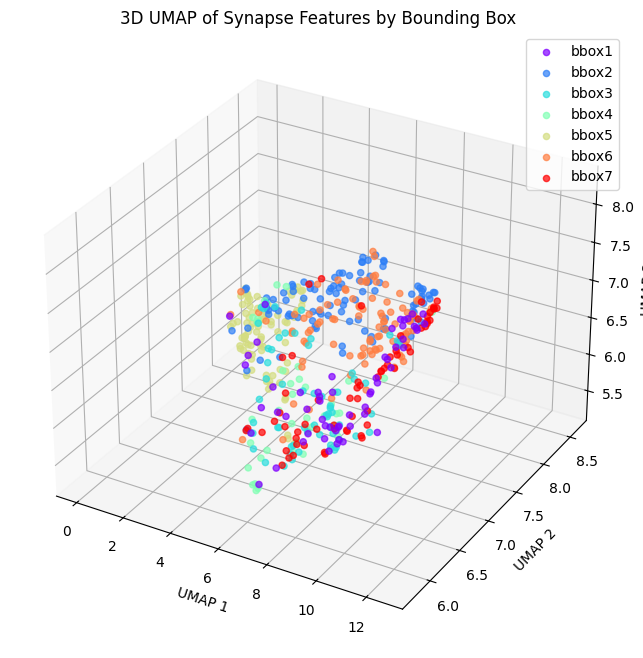

3D UMAP visualization completed.


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from transformers import ViTImageProcessor, ViTModel
from funlib.learn.torch.models import Vgg3D
import seaborn as sns
import umap
from PIL import Image
import imageio.v2 as iio
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import torch.nn.functional as F


raw_base_dir = '/content/raw'
seg_base_dir = '/content/seg'
bbox_names = [f'bbox{i}' for i in range(1,8)]  # Change to bbox(1,8) for all 7 if desired

def load_bbox_data(bbox_name, max_slices=None):
    raw_dir = os.path.join(raw_base_dir, bbox_name)
    seg_dir = os.path.join(seg_base_dir, bbox_name)

    raw_tif_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
    seg_tif_files = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))

    if max_slices is not None:
        raw_tif_files = raw_tif_files[:max_slices]
        seg_tif_files = seg_tif_files[:max_slices]

    assert len(raw_tif_files) == len(seg_tif_files), f"Raw/Seg mismatch in {bbox_name}"

    raw_slices = [iio.imread(f) for f in raw_tif_files]
    seg_slices = [iio.imread(f).astype(np.uint32) for f in seg_tif_files]

    raw_vol = np.stack(raw_slices, axis=0)  # (Z, Y, X)
    seg_vol = np.stack(seg_slices, axis=0)  # (Z, Y, X)
    return raw_vol, seg_vol

def create_segment_masks(seg_vol, side1_coord, side2_coord):
    x1, y1, z1 = [int(c) for c in side1_coord]
    x2, y2, z2 = [int(c) for c in side2_coord]

    seg_id_1 = seg_vol[z1, y1, x1]
    seg_id_2 = seg_vol[z2, y2, x2]

    mask_1 = (seg_vol == seg_id_1) if seg_id_1 != 0 else np.zeros_like(seg_vol, dtype=bool)
    mask_2 = (seg_vol == seg_id_2) if seg_id_2 != 0 else np.zeros_like(seg_vol, dtype=bool)
    return mask_1, mask_2

class SynapseDataset(Dataset):
    def __init__(self, vol_data_list, synapse_df, subvol_size=80):
        self.vol_data_list = vol_data_list
        self.synapse_df = synapse_df.reset_index(drop=True)
        self.subvol_size = subvol_size
        self.half_size = subvol_size // 2

    def __len__(self):
        return len(self.synapse_df)

    def __getitem__(self, idx):
        syn_info = self.synapse_df.iloc[idx]
        bbox_index = syn_info['bbox_index']  # Will be 0 for single-bbox processing
        raw_vol, seg_vol = self.vol_data_list[bbox_index]

        central_coord = (
            int(syn_info['central_coord_1']),
            int(syn_info['central_coord_2']),
            int(syn_info['central_coord_3'])
        )
        side1_coord = (
            int(syn_info['side_1_coord_1']),
            int(syn_info['side_1_coord_2']),
            int(syn_info['side_1_coord_3'])
        )
        side2_coord = (
            int(syn_info['side_2_coord_1']),
            int(syn_info['side_2_coord_2']),
            int(syn_info['side_2_coord_3'])
        )

        mask_1_full, mask_2_full = create_segment_masks(seg_vol, side1_coord, side2_coord)

        cx, cy, cz = central_coord
        x_start = max(cx - self.half_size, 0)
        x_end = min(cx + self.half_size, raw_vol.shape[2])
        y_start = max(cy - self.half_size, 0)
        y_end = min(cy + self.half_size, raw_vol.shape[1])
        z_start = max(cz - self.half_size, 0)
        z_end = min(cz + self.half_size, raw_vol.shape[0])

        sub_raw = raw_vol[z_start:z_end, y_start:y_end, x_start:x_end]

        desired_shape = (self.subvol_size, self.subvol_size, self.subvol_size)
        padded_sub_raw = np.zeros(desired_shape, dtype=sub_raw.dtype)

        dz, dy, dx = sub_raw.shape
        padded_sub_raw[:dz, :dy, :dx] = sub_raw

        # Extract slices
        axial_slice = padded_sub_raw[self.half_size, :, :]
        coronal_slice = padded_sub_raw[:, self.half_size, :]
        sagittal_slice = padded_sub_raw[:, :, self.half_size]

        sub_raw_tensor = torch.from_numpy(padded_sub_raw).unsqueeze(0).float()
        axial_slice_tensor = torch.from_numpy(axial_slice).unsqueeze(0).float()
        coronal_slice_tensor = torch.from_numpy(coronal_slice).unsqueeze(0).float()
        sagittal_slice_tensor = torch.from_numpy(sagittal_slice).unsqueeze(0).float()

        # Convert syn_info to dict (no DataFrame issues)
        syn_info_dict = syn_info.to_dict()

        return sub_raw_tensor, [axial_slice_tensor, coronal_slice_tensor, sagittal_slice_tensor], syn_info_dict


# checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
# checkpoint_path = 'hemibrain_production.checkpoint'
# if not os.path.exists(checkpoint_path):
#     print("Downloading VGG3D checkpoint...")
#     import requests
#     response = requests.get(checkpoint_url, stream=True)
#     with open(checkpoint_path, 'wb') as f:
#         for chunk in response.iter_content(chunk_size=8192):
#             if chunk:
#                 f.write(chunk)
#     print("Downloaded VGG3D checkpoint.")
# else:
#     print("VGG3D checkpoint already exists.")

# model_vgg = Vgg3D(
#     input_size=(80, 80, 80),
#     fmaps=24,
#     downsample_factors=[(2, 2, 2)] * 4,
#     fmap_inc=[2, 2, 2, 2],
#     n_convolutions=[4, 2, 2, 2],
#     output_classes=7
# )

# checkpoint = torch.load(checkpoint_path, map_location='cpu')
# model_vgg.load_state_dict(checkpoint['model_state_dict'])
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model_vgg.to(device)
# model_vgg.eval()
# print("VGG3D model loaded and in eval mode.")

# model_name = "google/vit-base-patch16-224-in21k"
# image_processor = ViTImageProcessor.from_pretrained(model_name)
# model_vit = ViTModel.from_pretrained(model_name).to(device)
# model_vit.eval()
# print("ViT model loaded and in eval mode.")

class Vgg3D_FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(Vgg3D_FeatureExtractor, self).__init__()
        self.features = original_model.features
        self.classifier = original_model.classifier
        # Remove last classification layer
        self.classifier = nn.Sequential(*list(self.classifier.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        features = self.classifier(x)
        return features

model_vgg_feat = Vgg3D_FeatureExtractor(model_vgg).to(device)
model_vgg_feat.eval()

def get_vit_features_batch(slices):
    pil_images = []
    for img in slices:
        if len(img.shape) == 2:
            img = np.stack([img]*3, axis=-1)
        pil_img = Image.fromarray(img.astype('uint8')).resize((224, 224))
        pil_images.append(pil_img)

    inputs = image_processor(images=pil_images, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model_vit(**inputs)
        feats = outputs.pooler_output.cpu().numpy()
    return feats

os.makedirs('csv_outputs', exist_ok=True)

# Process each bounding box sequentially
for i, bbox_name in enumerate(bbox_names):
    print(f"Processing {bbox_name}...")
    raw_vol, seg_vol = load_bbox_data(bbox_name)
    excel_file = f'{bbox_name}.xlsx'
    syn_df = pd.read_excel(excel_file)
    # Since we have only one bbox in vol_data_list for this loop, set bbox_index = 0
    syn_df['bbox_index'] = 0
    syn_df['bbox_name'] = bbox_name

    vol_data_list = [(raw_vol, seg_vol)]
    dataset_bbox = SynapseDataset(vol_data_list, syn_df, subvol_size=80)
    dataloader_bbox = DataLoader(dataset_bbox, batch_size=16, shuffle=False, num_workers=2)

    bbox_features = []
    bbox_syn_info = []

    for batch_idx, (sub_raw, triple_slices, syn_infos) in enumerate(dataloader_bbox):
        sub_raw = sub_raw.to(device)
        axial_slices = triple_slices[0].to(device)
        coronal_slices = triple_slices[1].to(device)
        sagittal_slices = triple_slices[2].to(device)

        with torch.no_grad():
            vgg_feats = model_vgg_feat(sub_raw)
        vgg_feats = vgg_feats.cpu().numpy()

        axial_slices_np = [axial_slices[i].squeeze(0).cpu().numpy() for i in range(axial_slices.size(0))]
        coronal_slices_np = [coronal_slices[i].squeeze(0).cpu().numpy() for i in range(coronal_slices.size(0))]
        sagittal_slices_np = [sagittal_slices[i].squeeze(0).cpu().numpy() for i in range(sagittal_slices.size(0))]

        vit_feats_axial = get_vit_features_batch(axial_slices_np)
        vit_feats_coronal = get_vit_features_batch(coronal_slices_np)
        vit_feats_sagittal = get_vit_features_batch(sagittal_slices_np)

        vit_feats = (vit_feats_axial + vit_feats_coronal + vit_feats_sagittal) / 3.0
        scalar_feats = sub_raw.mean(dim=[2,3,4]).cpu().numpy()

        combined_features = np.concatenate([vgg_feats, vit_feats, scalar_feats], axis=1)
        bbox_features.append(combined_features)

        syn_infos_df = pd.DataFrame(syn_infos)
        bbox_syn_info.append(syn_infos_df)

    bbox_features = np.concatenate(bbox_features, axis=0)
    bbox_syn_info = pd.concat(bbox_syn_info, axis=0).reset_index(drop=True)

    # Add features in one go to avoid fragmentation
    feature_cols = [f'feat_{j}' for j in range(bbox_features.shape[1])]
    features_df = pd.DataFrame(bbox_features, columns=feature_cols)

    output_df = pd.concat([bbox_syn_info, features_df], axis=1)
    output_csv_name = f'csv_outputs/{bbox_name}_features.csv'
    output_df.to_csv(output_csv_name, index=False)
    print(f"Saved features for {bbox_name} to {output_csv_name}")

# After processing all bboxes, combine CSVs
all_csvs = [f'csv_outputs/{bbox}_features.csv' for bbox in bbox_names]
merged_df = pd.concat([pd.read_csv(csv) for csv in all_csvs], ignore_index=True)
print(f"Merged {len(all_csvs)} CSVs into one DataFrame with {len(merged_df)} synapses.")

feature_cols = [c for c in merged_df.columns if c.startswith('feat_')]
all_features_combined = merged_df[feature_cols].values

# PCA and UMAP
scaler = StandardScaler()
all_features_scaled = scaler.fit_transform(all_features_combined)
pca = PCA(n_components=50, random_state=42)
all_features_pca = pca.fit_transform(all_features_scaled)

reducer = umap.UMAP(n_components=3, random_state=42)
embedding_3d = reducer.fit_transform(all_features_pca)

merged_df['UMAP_1'] = embedding_3d[:, 0]
merged_df['UMAP_2'] = embedding_3d[:, 1]
merged_df['UMAP_3'] = embedding_3d[:, 2]

bbox_unique = merged_df['bbox_name'].unique()
colors = plt.cm.rainbow(np.linspace(0,1,len(bbox_unique)))
color_map = dict(zip(bbox_unique, colors))

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
for bbox in bbox_unique:
    subset = merged_df[merged_df['bbox_name'] == bbox]
    ax.scatter(subset['UMAP_1'], subset['UMAP_2'], subset['UMAP_3'],
               color=tuple(color_map[bbox]), label=bbox, alpha=0.7)

ax.set_title("3D UMAP of Synapse Features by Bounding Box")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
ax.legend()
plt.show()

print("3D UMAP visualization completed.")

import plotly.express as px
fig = px.scatter_3d(
    merged_df,
    x='UMAP_1',
    y='UMAP_2',
    z='UMAP_3',
    color='bbox_name'
)
fig.update_traces(marker=dict(size=3))
fig.show()


In [ ]:
import plotly.express as px

# UMAP_1 vs UMAP_2
fig_12 = px.scatter(
    merged_df,
    x='UMAP_1',
    y='UMAP_2',
    color='bbox_name',
    hover_data=['Var1']  # shows Var1 in hover
)
fig_12.update_traces(marker=dict(size=4))
fig_12.show()

# UMAP_1 vs UMAP_3
fig_13 = px.scatter(
    merged_df,
    x='UMAP_1',
    y='UMAP_3',
    color='bbox_name',
    hover_data=['Var1']
)
fig_13.update_traces(marker=dict(size=4))
fig_13.show()

# UMAP_2 vs UMAP_3
fig_23 = px.scatter(
    merged_df,
    x='UMAP_2',
    y='UMAP_3',
    color='bbox_name',
    hover_data=['Var1']
)
fig_23.update_traces(marker=dict(size=4))
fig_23.show()


In [ ]:
import numpy as np

# Sort merged_df "from the left" in the (UMAP_3, UMAP_1) plot
# i.e., ascending by UMAP_3 (the x-axis if you plotted UMAP_3 on the horizontal axis)
df_sorted = merged_df.sort_values(by="UMAP_3").reset_index(drop=True)

chunk_size = 10

for start_idx in range(0, len(df_sorted), chunk_size):
    chunk = df_sorted.iloc[start_idx : start_idx + chunk_size]

    # Focus only on bbox2 and bbox6 inside this chunk
    chunk_bbox2 = chunk[chunk["bbox_name"] == "bbox2"]
    chunk_bbox6 = chunk[chunk["bbox_name"] == "bbox6"]

    # If either is empty, skip
    if chunk_bbox2.empty or chunk_bbox6.empty:
        continue

    # We'll find the single pair (one from bbox2, one from bbox6) that
    # are closest in (UMAP_3, UMAP_1) space.
    min_dist = float('inf')
    best_pair = None

    for idx2, row2 in chunk_bbox2.iterrows():
        for idx6, row6 in chunk_bbox6.iterrows():
            dist = np.sqrt(
                (row2["UMAP_3"] - row6["UMAP_3"])**2 +
                (row2["UMAP_1"] - row6["UMAP_1"])**2
            )
            if dist < min_dist:
                min_dist = dist
                best_pair = (row2, row6)

    # If we found a valid pair, print their details
    if best_pair:
        row2, row6 = best_pair
        print(f"\nCHUNK {start_idx} to {start_idx + chunk_size - 1}, Dist = {min_dist:.3f}")
        print(f"  Bbox2 -> Var1: {row2['Var1']}, (UMAP_3, UMAP_1) = ({row2['UMAP_3']:.2f}, {row2['UMAP_1']:.2f})")
        print(f"  Bbox6 -> Var1: {row6['Var1']}, (UMAP_3, UMAP_1) = ({row6['UMAP_3']:.2f}, {row6['UMAP_1']:.2f})")

        # ----------------------------------------------------
        # OPTIONAL: LOAD AND DISPLAY CENTER SLICES
        # ----------------------------------------------------
        # If you still have raw volumes on disk and want
        # to see the actual subvolume slices side by side,
        # you could do something like:
        #
        #   slice2 = extract_subvolume_center_slice(row2)
        #   slice6 = extract_subvolume_center_slice(row6)
        #
        #   import matplotlib.pyplot as plt
        #   fig, axes = plt.subplots(1,2, figsize=(6,3))
        #   axes[0].imshow(slice2, cmap='gray')
        #   axes[0].set_title(f"Bbox2 - {row2['Var1']}")
        #   axes[1].imshow(slice6, cmap='gray')
        #   axes[1].set_title(f"Bbox6 - {row6['Var1']}")
        #   plt.show()
        #
        # 'extract_subvolume_center_slice(row)' would be
        # a small helper that loads the bounding box data,
        # extracts the subvolume using row['central_coord_1'], etc.,
        # and returns an axial slice. This is similar to how you do
        # it in SynapseDataset.__getitem__().
import plotly.express as px

fig = px.scatter(
    merged_df,
    x='UMAP_3',
    y='UMAP_1',
    color='bbox_name',
    hover_data=['Var1']  # so you see Var1 on hover
)
fig.show()



CHUNK 70 to 79, Dist = 5.220
  Bbox2 -> Var1: explorative_2024-11-07_Cora_Wolter_131, (UMAP_3, UMAP_1) = (5.84, 0.98)
  Bbox6 -> Var1: non_spine_synapse_026, (UMAP_3, UMAP_1) = (5.83, 6.20)

CHUNK 80 to 89, Dist = 1.034
  Bbox2 -> Var1: explorative_2024-08-29_Vera_Broens_096, (UMAP_3, UMAP_1) = (5.89, 1.08)
  Bbox6 -> Var1: non_spine_synapse_011, (UMAP_3, UMAP_1) = (5.90, 0.04)

CHUNK 100 to 109, Dist = 2.366
  Bbox2 -> Var1: explorative_2024-10-17_Valentin_Pinkau_123, (UMAP_3, UMAP_1) = (5.99, 2.99)
  Bbox6 -> Var1: non_spine_synapse_025, (UMAP_3, UMAP_1) = (5.99, 5.36)

CHUNK 170 to 179, Dist = 0.079
  Bbox2 -> Var1: explorative_2024-08-28_Cora_Wolter_059, (UMAP_3, UMAP_1) = (6.17, 0.30)
  Bbox6 -> Var1: non_spine_synapse_016, (UMAP_3, UMAP_1) = (6.16, 0.22)

CHUNK 190 to 199, Dist = 0.676
  Bbox2 -> Var1: explorative_2024-08-29_Vera_Broens_090, (UMAP_3, UMAP_1) = (6.30, 5.98)
  Bbox6 -> Var1: spine_synapse_019, (UMAP_3, UMAP_1) = (6.27, 6.65)

CHUNK 210 to 219, Dist = 0.340
  Bbox2


CHUNK 70 to 79, Dist = 5.220
  bbox2 -> Var1: explorative_2024-11-07_Cora_Wolter_131, (UMAP_3, UMAP_1) = (5.84, 0.98)
  bbox6 -> Var1: non_spine_synapse_026, (UMAP_3, UMAP_1) = (5.83, 6.20)


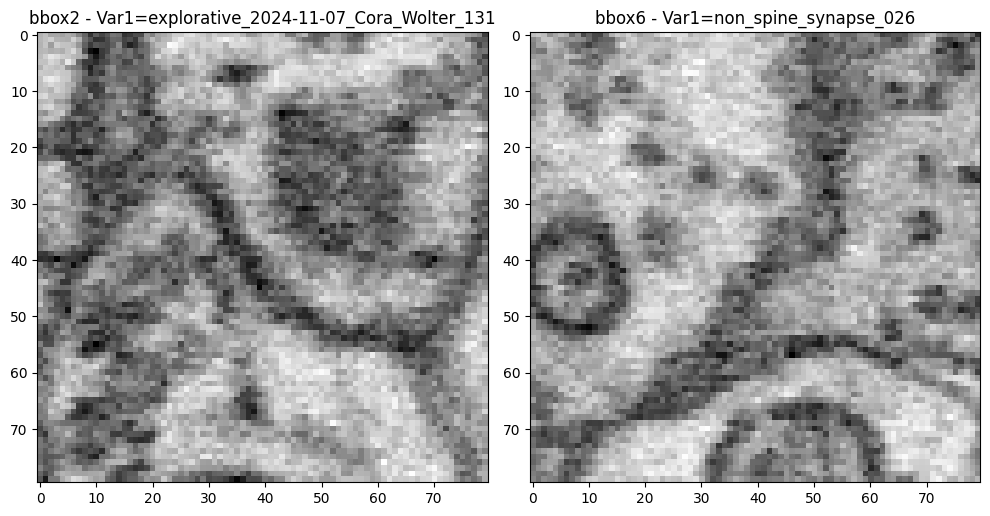


CHUNK 80 to 89, Dist = 1.034
  bbox2 -> Var1: explorative_2024-08-29_Vera_Broens_096, (UMAP_3, UMAP_1) = (5.89, 1.08)
  bbox6 -> Var1: non_spine_synapse_011, (UMAP_3, UMAP_1) = (5.90, 0.04)


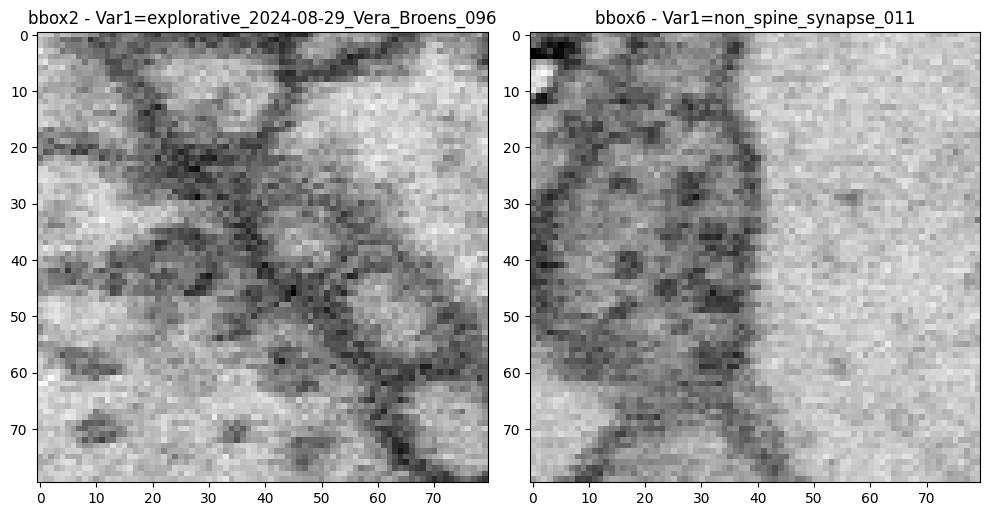


CHUNK 100 to 109, Dist = 2.366
  bbox2 -> Var1: explorative_2024-10-17_Valentin_Pinkau_123, (UMAP_3, UMAP_1) = (5.99, 2.99)
  bbox6 -> Var1: non_spine_synapse_025, (UMAP_3, UMAP_1) = (5.99, 5.36)


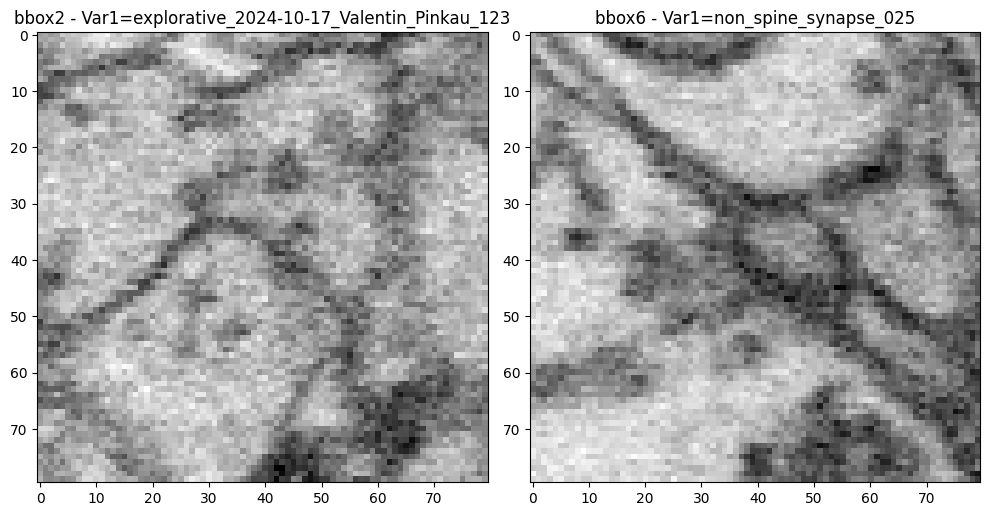


CHUNK 170 to 179, Dist = 0.079
  bbox2 -> Var1: explorative_2024-08-28_Cora_Wolter_059, (UMAP_3, UMAP_1) = (6.17, 0.30)
  bbox6 -> Var1: non_spine_synapse_016, (UMAP_3, UMAP_1) = (6.16, 0.22)


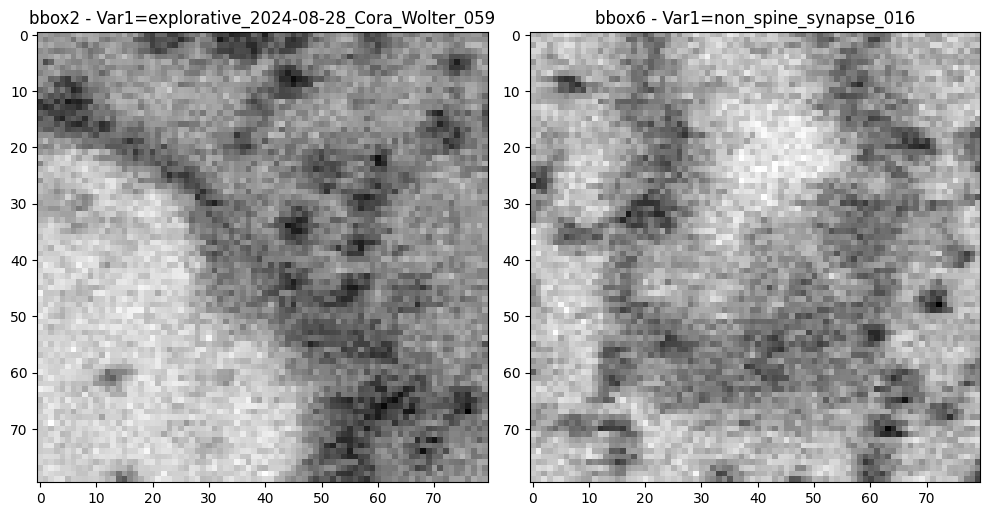


CHUNK 190 to 199, Dist = 0.676
  bbox2 -> Var1: explorative_2024-08-29_Vera_Broens_090, (UMAP_3, UMAP_1) = (6.30, 5.98)
  bbox6 -> Var1: spine_synapse_019, (UMAP_3, UMAP_1) = (6.27, 6.65)


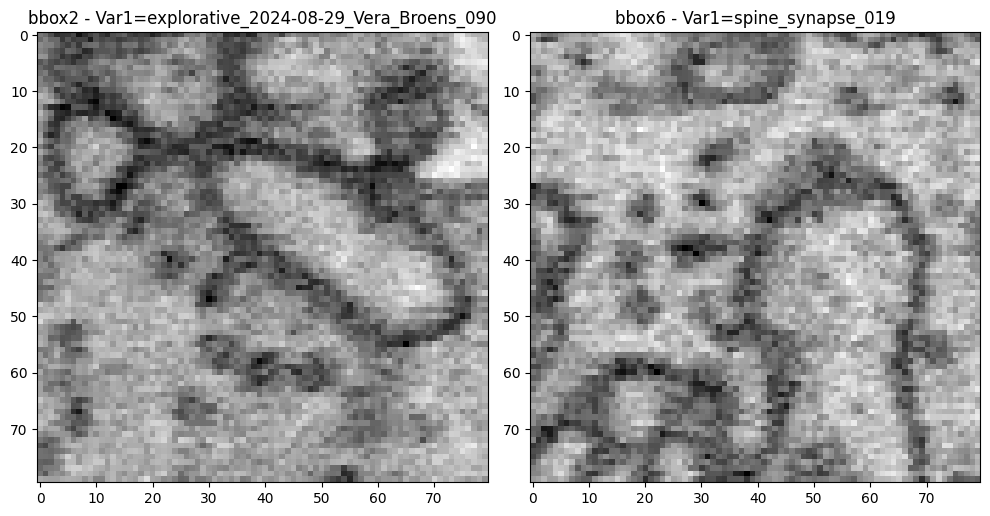


CHUNK 210 to 219, Dist = 0.340
  bbox2 -> Var1: explorative_2024-08-29_Vera_Broens_083, (UMAP_3, UMAP_1) = (6.39, 6.80)
  bbox6 -> Var1: spine_synapse_012, (UMAP_3, UMAP_1) = (6.38, 7.14)


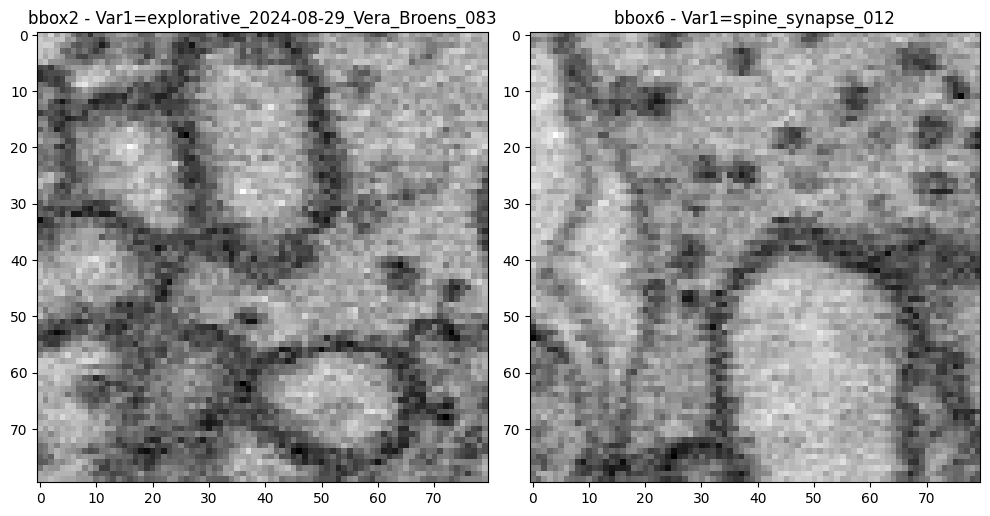


CHUNK 230 to 239, Dist = 0.236
  bbox2 -> Var1: explorative_2024-08-29_Dominic_Evans_062, (UMAP_3, UMAP_1) = (6.45, 3.37)
  bbox6 -> Var1: non_spine_synapse_014, (UMAP_3, UMAP_1) = (6.49, 3.14)


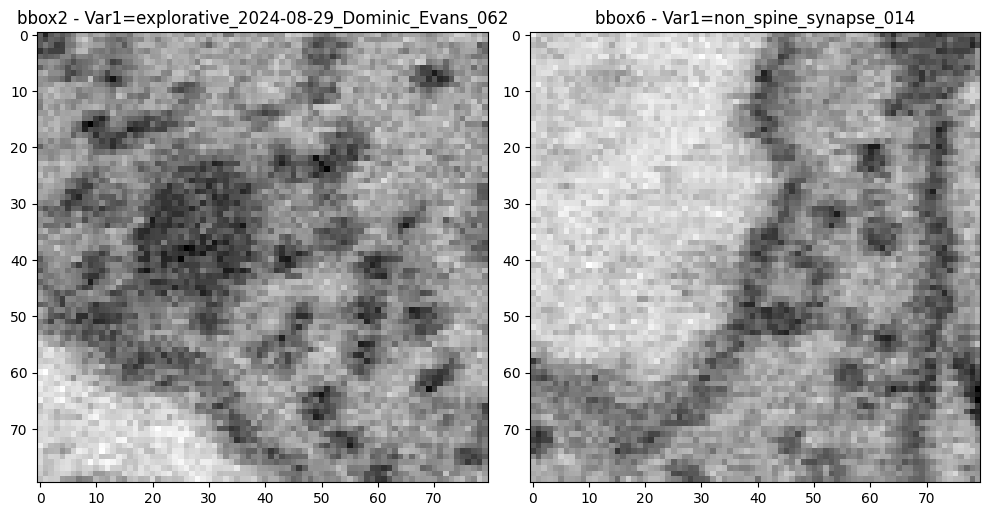


CHUNK 240 to 249, Dist = 1.548
  bbox2 -> Var1: explorative_2024-08-29_Dominic_Evans_078, (UMAP_3, UMAP_1) = (6.51, 6.10)
  bbox6 -> Var1: non_spine_synapse_004, (UMAP_3, UMAP_1) = (6.50, 7.65)


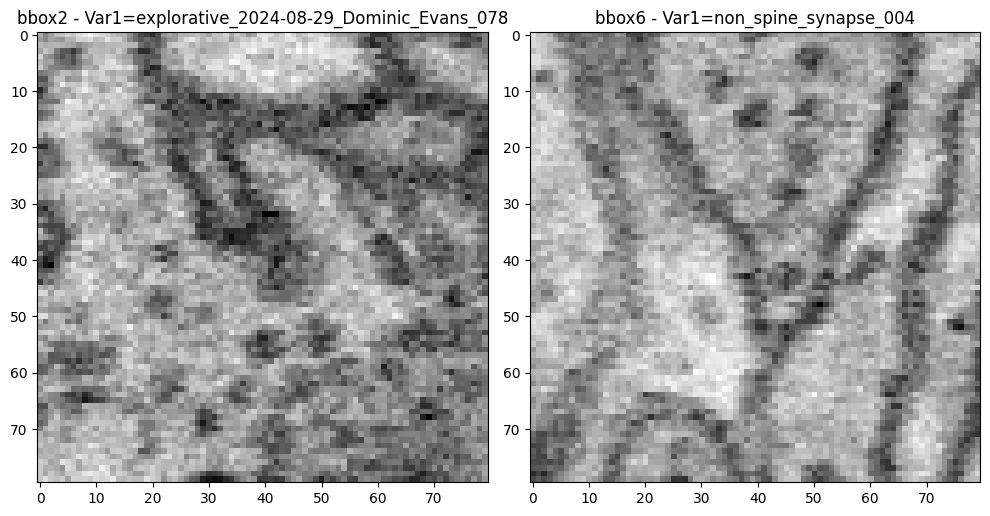


CHUNK 250 to 259, Dist = 1.011
  bbox2 -> Var1: explorative_2024-08-29_Vera_Broens_085, (UMAP_3, UMAP_1) = (6.56, 7.35)
  bbox6 -> Var1: non_spine_synapse_003, (UMAP_3, UMAP_1) = (6.56, 6.34)


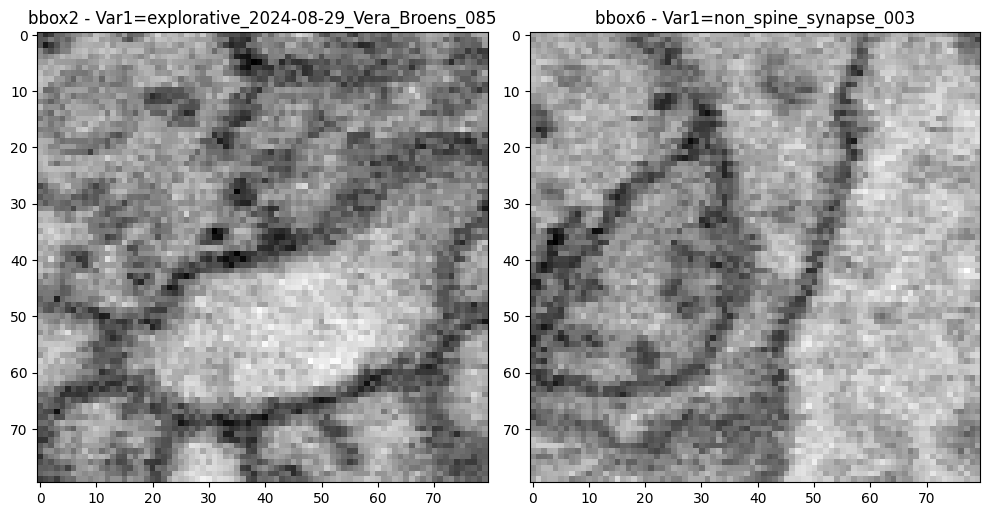


CHUNK 270 to 279, Dist = 0.214
  bbox2 -> Var1: explorative_2024-08-28_Cora_Wolter_042, (UMAP_3, UMAP_1) = (6.62, 7.20)
  bbox6 -> Var1: spine_synapse_047   , (UMAP_3, UMAP_1) = (6.62, 7.42)


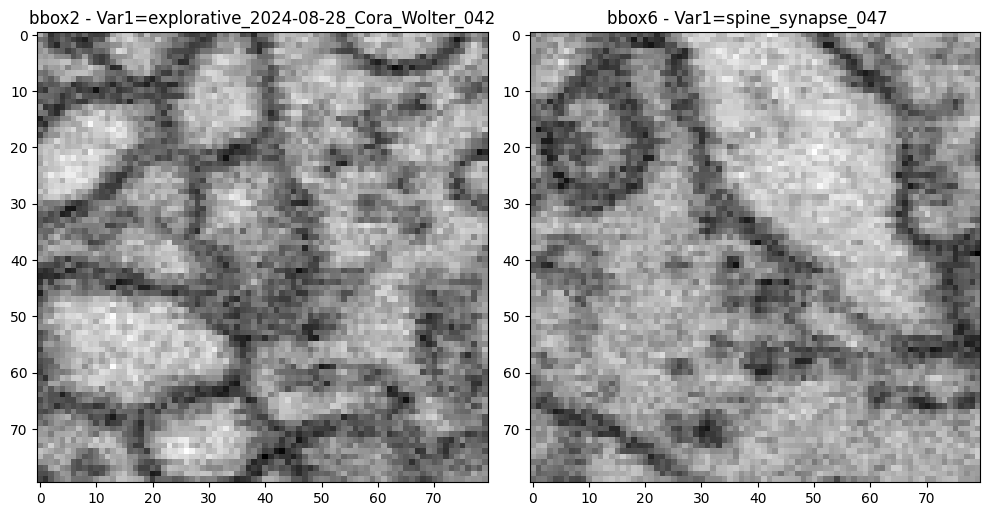


CHUNK 280 to 289, Dist = 0.695
  bbox2 -> Var1: explorative_2024-08-29_Dominic_Evans_077, (UMAP_3, UMAP_1) = (6.66, 7.21)
  bbox6 -> Var1: non_spine_synapse_024, (UMAP_3, UMAP_1) = (6.63, 7.90)


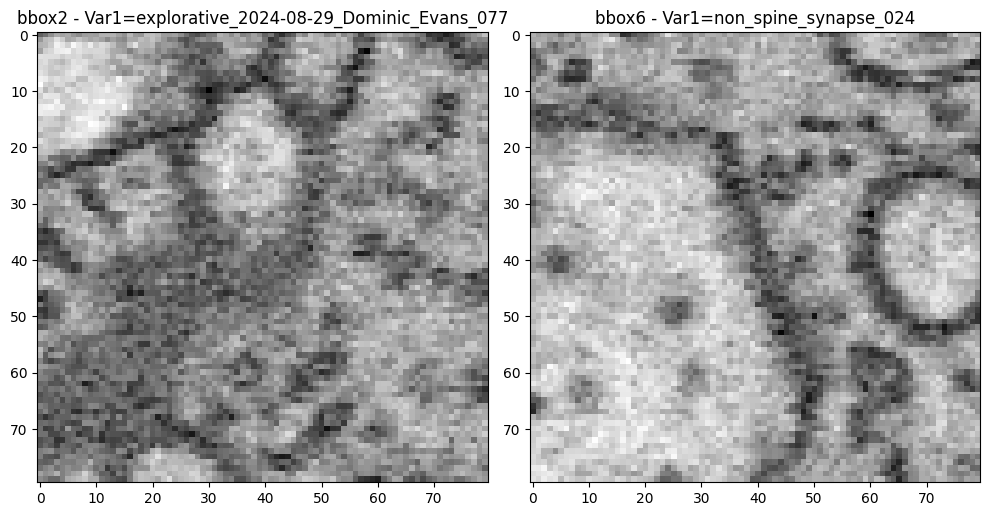


CHUNK 300 to 309, Dist = 0.069
  bbox2 -> Var1: explorative_2024-08-29_Vera_Broens_088, (UMAP_3, UMAP_1) = (6.76, 5.64)
  bbox6 -> Var1: non_spine_synapse_022, (UMAP_3, UMAP_1) = (6.77, 5.71)


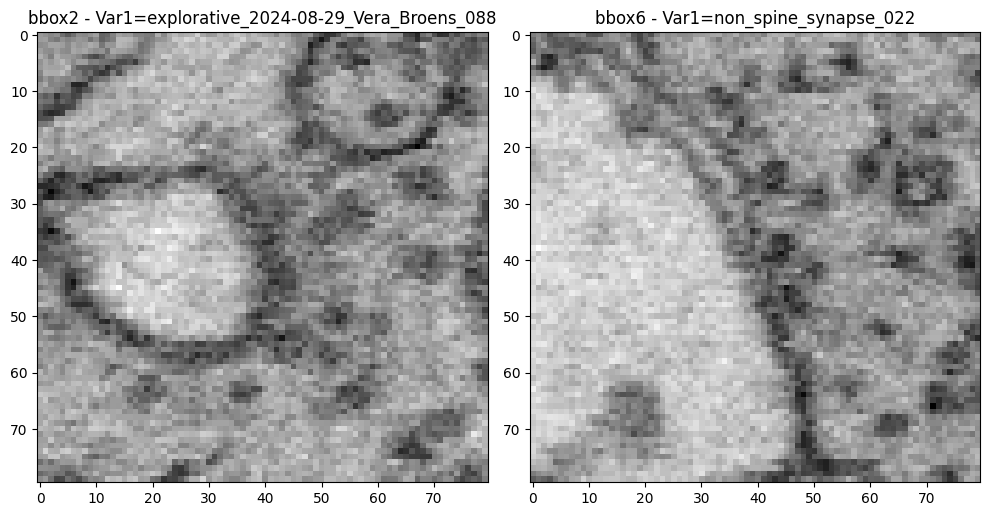


CHUNK 310 to 319, Dist = 2.644
  bbox2 -> Var1: explorative_2024-08-28_Cora_Wolter_027, (UMAP_3, UMAP_1) = (6.84, 5.59)
  bbox6 -> Var1: non_spine_synapse_017, (UMAP_3, UMAP_1) = (6.87, 8.24)


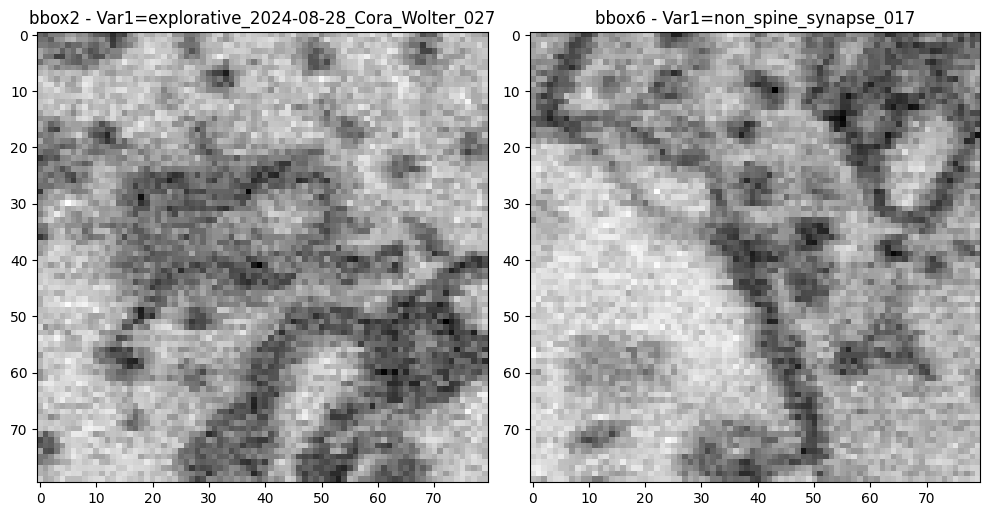


CHUNK 320 to 329, Dist = 0.129
  bbox2 -> Var1: explorative_2024-08-28_Cora_Wolter_054, (UMAP_3, UMAP_1) = (6.90, 6.09)
  bbox6 -> Var1: spine_synapse_064, (UMAP_3, UMAP_1) = (6.88, 5.97)


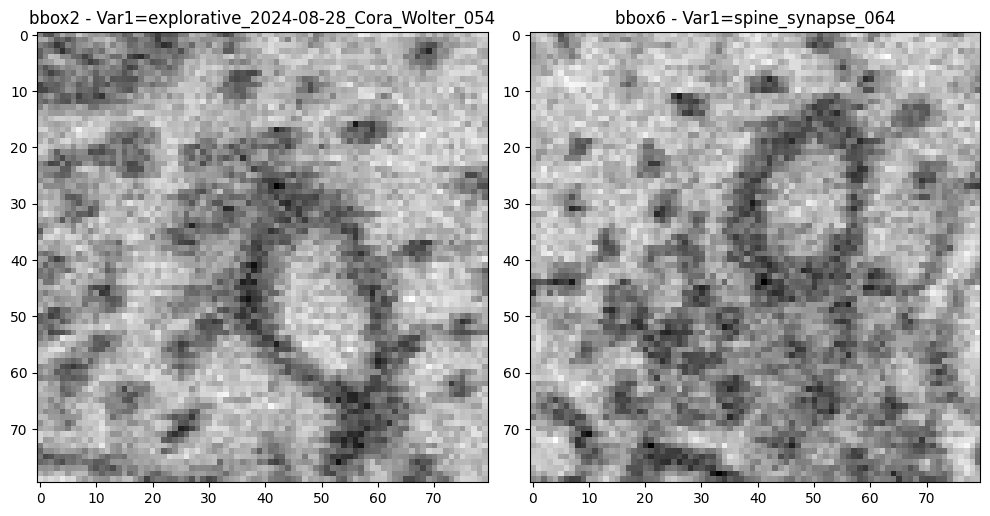


CHUNK 330 to 339, Dist = 0.052
  bbox2 -> Var1: explorative_2024-08-28_Cora_Wolter_006, (UMAP_3, UMAP_1) = (6.92, 5.55)
  bbox6 -> Var1: non_spine_synapse_023, (UMAP_3, UMAP_1) = (6.94, 5.50)


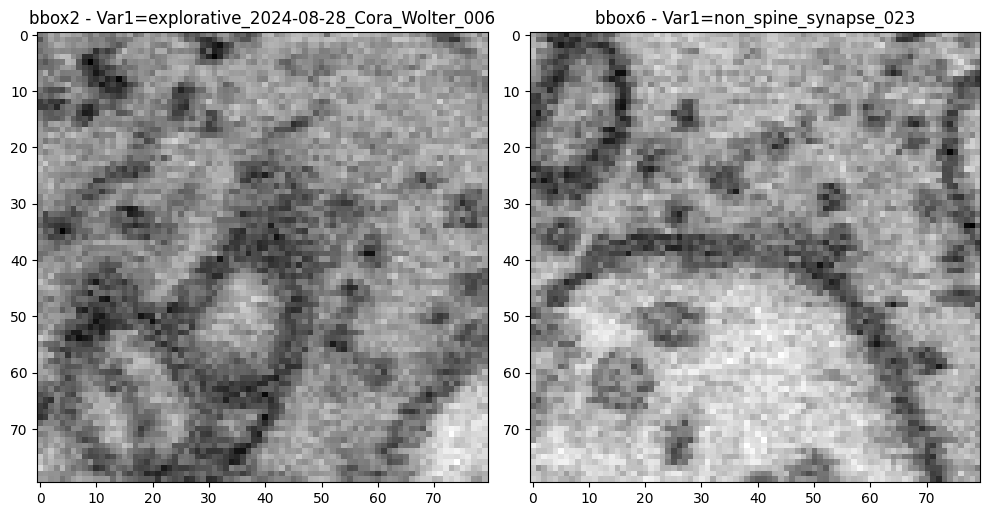


CHUNK 340 to 349, Dist = 0.033
  bbox2 -> Var1: explorative_2024-10-16_Valentin_Pinkau_117, (UMAP_3, UMAP_1) = (6.95, 9.31)
  bbox6 -> Var1: non_spine_synapse_013, (UMAP_3, UMAP_1) = (6.98, 9.30)


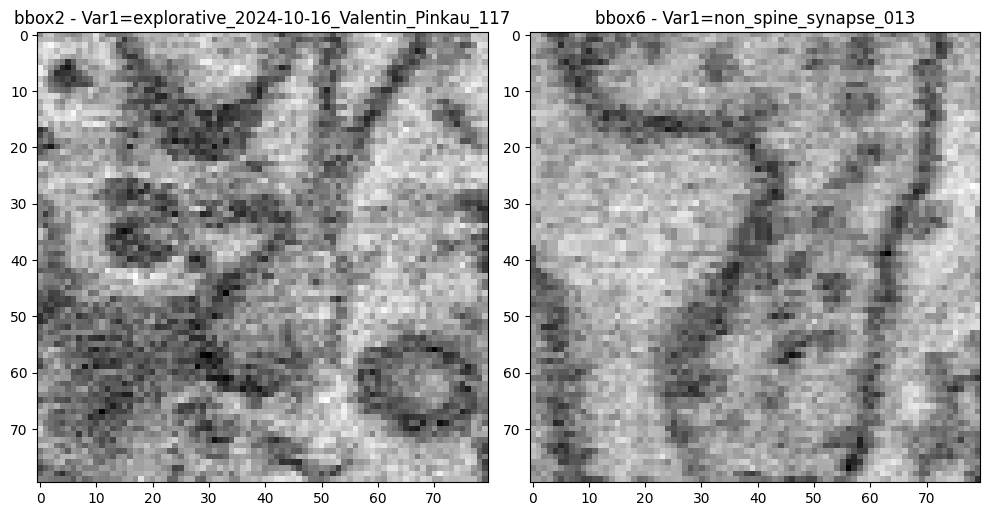


CHUNK 350 to 359, Dist = 0.022
  bbox2 -> Var1: explorative_2024-08-28_Cora_Wolter_003, (UMAP_3, UMAP_1) = (6.98, 8.63)
  bbox6 -> Var1: spine_synapse_059, (UMAP_3, UMAP_1) = (7.00, 8.62)


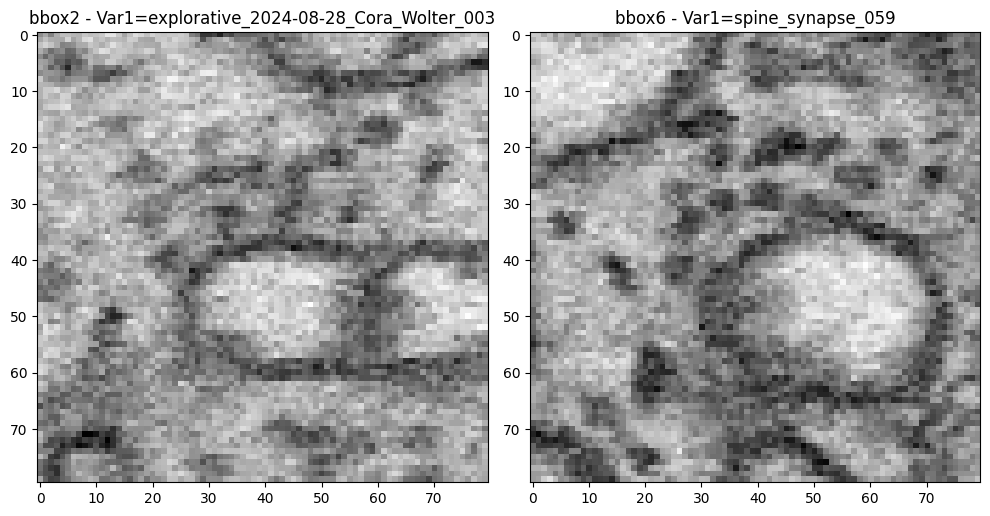


CHUNK 360 to 369, Dist = 0.069
  bbox2 -> Var1: explorative_2024-08-28_Cora_Wolter_011, (UMAP_3, UMAP_1) = (7.03, 8.72)
  bbox6 -> Var1: spine_synapse_056, (UMAP_3, UMAP_1) = (7.03, 8.79)


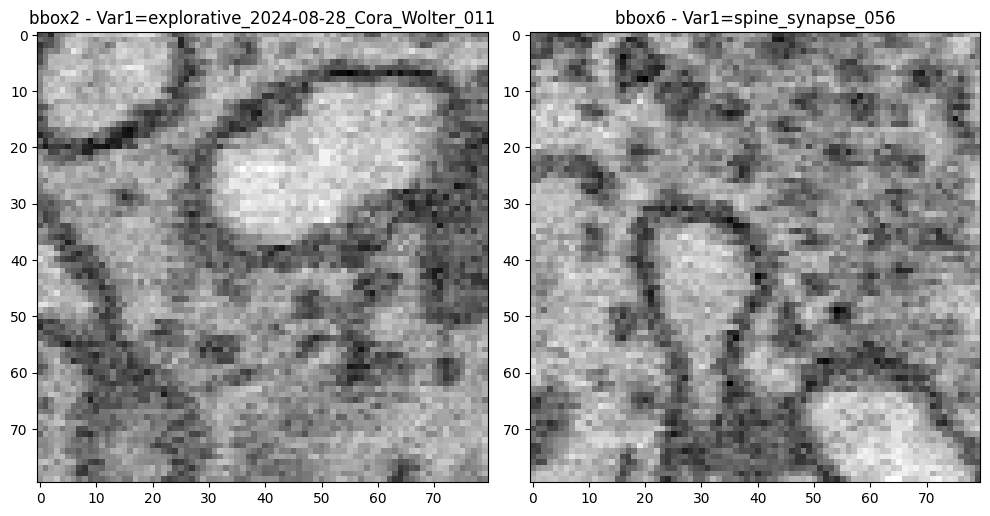


CHUNK 370 to 379, Dist = 0.275
  bbox2 -> Var1: explorative_2024-08-28_Cora_Wolter_009, (UMAP_3, UMAP_1) = (7.07, 7.10)
  bbox6 -> Var1: spine_synapse_027, (UMAP_3, UMAP_1) = (7.08, 6.82)


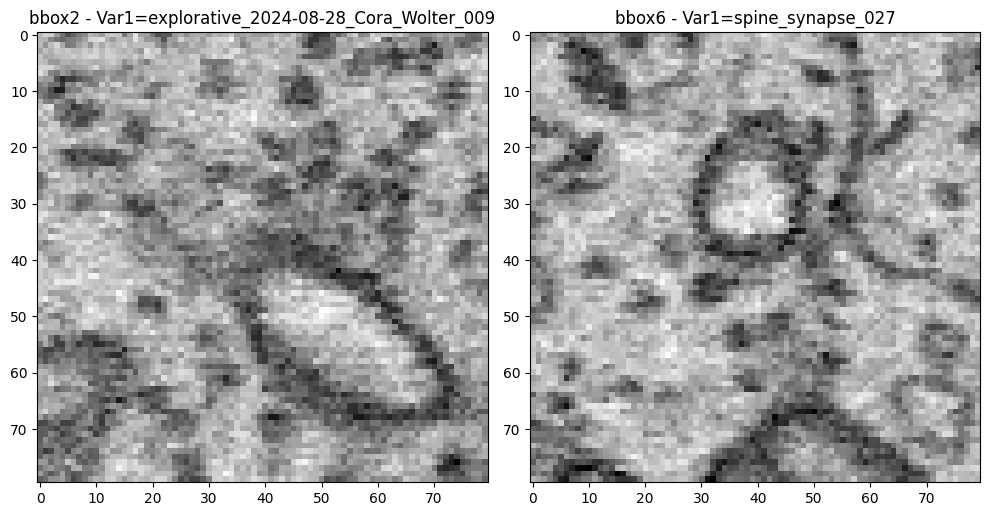


CHUNK 380 to 389, Dist = 0.217
  bbox2 -> Var1: explorative_2024-08-28_Cora_Wolter_023, (UMAP_3, UMAP_1) = (7.10, 9.11)
  bbox6 -> Var1: spine_synapse_022, (UMAP_3, UMAP_1) = (7.10, 8.89)


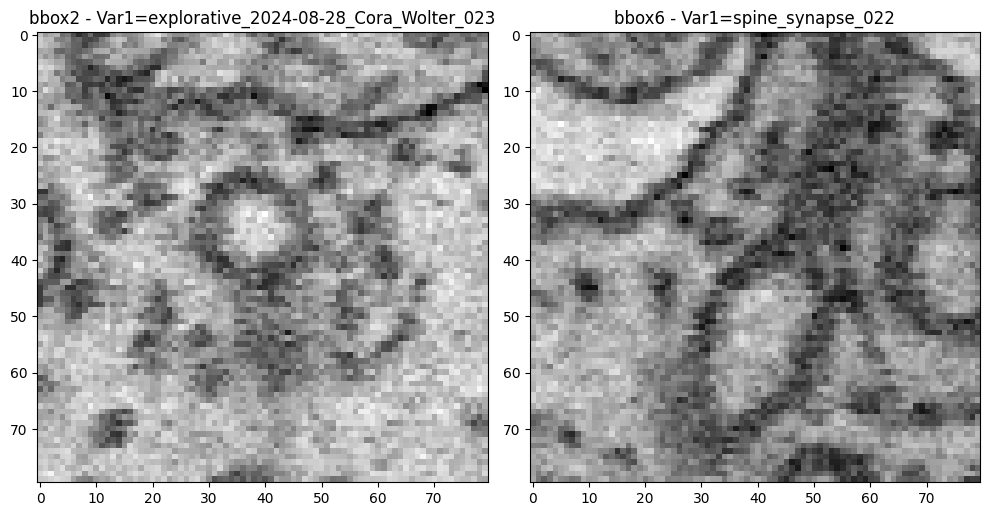


CHUNK 390 to 399, Dist = 0.034
  bbox2 -> Var1: explorative_2024-08-28_Cora_Wolter_039, (UMAP_3, UMAP_1) = (7.14, 6.49)
  bbox6 -> Var1: non_spine_synapse_010, (UMAP_3, UMAP_1) = (7.14, 6.53)


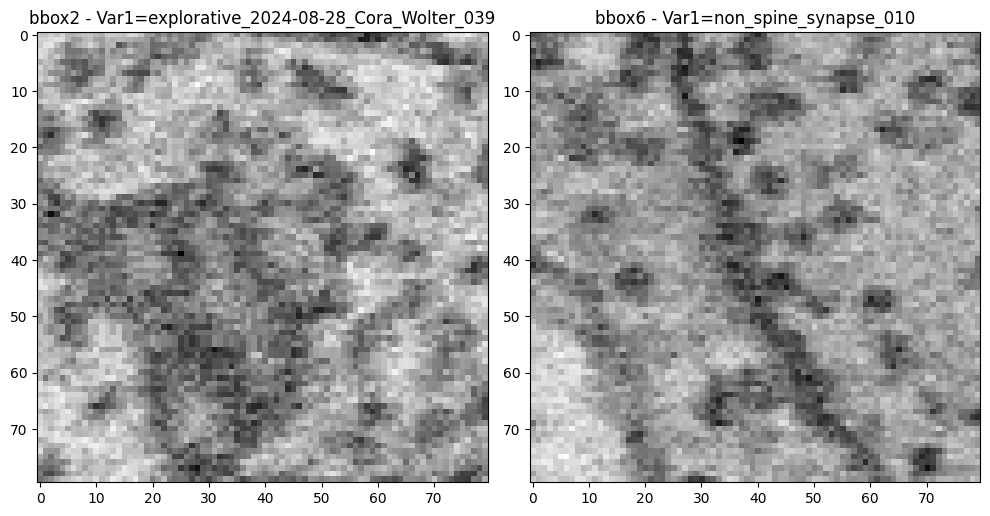


CHUNK 400 to 409, Dist = 0.027
  bbox2 -> Var1: explorative_2024-08-28_Cora_Wolter_030, (UMAP_3, UMAP_1) = (7.14, 6.75)
  bbox6 -> Var1: spine_synapse_045, (UMAP_3, UMAP_1) = (7.16, 6.77)


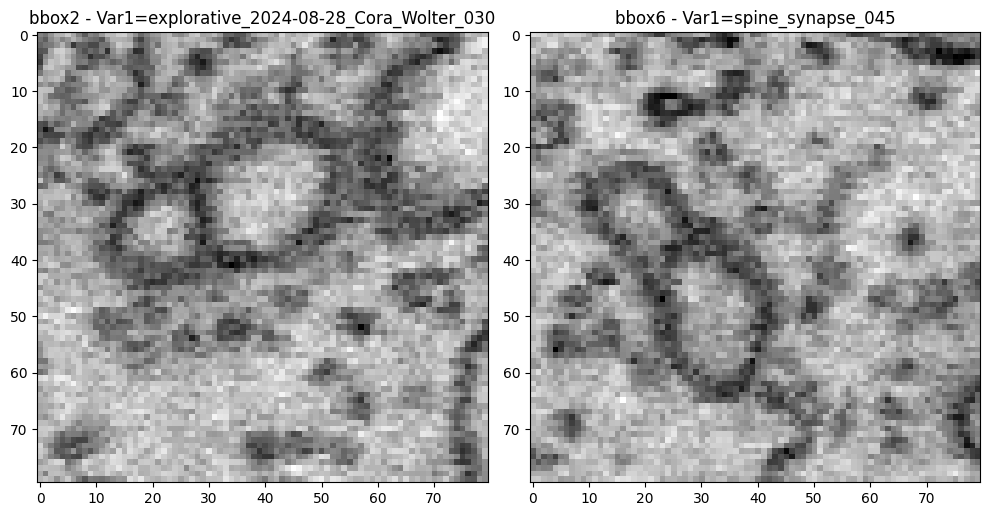


CHUNK 410 to 419, Dist = 0.058
  bbox2 -> Var1: explorative_2024-08-28_Cora_Wolter_024, (UMAP_3, UMAP_1) = (7.19, 6.59)
  bbox6 -> Var1: spine_synapse_006, (UMAP_3, UMAP_1) = (7.25, 6.57)


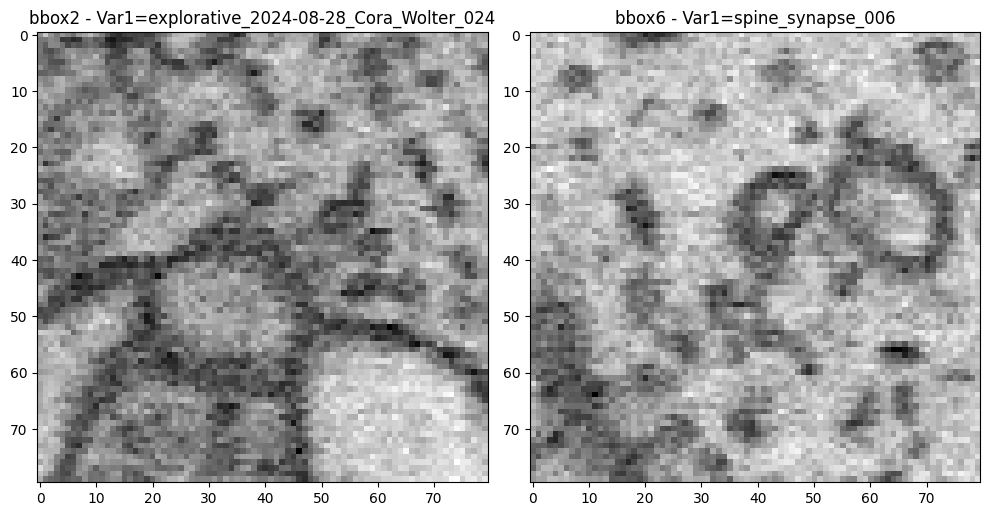


CHUNK 420 to 429, Dist = 0.283
  bbox2 -> Var1: explorative_2024-08-28_Cora_Wolter_036, (UMAP_3, UMAP_1) = (7.31, 10.43)
  bbox6 -> Var1: spine_synapse_044, (UMAP_3, UMAP_1) = (7.29, 10.14)


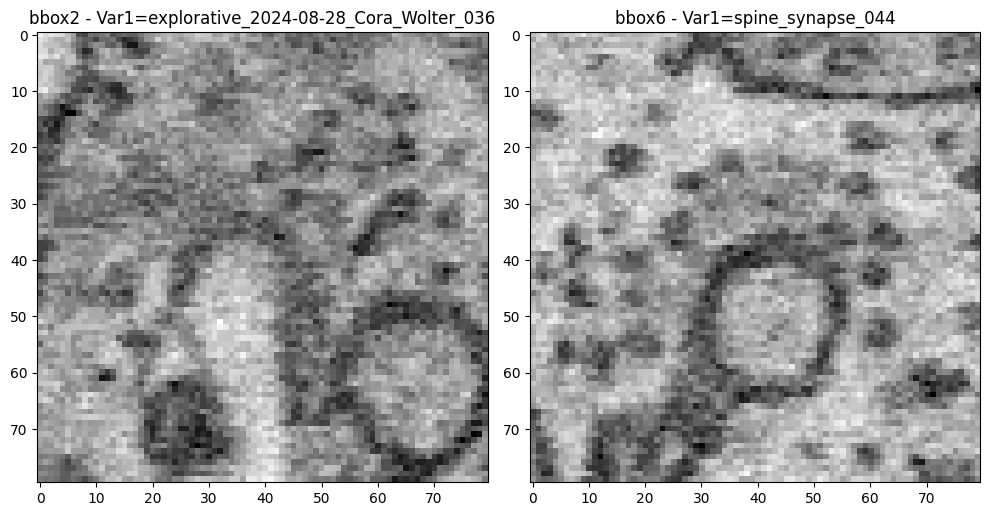


CHUNK 430 to 439, Dist = 0.424
  bbox2 -> Var1: explorative_2024-10-16_Valentin_Pinkau_116, (UMAP_3, UMAP_1) = (7.33, 10.05)
  bbox6 -> Var1: spine_synapse_030, (UMAP_3, UMAP_1) = (7.32, 10.47)


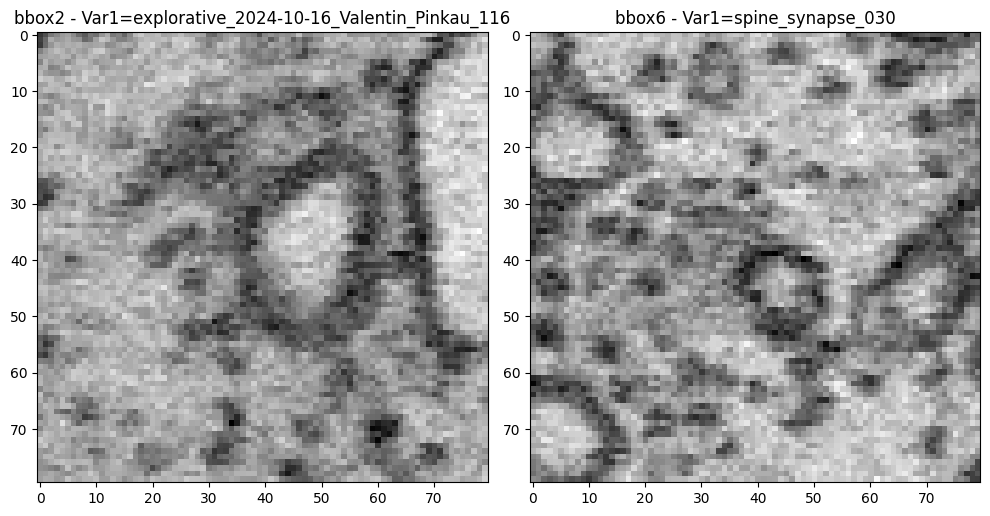


CHUNK 440 to 449, Dist = 0.127
  bbox2 -> Var1: explorative_2024-08-28_Cora_Wolter_015, (UMAP_3, UMAP_1) = (7.43, 7.44)
  bbox6 -> Var1: spine_synapse_049, (UMAP_3, UMAP_1) = (7.39, 7.56)


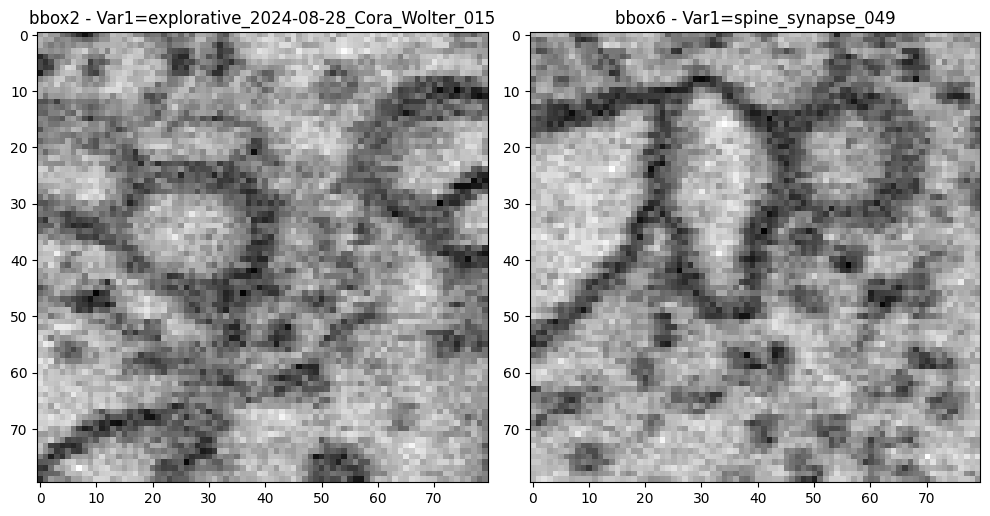


CHUNK 460 to 469, Dist = 0.098
  bbox2 -> Var1: explorative_2024-08-28_Cora_Wolter_004, (UMAP_3, UMAP_1) = (7.68, 11.22)
  bbox6 -> Var1: spine_synapse_028, (UMAP_3, UMAP_1) = (7.63, 11.13)


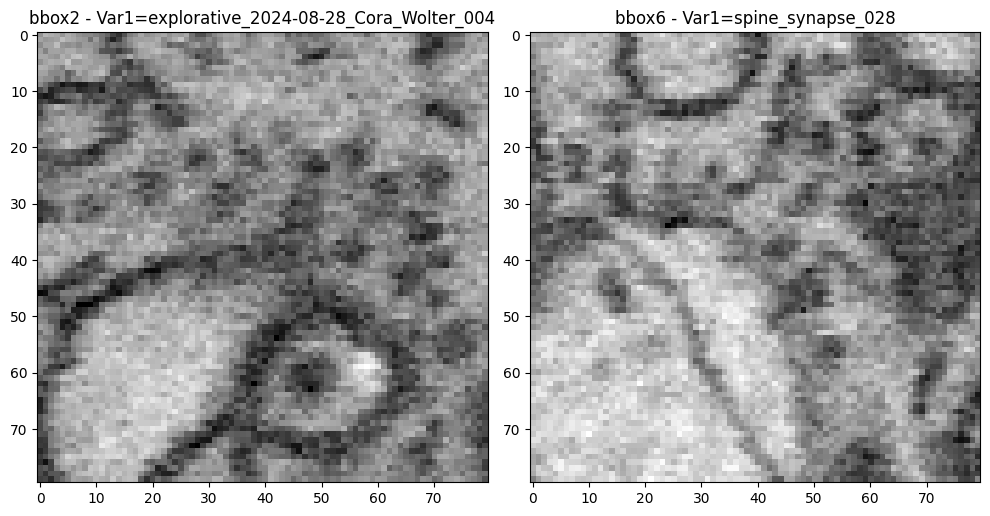


CHUNK 470 to 479, Dist = 0.436
  bbox2 -> Var1: explorative_2024-08-29_Vera_Broens_087, (UMAP_3, UMAP_1) = (7.80, 10.98)
  bbox6 -> Var1: spine_synapse_042, (UMAP_3, UMAP_1) = (7.73, 11.41)


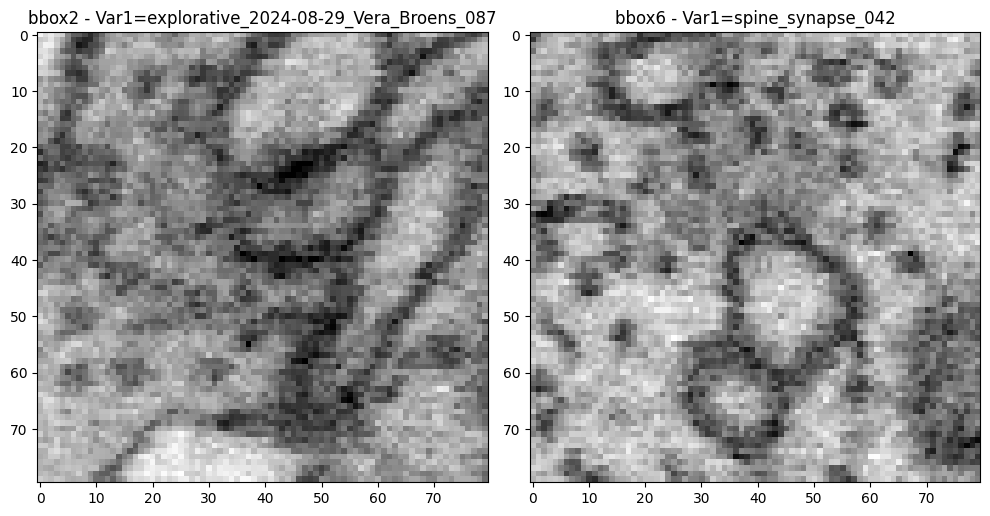

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_two_synapses(row_b2, row_b6, raw_base_dir):
    # Extract axial slices
    slice_b2 = extract_center_axial_slice(row_b2, raw_base_dir, subvol_size=80)
    slice_b6 = extract_center_axial_slice(row_b6, raw_base_dir, subvol_size=80)

    # Plot side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(slice_b2, cmap='gray')
    axes[0].set_title(f"{row_b2['bbox_name']} - Var1={row_b2['Var1']}")

    axes[1].imshow(slice_b6, cmap='gray')
    axes[1].set_title(f"{row_b6['bbox_name']} - Var1={row_b6['Var1']}")

    plt.tight_layout()
    plt.show()
import numpy as np
import torch
import imageio.v2 as iio
import matplotlib.pyplot as plt

def load_raw_volume(bbox_name, raw_base_dir):
    """
    Loads the raw volume for the given bounding box name from disk.
    """
    import glob, os
    raw_dir = os.path.join(raw_base_dir, bbox_name)
    raw_tif_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
    raw_slices = [iio.imread(f) for f in raw_tif_files]
    raw_vol = np.stack(raw_slices, axis=0)  # (Z, Y, X)
    return raw_vol

def extract_center_axial_slice(row, raw_base_dir, subvol_size=80):
    """
    Given a row of metadata (containing bbox_name, the coordinates, etc.),
    returns the center axial slice as a 2D NumPy array.
    """
    bbox_name = row['bbox_name']
    raw_vol = load_raw_volume(bbox_name, raw_base_dir)

    cx = int(row['central_coord_1'])  # X
    cy = int(row['central_coord_2'])  # Y
    cz = int(row['central_coord_3'])  # Z

    half_size = subvol_size // 2

    # Boundaries
    x_start = max(cx - half_size, 0)
    x_end = min(cx + half_size, raw_vol.shape[2])
    y_start = max(cy - half_size, 0)
    y_end = min(cy + half_size, raw_vol.shape[1])
    z_start = max(cz - half_size, 0)
    z_end = min(cz + half_size, raw_vol.shape[0])

    # Extract sub-volume
    sub_raw = raw_vol[z_start:z_end, y_start:y_end, x_start:x_end]

    # Pad if needed
    padded_sub = np.zeros((subvol_size, subvol_size, subvol_size), dtype=sub_raw.dtype)
    dz, dy, dx = sub_raw.shape
    padded_sub[:dz, :dy, :dx] = sub_raw

    # Axial slice (middle of Z dimension)
    axial_slice = padded_sub[subvol_size//2, :, :]
    return axial_slice

# Suppose you already have:
#   df_sorted (the DataFrame sorted by UMAP_3)
chunk_size =  10
#   raw_base_dir = "/content/raw"

for start_idx in range(0, len(df_sorted), chunk_size):
    chunk = df_sorted.iloc[start_idx : start_idx + chunk_size]

    chunk_bbox2 = chunk[chunk["bbox_name"] == "bbox2"]
    chunk_bbox6 = chunk[chunk["bbox_name"] == "bbox6"]

    if chunk_bbox2.empty or chunk_bbox6.empty:
        continue

    min_dist = float('inf')
    best_pair = None

    for _, row2 in chunk_bbox2.iterrows():
        for _, row6 in chunk_bbox6.iterrows():
            dist = np.sqrt(
                (row2["UMAP_3"] - row6["UMAP_3"])**2 +
                (row2["UMAP_1"] - row6["UMAP_1"])**2
            )
            if dist < min_dist:
                min_dist = dist
                best_pair = (row2, row6)

    if best_pair:
        row2, row6 = best_pair
        print(f"\nCHUNK {start_idx} to {start_idx + chunk_size - 1}, Dist = {min_dist:.3f}")
        print(f"  bbox2 -> Var1: {row2['Var1']}, (UMAP_3, UMAP_1) = ({row2['UMAP_3']:.2f}, {row2['UMAP_1']:.2f})")
        print(f"  bbox6 -> Var1: {row6['Var1']}, (UMAP_3, UMAP_1) = ({row6['UMAP_3']:.2f}, {row6['UMAP_1']:.2f})")

        # Plot the axial slice side by side
        plot_two_synapses(row2, row6, raw_base_dir=raw_base_dir)


# Just Vit

Removed VGG3D

No checkpoint downloading for VGG3D.
No references to model_vgg or model_vgg_feat.
No scalar features from sub_raw.mean(...) unless you decide to add them back.
Segmentation-Based Slice Extraction

We now create two “highlighted” slices (one for side1, one for side2).
Each slice is an RGB image:
Channel 0 = the raw sub-slice (grayscale).
Channel 1 = the mask for side1 (scaled by some factor so it stands out).
Channel 2 = the mask for side2 (scaled by some factor so it stands out).
You can tweak how you overlay raw + masks to “give more attention” to the side1/side2 regions.
ViT

We only compute ViT features from these two special slices (one for side1, one for side2). Then we average them to get a single feature vector per synapse.


ViT model loaded and in eval mode.

Processing bbox1...
Saved features to csv_outputs/bbox1_features.csv

Processing bbox2...
Saved features to csv_outputs/bbox2_features.csv

Processing bbox3...
Saved features to csv_outputs/bbox3_features.csv

Processing bbox4...
Saved features to csv_outputs/bbox4_features.csv

Processing bbox5...
Saved features to csv_outputs/bbox5_features.csv

Processing bbox6...
Saved features to csv_outputs/bbox6_features.csv

Processing bbox7...
Saved features to csv_outputs/bbox7_features.csv
Merged 7 CSVs into one DataFrame with 509 synapses total.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



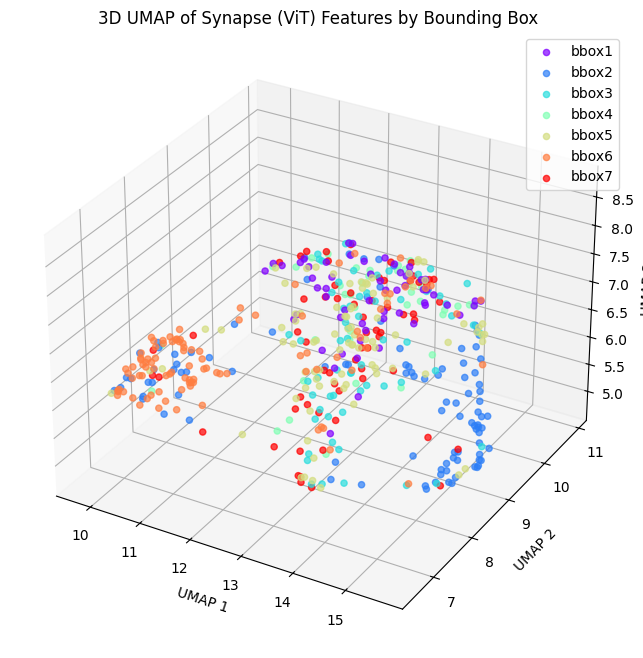

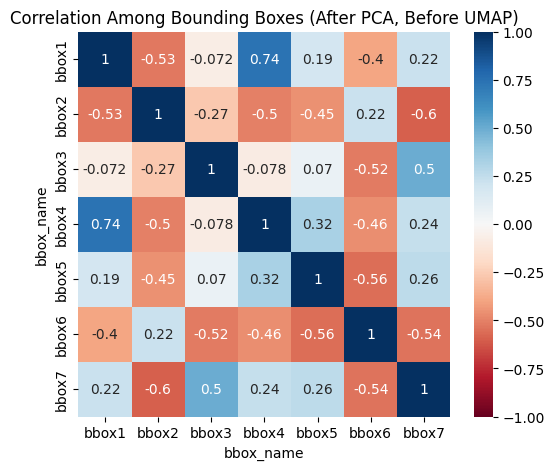

Done. All bounding boxes processed and features visualized.


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from transformers import ViTImageProcessor, ViTModel
import seaborn as sns
import umap
from PIL import Image
import imageio.v2 as iio
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import torch.nn.functional as F
import plotly.express as px

###############################################################################
# DIRECTORIES AND BBOX
###############################################################################
raw_base_dir = 'raw'
seg_base_dir = 'seg'
bbox_names = [f'bbox{i}' for i in range(1,8)]  # e.g. bbox1...bbox7

device = 'cuda' if torch.cuda.is_available() else 'cpu'

###############################################################################
# LOAD DATA
###############################################################################
def load_bbox_data(bbox_name, max_slices=None):
    """
    Loads raw and segmentation volumes.
    Returns raw_vol, seg_vol as (Z, Y, X) NumPy arrays.
    """
    raw_dir = os.path.join(raw_base_dir, bbox_name)
    seg_dir = os.path.join(seg_base_dir, bbox_name)

    raw_tif_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
    seg_tif_files = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))

    if max_slices is not None:
        raw_tif_files = raw_tif_files[:max_slices]
        seg_tif_files = seg_tif_files[:max_slices]

    assert len(raw_tif_files) == len(seg_tif_files), f"Raw/Seg mismatch in {bbox_name}"

    raw_slices = [iio.imread(f) for f in raw_tif_files]
    seg_slices = [iio.imread(f).astype(np.uint32) for f in seg_tif_files]

    raw_vol = np.stack(raw_slices, axis=0)  # (Z, Y, X)
    seg_vol = np.stack(seg_slices, axis=0)  # (Z, Y, X)
    return raw_vol, seg_vol

def create_segment_masks(seg_vol, side1_coord, side2_coord):
    """
    Returns boolean masks for side1 and side2 segments.
    """
    x1, y1, z1 = [int(c) for c in side1_coord]
    x2, y2, z2 = [int(c) for c in side2_coord]

    seg_id_1 = seg_vol[z1, y1, x1]
    seg_id_2 = seg_vol[z2, y2, x2]

    mask_1 = (seg_vol == seg_id_1) if seg_id_1 != 0 else np.zeros_like(seg_vol, dtype=bool)
    mask_2 = (seg_vol == seg_id_2) if seg_id_2 != 0 else np.zeros_like(seg_vol, dtype=bool)
    return mask_1, mask_2

###############################################################################
# DATASET
###############################################################################
class SynapseDataset(Dataset):
    def __init__(self, vol_data_list, synapse_df, subvol_size=80):
        """
        vol_data_list: list of (raw_vol, seg_vol) for each bbox.
        synapse_df: DataFrame with synapse coordinates + metadata.
        subvol_size: The cubic sub-volume size we extract around the synapse.
        """
        self.vol_data_list = vol_data_list
        self.synapse_df = synapse_df.reset_index(drop=True)
        self.subvol_size = subvol_size
        self.half_size = subvol_size // 2

    def __len__(self):
        return len(self.synapse_df)

    def __getitem__(self, idx):
        syn_info = self.synapse_df.iloc[idx]
        bbox_index = syn_info['bbox_index']  # which (raw_vol, seg_vol) pair
        raw_vol, seg_vol = self.vol_data_list[bbox_index]

        # coords
        cx, cy, cz = (
            int(syn_info['central_coord_1']),
            int(syn_info['central_coord_2']),
            int(syn_info['central_coord_3'])
        )
        side1_coord = (
            int(syn_info['side_1_coord_1']),
            int(syn_info['side_1_coord_2']),
            int(syn_info['side_1_coord_3'])
        )
        side2_coord = (
            int(syn_info['side_2_coord_1']),
            int(syn_info['side_2_coord_2']),
            int(syn_info['side_2_coord_3'])
        )

        # full masks for side1, side2
        mask_1_full, mask_2_full = create_segment_masks(seg_vol, side1_coord, side2_coord)

        # define sub-volume boundaries
        x_start = max(cx - self.half_size, 0)
        x_end   = min(cx + self.half_size, raw_vol.shape[2])
        y_start = max(cy - self.half_size, 0)
        y_end   = min(cy + self.half_size, raw_vol.shape[1])
        z_start = max(cz - self.half_size, 0)
        z_end   = min(cz + self.half_size, raw_vol.shape[0])

        # extract sub-volumes
        sub_raw = raw_vol[z_start:z_end, y_start:y_end, x_start:x_end]  # shape = (dz, dy, dx)
        sub_m1  = mask_1_full[z_start:z_end, y_start:y_end, x_start:x_end]
        sub_m2  = mask_2_full[z_start:z_end, y_start:y_end, x_start:x_end]

        # pad to subvol_size if near edges
        desired_shape = (self.subvol_size, self.subvol_size, self.subvol_size)
        padded_sub_raw = np.zeros(desired_shape, dtype=sub_raw.dtype)
        padded_sub_m1  = np.zeros(desired_shape, dtype=sub_m1.dtype)
        padded_sub_m2  = np.zeros(desired_shape, dtype=sub_m2.dtype)

        dz, dy, dx = sub_raw.shape
        padded_sub_raw[:dz, :dy, :dx] = sub_raw
        padded_sub_m1[:dz, :dy, :dx]  = sub_m1
        padded_sub_m2[:dz, :dy, :dx]  = sub_m2

        # ~~~~~~~~~~~~~~ NEW: EXTRACT TWO SPECIAL 2D SLICES FOR VIT ~~~~~~~~~~~~~~
        #  We'll do:
        #   slice_side1 = center axial slice, but highlight side1 in G channel
        #   slice_side2 = center axial slice, but highlight side2 in B channel
        # You can adapt or combine them differently if desired.

        mid_z = self.subvol_size // 2
        raw_slice = padded_sub_raw[mid_z, :, :]  # shape (subvol_size, subvol_size)
        m1_slice  = padded_sub_m1[mid_z, :, :]   # same shape, bool
        m2_slice  = padded_sub_m2[mid_z, :, :]   # same shape, bool

        # Convert each slice to 3-channel so that side1 or side2 is highlighted
        # e.g., raw in channel 0 (R), side1 in channel 1 (G), side2 in channel 2 (B).
        # We'll do separate images: one focusing on side1, one on side2.

        # 1) side1 slice
        side1_img = np.zeros((raw_slice.shape[0], raw_slice.shape[1], 3), dtype=np.uint8)
        # scaled raw in R
        side1_img[..., 0] = (raw_slice / raw_slice.max() * 255) if raw_slice.max() > 0 else raw_slice
        # side1 mask in G channel to highlight
        side1_img[..., 1] = m1_slice.astype(np.uint8) * 255

        # 2) side2 slice
        side2_img = np.zeros((raw_slice.shape[0], raw_slice.shape[1], 3), dtype=np.uint8)
        # scaled raw in R
        side2_img[..., 0] = (raw_slice / raw_slice.max() * 255) if raw_slice.max() > 0 else raw_slice
        # side2 mask in B channel to highlight
        side2_img[..., 2] = m2_slice.astype(np.uint8) * 255

        # Return them as plain NumPy arrays
        syn_info_dict = syn_info.to_dict()
        return side1_img, side2_img, syn_info_dict

###############################################################################
# LOAD & INIT VIT
###############################################################################
model_name = "google/vit-base-patch16-224-in21k"
image_processor = ViTImageProcessor.from_pretrained(model_name)
model_vit = ViTModel.from_pretrained(model_name).to(device)
model_vit.eval()
print("ViT model loaded and in eval mode.")

def get_vit_features_batch(rgb_images):
    """
    rgb_images: list of (H,W,3) uint8 NumPy arrays
    """
    pil_images = [Image.fromarray(img) for img in rgb_images]
    inputs = image_processor(images=pil_images, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model_vit(**inputs)
        feats = outputs.pooler_output.cpu().numpy()
    return feats

###############################################################################
# MAIN PIPELINE
###############################################################################
os.makedirs('csv_outputs', exist_ok=True)

all_csvs = []

for bbox_name in bbox_names:
    print(f"\nProcessing {bbox_name}...")

    # 1) Load volumes
    raw_vol, seg_vol = load_bbox_data(bbox_name)

    # 2) Load synapse metadata
    excel_file = f'{bbox_name}.xlsx'
    syn_df = pd.read_excel(excel_file)
    # Single bbox in the list => set index=0
    syn_df['bbox_index'] = 0
    syn_df['bbox_name'] = bbox_name

    # 3) Create dataset & loader
    vol_data_list = [(raw_vol, seg_vol)]
    dataset_bbox = SynapseDataset(vol_data_list, syn_df, subvol_size=80)
    dataloader_bbox = DataLoader(dataset_bbox, batch_size=16, shuffle=False, num_workers=2)

    bbox_features = []
    bbox_syn_info = []

    # 4) Extract features
    for batch_idx, batch_data in enumerate(dataloader_bbox):
        side1_imgs, side2_imgs, syn_infos = batch_data
        # side1_imgs/side2_imgs shape: (B, H, W, 3) as Torch Tensors.
        # Move them to CPU for processing as NumPy?
        side1_imgs_np = side1_imgs.numpy()
        side2_imgs_np = side2_imgs.numpy()

        # Flatten first dimension => list of images
        side1_list = [side1_imgs_np[i] for i in range(side1_imgs_np.shape[0])]
        side2_list = [side2_imgs_np[i] for i in range(side2_imgs_np.shape[0])]

        # Pass them through ViT
        vit_feats_side1 = get_vit_features_batch(side1_list)
        vit_feats_side2 = get_vit_features_batch(side2_list)

        # Average side1 & side2 features for final
        vit_feats = (vit_feats_side1 + vit_feats_side2) / 2.0

        # Convert syn_infos to DataFrame
        syn_infos_df = pd.DataFrame(syn_infos)

        bbox_features.append(vit_feats)
        bbox_syn_info.append(syn_infos_df)

    # 5) Concatenate features & metadata
    bbox_features = np.concatenate(bbox_features, axis=0)
    bbox_syn_info = pd.concat(bbox_syn_info, axis=0).reset_index(drop=True)

    # 6) Build DataFrame
    feature_cols = [f'vit_feat_{i}' for i in range(bbox_features.shape[1])]
    features_df = pd.DataFrame(bbox_features, columns=feature_cols)
    output_df = pd.concat([bbox_syn_info, features_df], axis=1)

    # 7) Save per-bbox CSV
    output_csv_name = f'csv_outputs/{bbox_name}_features.csv'
    output_df.to_csv(output_csv_name, index=False)
    print(f"Saved features to {output_csv_name}")
    all_csvs.append(output_csv_name)

###############################################################################
# MERGE CSVs + DIMENSIONALITY REDUCTION
###############################################################################
merged_df = pd.concat([pd.read_csv(csv) for csv in all_csvs], ignore_index=True)
print(f"Merged {len(all_csvs)} CSVs into one DataFrame with {len(merged_df)} synapses total.")

# select all columns that start with 'vit_feat_'
feature_cols = [c for c in merged_df.columns if c.startswith('vit_feat_')]
all_features = merged_df[feature_cols].values

# PCA -> reduce to 50 dims
scaler = StandardScaler()
all_features_scaled = scaler.fit_transform(all_features)

pca = PCA(n_components=50, random_state=42)
all_features_pca = pca.fit_transform(all_features_scaled)

# UMAP -> 3D
reducer = umap.UMAP(n_components=3, random_state=42)
embedding_3d = reducer.fit_transform(all_features_pca)

merged_df['UMAP_1'] = embedding_3d[:, 0]
merged_df['UMAP_2'] = embedding_3d[:, 1]
merged_df['UMAP_3'] = embedding_3d[:, 2]

###############################################################################
# VISUALIZE (MATPLOTLIB + PLOTLY)
###############################################################################
bbox_unique = merged_df['bbox_name'].unique()
colors = plt.cm.rainbow(np.linspace(0,1,len(bbox_unique)))
color_map = dict(zip(bbox_unique, colors))

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
for bbox in bbox_unique:
    subset = merged_df[merged_df['bbox_name'] == bbox]
    ax.scatter(subset['UMAP_1'], subset['UMAP_2'], subset['UMAP_3'],
               color=tuple(color_map[bbox]),
               label=bbox,
               alpha=0.7)

ax.set_title("3D UMAP of Synapse (ViT) Features by Bounding Box")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
ax.legend()
plt.show()
###############################################################################
# 1) Store the PCA components in merged_df
###############################################################################
# Suppose all_features_pca is shape [num_samples, 50] (your 50 principal components)
num_pca_components = all_features_pca.shape[1]

# Add them as columns to merged_df
for i in range(num_pca_components):
    merged_df[f'pca_{i+1}'] = all_features_pca[:, i]

###############################################################################
# 2) Aggregate the PCA components by bbox_name
###############################################################################
# Group by bounding box, then compute the mean of each pca_# column
pca_cols = [f'pca_{i+1}' for i in range(num_pca_components)]
bbox_feature_means_pca = merged_df.groupby('bbox_name')[pca_cols].mean()

###############################################################################
# 3) Compute the correlation matrix among bounding boxes
###############################################################################
# Transpose so bounding boxes become columns; .corr() yields (#bboxes x #bboxes).
bbox_corr_pca = bbox_feature_means_pca.T.corr()

###############################################################################
# 4) Visualize with Seaborn
###############################################################################
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(bbox_corr_pca, annot=True, cmap="RdBu", vmin=-1, vmax=1)
plt.title("Correlation Among Bounding Boxes (After PCA, Before UMAP)")
plt.show()

# PLOTLY 3D SCATTER
fig = px.scatter_3d(
    merged_df,
    x='UMAP_1',
    y='UMAP_2',
    z='UMAP_3',
    color='bbox_name',
    hover_data=['Var1']  # if your Excel has "Var1" column
)
fig.update_traces(marker=dict(size=3))
fig.show()

print("Done. All bounding boxes processed and features visualized.")


# Correlation finding

ViT model loaded and in eval mode.

Processing bbox1...
Saved features to csv_outputs/bbox1_features.csv

Processing bbox2...
Saved features to csv_outputs/bbox2_features.csv

Processing bbox3...
Saved features to csv_outputs/bbox3_features.csv

Processing bbox4...
Saved features to csv_outputs/bbox4_features.csv

Processing bbox5...
Saved features to csv_outputs/bbox5_features.csv

Processing bbox6...
Saved features to csv_outputs/bbox6_features.csv

Processing bbox7...
Saved features to csv_outputs/bbox7_features.csv
Merged 7 CSVs into one DataFrame with 509 synapses total.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



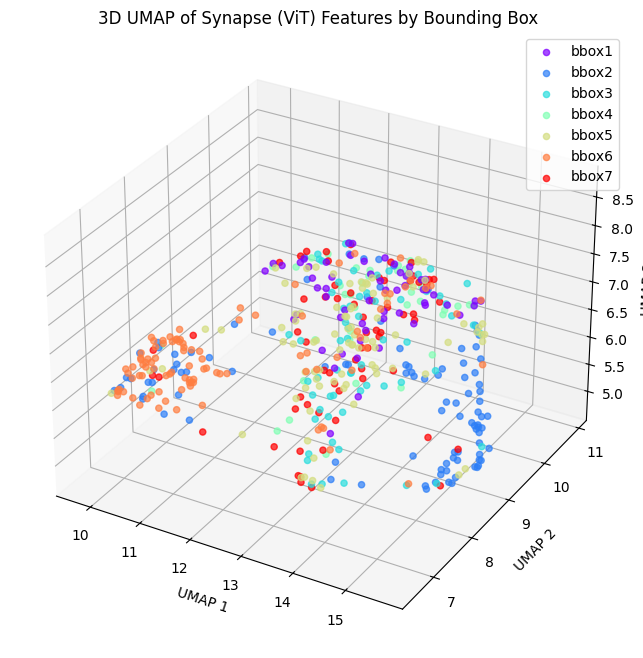

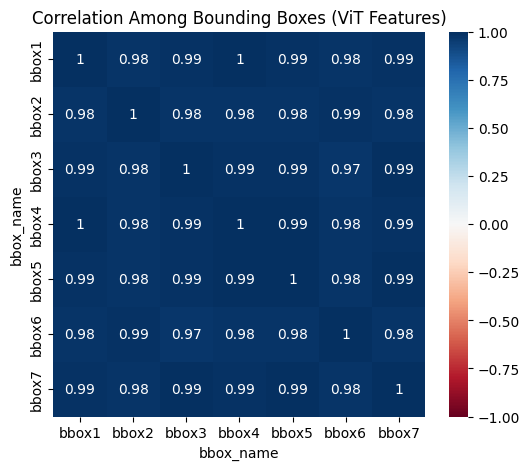

Done. Full pipeline + bounding box correlation matrix completed.


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from transformers import ViTImageProcessor, ViTModel
import seaborn as sns
import umap
from PIL import Image
import imageio.v2 as iio
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import torch.nn.functional as F
import plotly.express as px

###############################################################################
# DIRECTORIES AND BBOX
###############################################################################
raw_base_dir = 'raw'
seg_base_dir = 'seg'
bbox_names = [f'bbox{i}' for i in range(1,8)]  # e.g. bbox1...bbox7

device = 'cuda' if torch.cuda.is_available() else 'cpu'

###############################################################################
# LOAD DATA
###############################################################################
def load_bbox_data(bbox_name, max_slices=None):
    """
    Loads raw and segmentation volumes.
    Returns raw_vol, seg_vol as (Z, Y, X) NumPy arrays.
    """
    raw_dir = os.path.join(raw_base_dir, bbox_name)
    seg_dir = os.path.join(seg_base_dir, bbox_name)

    raw_tif_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
    seg_tif_files = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))

    if max_slices is not None:
        raw_tif_files = raw_tif_files[:max_slices]
        seg_tif_files = seg_tif_files[:max_slices]

    assert len(raw_tif_files) == len(seg_tif_files), f"Raw/Seg mismatch in {bbox_name}"

    raw_slices = [iio.imread(f) for f in raw_tif_files]
    seg_slices = [iio.imread(f).astype(np.uint32) for f in seg_tif_files]

    raw_vol = np.stack(raw_slices, axis=0)  # (Z, Y, X)
    seg_vol = np.stack(seg_slices, axis=0)  # (Z, Y, X)
    return raw_vol, seg_vol


def create_segment_masks(seg_vol, side1_coord, side2_coord):
    """
    Returns boolean masks for side1 and side2 segments.
    """
    x1, y1, z1 = [int(c) for c in side1_coord]
    x2, y2, z2 = [int(c) for c in side2_coord]

    seg_id_1 = seg_vol[z1, y1, x1]
    seg_id_2 = seg_vol[z2, y2, x2]

    mask_1 = (seg_vol == seg_id_1) if seg_id_1 != 0 else np.zeros_like(seg_vol, dtype=bool)
    mask_2 = (seg_vol == seg_id_2) if seg_id_2 != 0 else np.zeros_like(seg_vol, dtype=bool)
    return mask_1, mask_2

###############################################################################
# DATASET
###############################################################################
class SynapseDataset(Dataset):
    def __init__(self, vol_data_list, synapse_df, subvol_size=80):
        """
        vol_data_list: list of (raw_vol, seg_vol) for each bbox.
        synapse_df: DataFrame with synapse coordinates + metadata.
        subvol_size: The cubic sub-volume size we extract around the synapse.
        """
        self.vol_data_list = vol_data_list
        self.synapse_df = synapse_df.reset_index(drop=True)
        self.subvol_size = subvol_size
        self.half_size = subvol_size // 2

    def __len__(self):
        return len(self.synapse_df)

    def __getitem__(self, idx):
        syn_info = self.synapse_df.iloc[idx]
        bbox_index = syn_info['bbox_index']  # which (raw_vol, seg_vol) pair
        raw_vol, seg_vol = self.vol_data_list[bbox_index]

        # coords
        cx, cy, cz = (
            int(syn_info['central_coord_1']),
            int(syn_info['central_coord_2']),
            int(syn_info['central_coord_3'])
        )
        side1_coord = (
            int(syn_info['side_1_coord_1']),
            int(syn_info['side_1_coord_2']),
            int(syn_info['side_1_coord_3'])
        )
        side2_coord = (
            int(syn_info['side_2_coord_1']),
            int(syn_info['side_2_coord_2']),
            int(syn_info['side_2_coord_3'])
        )

        # full masks for side1, side2
        mask_1_full, mask_2_full = create_segment_masks(seg_vol, side1_coord, side2_coord)

        # define sub-volume boundaries
        x_start = max(cx - self.half_size, 0)
        x_end   = min(cx + self.half_size, raw_vol.shape[2])
        y_start = max(cy - self.half_size, 0)
        y_end   = min(cy + self.half_size, raw_vol.shape[1])
        z_start = max(cz - self.half_size, 0)
        z_end   = min(cz + self.half_size, raw_vol.shape[0])

        # extract sub-volumes
        sub_raw = raw_vol[z_start:z_end, y_start:y_end, x_start:x_end]  # shape = (dz, dy, dx)
        sub_m1  = mask_1_full[z_start:z_end, y_start:y_end, x_start:x_end]
        sub_m2  = mask_2_full[z_start:z_end, y_start:y_end, x_start:x_end]

        # pad to subvol_size if near edges
        desired_shape = (self.subvol_size, self.subvol_size, self.subvol_size)
        padded_sub_raw = np.zeros(desired_shape, dtype=sub_raw.dtype)
        padded_sub_m1  = np.zeros(desired_shape, dtype=sub_m1.dtype)
        padded_sub_m2  = np.zeros(desired_shape, dtype=sub_m2.dtype)

        dz, dy, dx = sub_raw.shape
        padded_sub_raw[:dz, :dy, :dx] = sub_raw
        padded_sub_m1[:dz, :dy, :dx]  = sub_m1
        padded_sub_m2[:dz, :dy, :dx]  = sub_m2

        # ~~~~~~~~~~~~~~ EXTRACT TWO SPECIAL 2D SLICES FOR VIT ~~~~~~~~~~~~~~
        mid_z = self.subvol_size // 2
        raw_slice = padded_sub_raw[mid_z, :, :]  # shape (subvol_size, subvol_size)
        m1_slice  = padded_sub_m1[mid_z, :, :]   # same shape, bool
        m2_slice  = padded_sub_m2[mid_z, :, :]   # same shape, bool

        # Convert each slice to 3-channel so that side1 or side2 is highlighted
        # We'll do separate images: one focusing on side1, one on side2.

        # 1) side1 slice
        side1_img = np.zeros((raw_slice.shape[0], raw_slice.shape[1], 3), dtype=np.uint8)
        # scaled raw in R
        side1_img[..., 0] = (raw_slice / raw_slice.max() * 255) if raw_slice.max() > 0 else raw_slice
        # side1 mask in G channel to highlight
        side1_img[..., 1] = m1_slice.astype(np.uint8) * 255

        # 2) side2 slice
        side2_img = np.zeros((raw_slice.shape[0], raw_slice.shape[1], 3), dtype=np.uint8)
        # scaled raw in R
        side2_img[..., 0] = (raw_slice / raw_slice.max() * 255) if raw_slice.max() > 0 else raw_slice
        # side2 mask in B channel to highlight
        side2_img[..., 2] = m2_slice.astype(np.uint8) * 255

        # Return them as plain NumPy arrays
        syn_info_dict = syn_info.to_dict()
        return side1_img, side2_img, syn_info_dict


###############################################################################
# LOAD & INIT VIT
###############################################################################
model_name = "google/vit-base-patch16-224-in21k"
image_processor = ViTImageProcessor.from_pretrained(model_name)
model_vit = ViTModel.from_pretrained(model_name).to(device)
model_vit.eval()
print("ViT model loaded and in eval mode.")


def get_vit_features_batch(rgb_images):
    """
    rgb_images: list of (H,W,3) uint8 NumPy arrays
    """
    pil_images = [Image.fromarray(img) for img in rgb_images]
    inputs = image_processor(images=pil_images, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model_vit(**inputs)
        feats = outputs.pooler_output.cpu().numpy()
    return feats

###############################################################################
# MAIN PIPELINE
###############################################################################
os.makedirs('csv_outputs', exist_ok=True)

all_csvs = []

for bbox_name in bbox_names:
    print(f"\nProcessing {bbox_name}...")

    # 1) Load volumes
    raw_vol, seg_vol = load_bbox_data(bbox_name)

    # 2) Load synapse metadata
    excel_file = f'{bbox_name}.xlsx'
    syn_df = pd.read_excel(excel_file)
    # Single bbox in the list => set index=0
    syn_df['bbox_index'] = 0
    syn_df['bbox_name'] = bbox_name

    # 3) Create dataset & loader
    vol_data_list = [(raw_vol, seg_vol)]
    dataset_bbox = SynapseDataset(vol_data_list, syn_df, subvol_size=80)
    dataloader_bbox = DataLoader(dataset_bbox, batch_size=16, shuffle=False, num_workers=2)

    bbox_features = []
    bbox_syn_info = []

    # 4) Extract features
    for batch_idx, batch_data in enumerate(dataloader_bbox):
        side1_imgs, side2_imgs, syn_infos = batch_data
        # side1_imgs / side2_imgs shape: (B, H, W, 3) as Torch Tensors.
        # Move them to CPU for processing as NumPy
        side1_imgs_np = side1_imgs.numpy()
        side2_imgs_np = side2_imgs.numpy()

        # Flatten first dimension => list of images
        side1_list = [side1_imgs_np[i] for i in range(side1_imgs_np.shape[0])]
        side2_list = [side2_imgs_np[i] for i in range(side2_imgs_np.shape[0])]

        # Pass them through ViT
        vit_feats_side1 = get_vit_features_batch(side1_list)
        vit_feats_side2 = get_vit_features_batch(side2_list)

        # Average side1 & side2 features for final
        vit_feats = (vit_feats_side1 + vit_feats_side2) / 2.0

        # Convert syn_infos to DataFrame
        syn_infos_df = pd.DataFrame(syn_infos)

        bbox_features.append(vit_feats)
        bbox_syn_info.append(syn_infos_df)

    # 5) Concatenate features & metadata
    bbox_features = np.concatenate(bbox_features, axis=0)
    bbox_syn_info = pd.concat(bbox_syn_info, axis=0).reset_index(drop=True)

    # 6) Build DataFrame
    feature_cols = [f'vit_feat_{i}' for i in range(bbox_features.shape[1])]
    features_df = pd.DataFrame(bbox_features, columns=feature_cols)
    output_df = pd.concat([bbox_syn_info, features_df], axis=1)

    # 7) Save per-bbox CSV
    output_csv_name = f'csv_outputs/{bbox_name}_features.csv'
    output_df.to_csv(output_csv_name, index=False)
    print(f"Saved features to {output_csv_name}")
    all_csvs.append(output_csv_name)

###############################################################################
# MERGE CSVs + DIMENSIONALITY REDUCTION
###############################################################################
merged_df = pd.concat([pd.read_csv(csv) for csv in all_csvs], ignore_index=True)
print(f"Merged {len(all_csvs)} CSVs into one DataFrame with {len(merged_df)} synapses total.")

# select all columns that start with 'vit_feat_'
feature_cols = [c for c in merged_df.columns if c.startswith('vit_feat_')]
all_features = merged_df[feature_cols].values

# PCA -> reduce to 50 dims
scaler = StandardScaler()
all_features_scaled = scaler.fit_transform(all_features)

pca = PCA(n_components=50, random_state=42)
all_features_pca = pca.fit_transform(all_features_scaled)

# UMAP -> 3D
reducer = umap.UMAP(n_components=3, random_state=42)
embedding_3d = reducer.fit_transform(all_features_pca)

merged_df['UMAP_1'] = embedding_3d[:, 0]
merged_df['UMAP_2'] = embedding_3d[:, 1]
merged_df['UMAP_3'] = embedding_3d[:, 2]

###############################################################################
# VISUALIZE (MATPLOTLIB + PLOTLY)
###############################################################################
bbox_unique = merged_df['bbox_name'].unique()
colors = plt.cm.rainbow(np.linspace(0,1,len(bbox_unique)))
color_map = dict(zip(bbox_unique, colors))

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
for bbox in bbox_unique:
    subset = merged_df[merged_df['bbox_name'] == bbox]
    ax.scatter(subset['UMAP_1'], subset['UMAP_2'], subset['UMAP_3'],
               color=tuple(color_map[bbox]),
               label=bbox,
               alpha=0.7)

ax.set_title("3D UMAP of Synapse (ViT) Features by Bounding Box")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
ax.legend()
plt.show()

# PLOTLY 3D SCATTER
fig = px.scatter_3d(
    merged_df,
    x='UMAP_1',
    y='UMAP_2',
    z='UMAP_3',
    color='bbox_name',
    hover_data=['Var1']  # if your Excel has "Var1" column
)
fig.update_traces(marker=dict(size=3))
fig.show()

###############################################################################
# CORRELATION MATRIX AMONG BOUNDING BOXES
###############################################################################
# 1) Group by bbox_name and compute the mean of all feature columns
bbox_feature_means = merged_df.groupby('bbox_name')[feature_cols].mean()

# 2) Compute correlation among bounding boxes
#    After transposing, each bounding box becomes a column,
#    so .corr() yields a (#bboxes x #bboxes) correlation matrix
bbox_corr = bbox_feature_means.T.corr()

# 3) Visualize correlation matrix via Seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(bbox_corr, annot=True, cmap="RdBu", vmin=-1, vmax=1)
plt.title("Correlation Among Bounding Boxes (ViT Features)")
plt.show()

print("Done. Full pipeline + bounding box correlation matrix completed.")


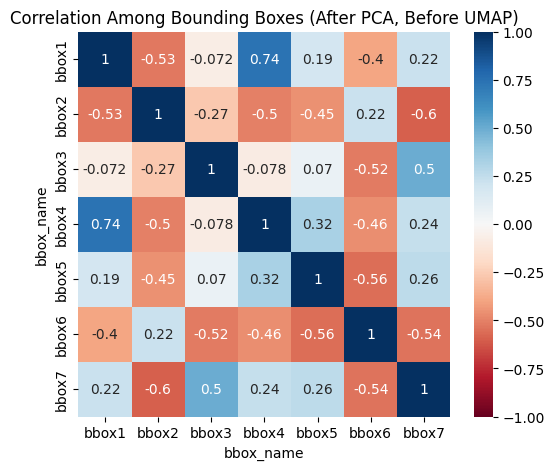

In [ ]:
###############################################################################
# 1) Store the PCA components in merged_df
###############################################################################
# Suppose all_features_pca is shape [num_samples, 50] (your 50 principal components)
num_pca_components = all_features_pca.shape[1]

# Add them as columns to merged_df
for i in range(num_pca_components):
    merged_df[f'pca_{i+1}'] = all_features_pca[:, i]

###############################################################################
# 2) Aggregate the PCA components by bbox_name
###############################################################################
# Group by bounding box, then compute the mean of each pca_# column
pca_cols = [f'pca_{i+1}' for i in range(num_pca_components)]
bbox_feature_means_pca = merged_df.groupby('bbox_name')[pca_cols].mean()

###############################################################################
# 3) Compute the correlation matrix among bounding boxes
###############################################################################
# Transpose so bounding boxes become columns; .corr() yields (#bboxes x #bboxes).
bbox_corr_pca = bbox_feature_means_pca.T.corr()

###############################################################################
# 4) Visualize with Seaborn
###############################################################################
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(bbox_corr_pca, annot=True, cmap="RdBu", vmin=-1, vmax=1)
plt.title("Correlation Among Bounding Boxes (After PCA, Before UMAP)")
plt.show()


# Just vit with 100 pca

ViT model loaded and in eval mode.

Processing bbox1...
Saved features to csv_outputs/bbox1_features.csv

Processing bbox2...
Saved features to csv_outputs/bbox2_features.csv

Processing bbox3...
Saved features to csv_outputs/bbox3_features.csv

Processing bbox4...
Saved features to csv_outputs/bbox4_features.csv

Processing bbox5...
Saved features to csv_outputs/bbox5_features.csv

Processing bbox6...
Saved features to csv_outputs/bbox6_features.csv

Processing bbox7...
Saved features to csv_outputs/bbox7_features.csv
Merged 7 CSVs into one DataFrame with 509 synapses total.


<ipython-input-9-e5724f4f6ed2>:280: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-9-e5724f4f6ed2>:280: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-9-e5724f4f6ed2>:280: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-9-e5724f4f6ed2>:280: PerformanceWarning:

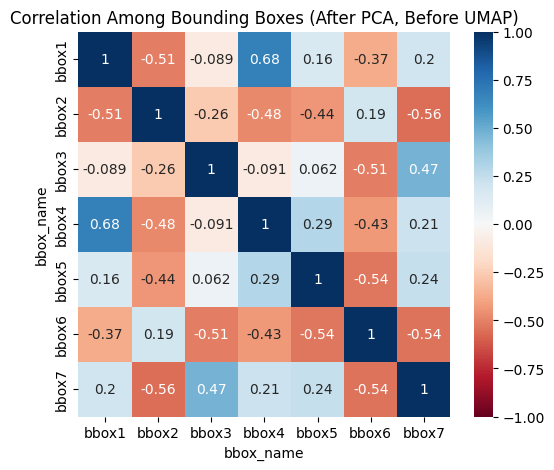

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from transformers import ViTImageProcessor, ViTModel
import seaborn as sns
import umap
from PIL import Image
import imageio.v2 as iio
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import torch.nn.functional as F
import plotly.express as px

###############################################################################
# DIRECTORIES AND BBOX
###############################################################################
raw_base_dir = 'raw'
seg_base_dir = 'seg'
bbox_names = [f'bbox{i}' for i in range(1,8)]  # e.g. bbox1...bbox7

device = 'cuda' if torch.cuda.is_available() else 'cpu'

###############################################################################
# LOAD DATA
###############################################################################
def load_bbox_data(bbox_name, max_slices=None):
    """
    Loads raw and segmentation volumes.
    Returns raw_vol, seg_vol as (Z, Y, X) NumPy arrays.
    """
    raw_dir = os.path.join(raw_base_dir, bbox_name)
    seg_dir = os.path.join(seg_base_dir, bbox_name)

    raw_tif_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
    seg_tif_files = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))

    if max_slices is not None:
        raw_tif_files = raw_tif_files[:max_slices]
        seg_tif_files = seg_tif_files[:max_slices]

    assert len(raw_tif_files) == len(seg_tif_files), f"Raw/Seg mismatch in {bbox_name}"

    raw_slices = [iio.imread(f) for f in raw_tif_files]
    seg_slices = [iio.imread(f).astype(np.uint32) for f in seg_tif_files]

    raw_vol = np.stack(raw_slices, axis=0)  # (Z, Y, X)
    seg_vol = np.stack(seg_slices, axis=0)  # (Z, Y, X)
    return raw_vol, seg_vol


def create_segment_masks(seg_vol, side1_coord, side2_coord):
    """
    Returns boolean masks for side1 and side2 segments.
    """
    x1, y1, z1 = [int(c) for c in side1_coord]
    x2, y2, z2 = [int(c) for c in side2_coord]

    seg_id_1 = seg_vol[z1, y1, x1]
    seg_id_2 = seg_vol[z2, y2, x2]

    mask_1 = (seg_vol == seg_id_1) if seg_id_1 != 0 else np.zeros_like(seg_vol, dtype=bool)
    mask_2 = (seg_vol == seg_id_2) if seg_id_2 != 0 else np.zeros_like(seg_vol, dtype=bool)
    return mask_1, mask_2

###############################################################################
# DATASET
###############################################################################
class SynapseDataset(Dataset):
    def __init__(self, vol_data_list, synapse_df, subvol_size=80):
        """
        vol_data_list: list of (raw_vol, seg_vol) for each bbox.
        synapse_df: DataFrame with synapse coordinates + metadata.
        subvol_size: The cubic sub-volume size we extract around the synapse.
        """
        self.vol_data_list = vol_data_list
        self.synapse_df = synapse_df.reset_index(drop=True)
        self.subvol_size = subvol_size
        self.half_size = subvol_size // 2

    def __len__(self):
        return len(self.synapse_df)

    def __getitem__(self, idx):
        syn_info = self.synapse_df.iloc[idx]
        bbox_index = syn_info['bbox_index']  # which (raw_vol, seg_vol) pair
        raw_vol, seg_vol = self.vol_data_list[bbox_index]

        # coords
        cx, cy, cz = (
            int(syn_info['central_coord_1']),
            int(syn_info['central_coord_2']),
            int(syn_info['central_coord_3'])
        )
        side1_coord = (
            int(syn_info['side_1_coord_1']),
            int(syn_info['side_1_coord_2']),
            int(syn_info['side_1_coord_3'])
        )
        side2_coord = (
            int(syn_info['side_2_coord_1']),
            int(syn_info['side_2_coord_2']),
            int(syn_info['side_2_coord_3'])
        )

        # full masks for side1, side2
        mask_1_full, mask_2_full = create_segment_masks(seg_vol, side1_coord, side2_coord)

        # define sub-volume boundaries
        x_start = max(cx - self.half_size, 0)
        x_end   = min(cx + self.half_size, raw_vol.shape[2])
        y_start = max(cy - self.half_size, 0)
        y_end   = min(cy + self.half_size, raw_vol.shape[1])
        z_start = max(cz - self.half_size, 0)
        z_end   = min(cz + self.half_size, raw_vol.shape[0])

        # extract sub-volumes
        sub_raw = raw_vol[z_start:z_end, y_start:y_end, x_start:x_end]  # shape = (dz, dy, dx)
        sub_m1  = mask_1_full[z_start:z_end, y_start:y_end, x_start:x_end]
        sub_m2  = mask_2_full[z_start:z_end, y_start:y_end, x_start:x_end]

        # pad to subvol_size if near edges
        desired_shape = (self.subvol_size, self.subvol_size, self.subvol_size)
        padded_sub_raw = np.zeros(desired_shape, dtype=sub_raw.dtype)
        padded_sub_m1  = np.zeros(desired_shape, dtype=sub_m1.dtype)
        padded_sub_m2  = np.zeros(desired_shape, dtype=sub_m2.dtype)

        dz, dy, dx = sub_raw.shape
        padded_sub_raw[:dz, :dy, :dx] = sub_raw
        padded_sub_m1[:dz, :dy, :dx]  = sub_m1
        padded_sub_m2[:dz, :dy, :dx]  = sub_m2

        # ~~~~~~~~~~~~~~ EXTRACT TWO SPECIAL 2D SLICES FOR VIT ~~~~~~~~~~~~~~
        mid_z = self.subvol_size // 2
        raw_slice = padded_sub_raw[mid_z, :, :]  # shape (subvol_size, subvol_size)
        m1_slice  = padded_sub_m1[mid_z, :, :]   # same shape, bool
        m2_slice  = padded_sub_m2[mid_z, :, :]   # same shape, bool

        # Convert each slice to 3-channel so that side1 or side2 is highlighted
        # We'll do separate images: one focusing on side1, one on side2.

        # 1) side1 slice
        side1_img = np.zeros((raw_slice.shape[0], raw_slice.shape[1], 3), dtype=np.uint8)
        # scaled raw in R
        side1_img[..., 0] = (raw_slice / raw_slice.max() * 255) if raw_slice.max() > 0 else raw_slice
        # side1 mask in G channel to highlight
        side1_img[..., 1] = m1_slice.astype(np.uint8) * 255

        # 2) side2 slice
        side2_img = np.zeros((raw_slice.shape[0], raw_slice.shape[1], 3), dtype=np.uint8)
        # scaled raw in R
        side2_img[..., 0] = (raw_slice / raw_slice.max() * 255) if raw_slice.max() > 0 else raw_slice
        # side2 mask in B channel to highlight
        side2_img[..., 2] = m2_slice.astype(np.uint8) * 255

        # Return them as plain NumPy arrays
        syn_info_dict = syn_info.to_dict()
        return side1_img, side2_img, syn_info_dict


###############################################################################
# LOAD & INIT VIT
###############################################################################
model_name = "google/vit-base-patch16-224-in21k"
image_processor = ViTImageProcessor.from_pretrained(model_name)
model_vit = ViTModel.from_pretrained(model_name).to(device)
model_vit.eval()
print("ViT model loaded and in eval mode.")


def get_vit_features_batch(rgb_images):
    """
    rgb_images: list of (H,W,3) uint8 NumPy arrays
    """
    pil_images = [Image.fromarray(img) for img in rgb_images]
    inputs = image_processor(images=pil_images, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model_vit(**inputs)
        feats = outputs.pooler_output.cpu().numpy()
    return feats

###############################################################################
# MAIN PIPELINE
###############################################################################
os.makedirs('csv_outputs', exist_ok=True)

all_csvs = []

for bbox_name in bbox_names:
    print(f"\nProcessing {bbox_name}...")

    # 1) Load volumes
    raw_vol, seg_vol = load_bbox_data(bbox_name)

    # 2) Load synapse metadata
    excel_file = f'{bbox_name}.xlsx'
    syn_df = pd.read_excel(excel_file)
    # Single bbox in the list => set index=0
    syn_df['bbox_index'] = 0
    syn_df['bbox_name'] = bbox_name

    # 3) Create dataset & loader
    vol_data_list = [(raw_vol, seg_vol)]
    dataset_bbox = SynapseDataset(vol_data_list, syn_df, subvol_size=80)
    dataloader_bbox = DataLoader(dataset_bbox, batch_size=16, shuffle=False, num_workers=2)

    bbox_features = []
    bbox_syn_info = []

    # 4) Extract features
    for batch_idx, batch_data in enumerate(dataloader_bbox):
        side1_imgs, side2_imgs, syn_infos = batch_data
        # side1_imgs / side2_imgs shape: (B, H, W, 3) as Torch Tensors.
        # Move them to CPU for processing as NumPy
        side1_imgs_np = side1_imgs.numpy()
        side2_imgs_np = side2_imgs.numpy()

        # Flatten first dimension => list of images
        side1_list = [side1_imgs_np[i] for i in range(side1_imgs_np.shape[0])]
        side2_list = [side2_imgs_np[i] for i in range(side2_imgs_np.shape[0])]

        # Pass them through ViT
        vit_feats_side1 = get_vit_features_batch(side1_list)
        vit_feats_side2 = get_vit_features_batch(side2_list)

        # Average side1 & side2 features for final
        vit_feats = (vit_feats_side1 + vit_feats_side2) / 2.0

        # Convert syn_infos to DataFrame
        syn_infos_df = pd.DataFrame(syn_infos)

        bbox_features.append(vit_feats)
        bbox_syn_info.append(syn_infos_df)

    # 5) Concatenate features & metadata
    bbox_features = np.concatenate(bbox_features, axis=0)
    bbox_syn_info = pd.concat(bbox_syn_info, axis=0).reset_index(drop=True)

    # 6) Build DataFrame
    feature_cols = [f'vit_feat_{i}' for i in range(bbox_features.shape[1])]
    features_df = pd.DataFrame(bbox_features, columns=feature_cols)
    output_df = pd.concat([bbox_syn_info, features_df], axis=1)

    # 7) Save per-bbox CSV
    output_csv_name = f'csv_outputs/{bbox_name}_features.csv'
    output_df.to_csv(output_csv_name, index=False)
    print(f"Saved features to {output_csv_name}")
    all_csvs.append(output_csv_name)

# # UMAP -> 3D
# reducer = umap.UMAP(n_components=3, random_state=42)
# embedding_3d = reducer.fit_transform(all_features_pca)

# merged_df['UMAP_1'] = embedding_3d[:, 0]
# merged_df['UMAP_2'] = embedding_3d[:, 1]
# merged_df['UMAP_3'] = embedding_3d[:, 2]

# ###############################################################################
# # VISUALIZE (MATPLOTLIB + PLOTLY)
# ###############################################################################
# bbox_unique = merged_df['bbox_name'].unique()
# colors = plt.cm.rainbow(np.linspace(0,1,len(bbox_unique)))
# color_map = dict(zip(bbox_unique, colors))

# fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot(111, projection='3d')
# for bbox in bbox_unique:
#     subset = merged_df[merged_df['bbox_name'] == bbox]
#     ax.scatter(subset['UMAP_1'], subset['UMAP_2'], subset['UMAP_3'],
#                color=tuple(color_map[bbox]),
#                label=bbox,
#                alpha=0.7)

# ax.set_title("3D UMAP of Synapse (ViT) Features by Bounding Box")
# ax.set_xlabel("UMAP 1")
# ax.set_ylabel("UMAP 2")
# ax.set_zlabel("UMAP 3")
# ax.legend()
# plt.show()

# # PLOTLY 3D SCATTER
# fig = px.scatter_3d(
#     merged_df,
#     x='UMAP_1',
#     y='UMAP_2',
#     z='UMAP_3',
#     color='bbox_name',
#     hover_data=['Var1']  # if your Excel has "Var1" column
# )
# fig.update_traces(marker=dict(size=3))
# fig.show()

# ###############################################################################
# # CORRELATION MATRIX AMONG BOUNDING BOXES
# ###############################################################################
# # 1) Group by bbox_name and compute the mean of all feature columns
# bbox_feature_means = merged_df.groupby('bbox_name')[feature_cols].mean()

# # 2) Compute correlation among bounding boxes
# #    After transposing, each bounding box becomes a column,
# #    so .corr() yields a (#bboxes x #bboxes) correlation matrix
# bbox_corr = bbox_feature_means.T.corr()

# # 3) Visualize correlation matrix via Seaborn heatmap
# plt.figure(figsize=(6, 5))
# sns.heatmap(bbox_corr, annot=True, cmap="RdBu", vmin=-1, vmax=1)
# plt.title("Correlation Among Bounding Boxes (ViT Features)")
# plt.show()

# print("Done. Full pipeline + bounding box correlation matrix completed.")


<ipython-input-13-fbc9463e6eb0>:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-13-fbc9463e6eb0>:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-13-fbc9463e6eb0>:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-13-fbc9463e6eb0>:11: PerformanceWarning:

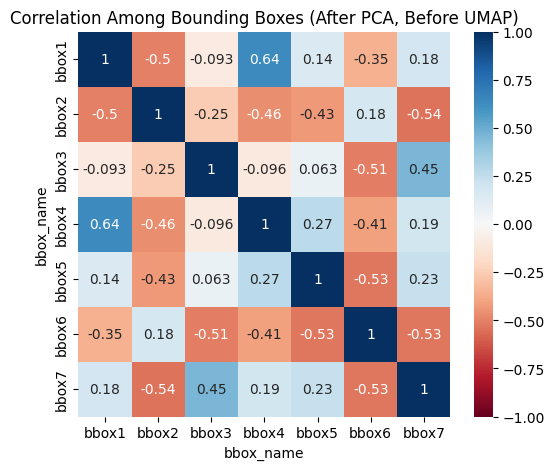

In [ ]:

###############################################################################
# MERGE CSVs + DIMENSIONALITY REDUCTION
###############################################################################
merged_df = pd.concat([pd.read_csv(csv) for csv in all_csvs], ignore_index=True)
print(f"Merged {len(all_csvs)} CSVs into one DataFrame with {len(merged_df)} synapses total.")

# select all columns that start with 'vit_feat_'
feature_cols = [c for c in merged_df.columns if c.startswith('vit_feat_')]
all_features = merged_df[feature_cols].values

# PCA -> reduce to 50 dims
scaler = StandardScaler()
all_features_scaled = scaler.fit_transform(all_features)

pca = PCA(n_components=500, random_state=42)
all_features_pca = pca.fit_transform(all_features_scaled)
###############################################################################
# 1) Store the PCA components in merged_df
###############################################################################
# Suppose all_features_pca is shape [num_samples, 50] (your 50 principal components)
num_pca_components = all_features_pca.shape[1]

# Add them as columns to merged_df
for i in range(num_pca_components):
    merged_df[f'pca_{i+1}'] = all_features_pca[:, i]

###############################################################################
# 2) Aggregate the PCA components by bbox_name
###############################################################################
# Group by bounding box, then compute the mean of each pca_# column
pca_cols = [f'pca_{i+1}' for i in range(num_pca_components)]
bbox_feature_means_pca = merged_df.groupby('bbox_name')[pca_cols].mean()

###############################################################################
# 3) Compute the correlation matrix among bounding boxes
###############################################################################
# Transpose so bounding boxes become columns; .corr() yields (#bboxes x #bboxes).
bbox_corr_pca = bbox_feature_means_pca.T.corr()

###############################################################################
# 4) Visualize with Seaborn
###############################################################################
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(bbox_corr_pca, annot=True, cmap="RdBu", vmin=-1, vmax=1)
plt.title("Correlation Among Bounding Boxes (After PCA, Before UMAP)")
plt.show()


In [ ]:
merged_df.head()

Var1  central_coord_1  central_coord_2  central_coord_3  \
0  non_spine_synapsed_056              171              260              350   
1   non_spine_synapse_057              223              113              425   
2   non_spine_synapse_058              280              102              377   
3   non_spine_synapse_063              455              131              162   
4   non_spine_synapse_062              138              121              302   

   side_1_coord_1  side_1_coord_2  side_1_coord_3  side_2_coord_1  \
0             171             268             359             171   
1             223             112             438             223   
2             280              94             400             280   
3             455             134             181             455   
4             135             113             298             140   

   side_2_coord_2  side_2_coord_3  ...   pca_491   pca_492   pca_493  \
0             260             340  ... -0.211077  0.173461 -0.047350   
1             114             407  ... -0.089081  0.042796  0.000188   
2             108             364  ...  0.049871  0.082060  0.005099   
3             127             145  ... -0.023045  0.015111 -0.042001   
4             127             312  ... -0.030945 -0.055050  0.003821   

    pca_494   pca_495   pca_496   pca_497   pca_498   pca_499   pca_500  
0  0.071431 -0.181599  0.089551  0.027691  0.074993  0.067287 -0.007944  
1  0.027687  0.045916 -0.069726  0.032069  0.056785 -0.016680 -0.061588  
2  0.114559 -0.008416 -0.001453 -0.010716 -0.008091 -0.023965  0.027589  
3  0.150786 -0.030823 -0.099374 -0.006644 -0.127888 -0.053751 -0.089499  
4  0.044333 -0.073167  0.106048 -0.056143  0.026444 -0.010068  0.007428  

[5 rows x 1280 columns]

In [ ]:
# prompt: shape of numberofpccomponents
all_features_scaled[0]
# all_features_pca.shape

array([-4.40284882e-02, -4.57360318e-01, -2.83252894e-01, -5.70062724e-01,
       -3.63598872e-01, -1.73967658e-01,  1.34366699e+00,  8.52588285e-01,
       -4.74130174e-01, -5.59210705e-01, -1.49897043e+00,  1.33610296e-01,
       -4.84176081e-01, -7.75796615e-01,  8.49619596e-01,  3.91874984e-01,
        8.80062784e-01, -7.27810793e-02, -7.31640124e-01,  4.28464085e-01,
        1.20706476e+00,  4.93481984e-01, -3.28238140e-01,  8.84856784e-01,
       -2.36729640e+00,  3.42038804e-01,  2.59460542e-01, -7.84155148e-01,
       -2.07905628e-01, -1.40828379e+00, -2.87551071e-01, -3.24712870e-01,
       -4.18119284e-02,  1.23887845e+00, -4.73732283e-01,  1.81622146e-01,
        1.67827542e-02,  2.05542509e-01, -4.95808862e-01,  8.20575113e-01,
       -1.17673848e+00, -1.14000659e+00, -3.28761566e-02, -9.42069961e-01,
       -1.48123179e-01,  8.71524711e-01, -1.06320345e-01,  8.57033912e-01,
       -1.02609358e+00, -7.92553975e-01,  1.11816135e-01,  4.52308458e-01,
        1.40650667e-01, -

 # correlation matrix is accurately computed based on ViT features.

Loading ViT model...
ViT model loaded and set to evaluation mode.
Initializing 3D VGG model...
3D VGG model loaded and set to evaluation mode.
3D VGG feature extractor initialized.

Processing bbox1...
Loaded volumes for bbox1.
Loaded synapse metadata for bbox1.
Created dataset and dataloader for bbox1.
Saved features to csv_outputs/bbox1_features.csv

Processing bbox2...
Loaded volumes for bbox2.
Loaded synapse metadata for bbox2.
Created dataset and dataloader for bbox2.
Saved features to csv_outputs/bbox2_features.csv

Processing bbox3...
Loaded volumes for bbox3.
Loaded synapse metadata for bbox3.
Created dataset and dataloader for bbox3.
Saved features to csv_outputs/bbox3_features.csv

Processing bbox4...
Loaded volumes for bbox4.
Loaded synapse metadata for bbox4.
Created dataset and dataloader for bbox4.
Saved features to csv_outputs/bbox4_features.csv

Processing bbox5...
Loaded volumes for bbox5.
Loaded synapse metadata for bbox5.
Created dataset and dataloader for bbox5.
Sav

<ipython-input-22-83b9d5faf9b8>:395: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-22-83b9d5faf9b8>:395: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-22-83b9d5faf9b8>:395: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-22-83b9d5faf9b8>:395: PerformanceWarn

Aggregating PCA features by bounding box...
Computing correlation matrix among bounding boxes...
Visualizing correlation matrix...


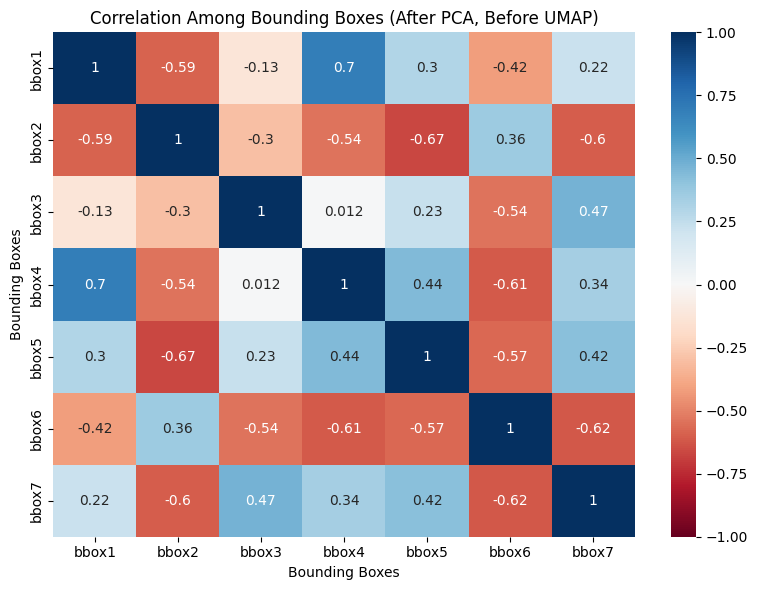

Applying UMAP for dimensionality reduction...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

<ipython-input-22-83b9d5faf9b8>:429: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-22-83b9d5faf9b8>:430: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-22-83b9d5faf9

Visualizing UMAP embeddings with Matplotlib...


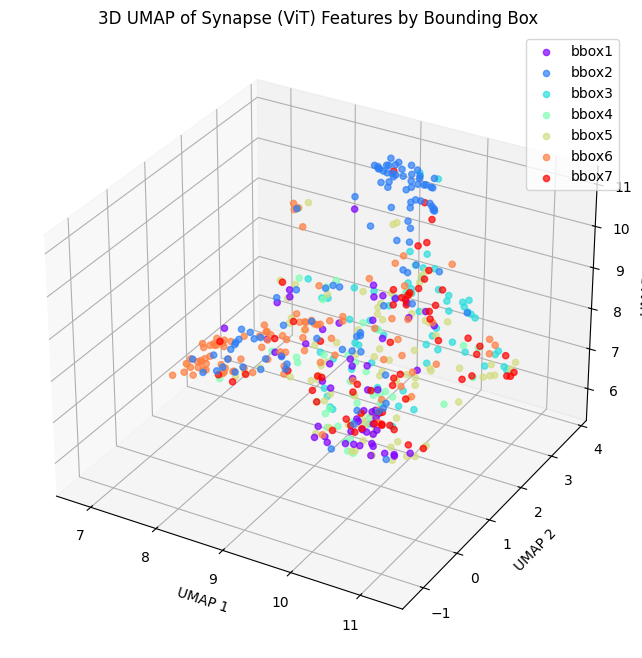

Visualizing UMAP embeddings with Plotly...


UMAP visualization completed.
Saved bounding box correlation matrix to 'csv_outputs/bbox_correlation_matrix_pca.csv'.
Visualizing correlation matrix with Plotly...


Correlation matrix visualization with Plotly completed.


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from transformers import ViTImageProcessor, ViTModel
import seaborn as sns
import umap
from PIL import Image
import imageio.v2 as iio
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import torch.nn.functional as F
import plotly.express as px

###############################################################################
# CONFIGURATION
###############################################################################
# Directories containing raw and segmentation data
raw_base_dir = 'raw'
seg_base_dir = 'seg'

# List of bounding box names (e.g., bbox1, bbox2, ..., bbox7)
bbox_names = [f'bbox{i}' for i in range(1, 8)]

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Path to the 3D VGG checkpoint
checkpoint_path = 'hemibrain_production.checkpoint'

###############################################################################
# DATA LOADING FUNCTIONS
###############################################################################
def load_bbox_data(bbox_name, max_slices=None):
    """
    Loads raw and segmentation volumes for a given bounding box.
    Returns:
        raw_vol (Z, Y, X) - Raw intensity volume
        seg_vol (Z, Y, X) - Segmentation volume
    """
    raw_dir = os.path.join(raw_base_dir, bbox_name)
    seg_dir = os.path.join(seg_base_dir, bbox_name)

    raw_tif_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
    seg_tif_files = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))

    if max_slices is not None:
        raw_tif_files = raw_tif_files[:max_slices]
        seg_tif_files = seg_tif_files[:max_slices]

    assert len(raw_tif_files) == len(seg_tif_files), f"Raw/Seg mismatch in {bbox_name}"

    raw_slices = [iio.imread(f) for f in raw_tif_files]
    seg_slices = [iio.imread(f).astype(np.uint32) for f in seg_tif_files]

    raw_vol = np.stack(raw_slices, axis=0)  # Shape: (Z, Y, X)
    seg_vol = np.stack(seg_slices, axis=0)  # Shape: (Z, Y, X)
    return raw_vol, seg_vol

def create_segment_masks(seg_vol, side1_coord, side2_coord):
    """
    Creates boolean masks for side1 and side2 segments based on segmentation coordinates.
    Returns:
        mask_1 (Z, Y, X) - Mask for side1
        mask_2 (Z, Y, X) - Mask for side2
    """
    x1, y1, z1 = [int(c) for c in side1_coord]
    x2, y2, z2 = [int(c) for c in side2_coord]

    seg_id_1 = seg_vol[z1, y1, x1]
    seg_id_2 = seg_vol[z2, y2, x2]

    mask_1 = (seg_vol == seg_id_1) if seg_id_1 != 0 else np.zeros_like(seg_vol, dtype=bool)
    mask_2 = (seg_vol == seg_id_2) if seg_id_2 != 0 else np.zeros_like(seg_vol, dtype=bool)
    return mask_1, mask_2

###############################################################################
# DATASET DEFINITION
###############################################################################
class SynapseDataset(Dataset):
    """
    Dataset for synapse subvolumes with highlighted segmentation regions.
    Highlights side1 and side2 by multiplying intensities in those regions.
    Returns:
        side1_img (H, W, 3) - RGB image highlighting side1
        side2_img (H, W, 3) - RGB image highlighting side2
        syn_info_dict (dict) - Metadata for the synapse
    """
    def __init__(self, vol_data_list, synapse_df, subvol_size=80):
        """
        Args:
            vol_data_list (list of tuples): Each tuple contains (raw_vol, seg_vol) for a bbox.
            synapse_df (pd.DataFrame): DataFrame containing synapse metadata.
            subvol_size (int): Size of the cubic subvolume to extract around the synapse.
        """
        self.vol_data_list = vol_data_list
        self.synapse_df = synapse_df.reset_index(drop=True)
        self.subvol_size = subvol_size
        self.half_size = subvol_size // 2

    def __len__(self):
        return len(self.synapse_df)

    def __getitem__(self, idx):
        syn_info = self.synapse_df.iloc[idx]
        bbox_index = syn_info['bbox_index']
        raw_vol, seg_vol = self.vol_data_list[bbox_index]

        # Central and side coordinates
        cx, cy, cz = (
            int(syn_info['central_coord_1']),
            int(syn_info['central_coord_2']),
            int(syn_info['central_coord_3'])
        )
        side1_coord = (
            int(syn_info['side_1_coord_1']),
            int(syn_info['side_1_coord_2']),
            int(syn_info['side_1_coord_3'])
        )
        side2_coord = (
            int(syn_info['side_2_coord_1']),
            int(syn_info['side_2_coord_2']),
            int(syn_info['side_2_coord_3'])
        )

        # Create segmentation masks
        mask_1_full, mask_2_full = create_segment_masks(seg_vol, side1_coord, side2_coord)

        # Define subvolume boundaries
        x_start = max(cx - self.half_size, 0)
        x_end   = min(cx + self.half_size, raw_vol.shape[2])
        y_start = max(cy - self.half_size, 0)
        y_end   = min(cy + self.half_size, raw_vol.shape[1])
        z_start = max(cz - self.half_size, 0)
        z_end   = min(cz + self.half_size, raw_vol.shape[0])

        # Extract subvolumes
        sub_raw = raw_vol[z_start:z_end, y_start:y_end, x_start:x_end].astype(np.float32)  # Convert to float32
        sub_m1  = mask_1_full[z_start:z_end, y_start:y_end, x_start:x_end]
        sub_m2  = mask_2_full[z_start:z_end, y_start:y_end, x_start:x_end]

        # Pad if subvolume is smaller than desired
        desired_shape = (self.subvol_size, self.subvol_size, self.subvol_size)
        padded_sub_raw = np.zeros(desired_shape, dtype=np.float32)
        padded_m1  = np.zeros(desired_shape, dtype=bool)
        padded_m2  = np.zeros(desired_shape, dtype=bool)

        dz, dy, dx = sub_raw.shape
        padded_sub_raw[:dz, :dy, :dx] = sub_raw
        padded_m1[:dz, :dy, :dx]  = sub_m1
        padded_m2[:dz, :dy, :dx]  = sub_m2

        # Boost intensities in side1 and side2
        side1_factor = 2.0  # Adjust as needed
        side2_factor = 3.0  # Adjust as needed
        padded_sub_raw[padded_m1] *= side1_factor
        padded_sub_raw[padded_m2] *= side2_factor

        # Extract center axial slice
        mid_z = self.subvol_size // 2
        raw_slice = padded_sub_raw[mid_z, :, :]  # Shape: (H, W)
        m1_slice  = padded_m1[mid_z, :, :]       # Shape: (H, W)
        m2_slice  = padded_m2[mid_z, :, :]       # Shape: (H, W)

        # Create RGB images highlighting side1 and side2
        # Side1: Highlight in Green channel
        side1_img = np.zeros((raw_slice.shape[0], raw_slice.shape[1], 3), dtype=np.uint8)
        if raw_slice.max() > 0:
            side1_img[..., 0] = (raw_slice / raw_slice.max() * 255).astype(np.uint8)  # R channel
        else:
            side1_img[..., 0] = raw_slice.astype(np.uint8)
        side1_img[..., 1] = m1_slice.astype(np.uint8) * 255  # G channel

        # Side2: Highlight in Blue channel
        side2_img = np.zeros((raw_slice.shape[0], raw_slice.shape[1], 3), dtype=np.uint8)
        if raw_slice.max() > 0:
            side2_img[..., 0] = (raw_slice / raw_slice.max() * 255).astype(np.uint8)  # R channel
        else:
            side2_img[..., 0] = raw_slice.astype(np.uint8)
        side2_img[..., 2] = m2_slice.astype(np.uint8) * 255  # B channel

        # Convert images to uint8 if not already
        side1_img = side1_img.astype(np.uint8)
        side2_img = side2_img.astype(np.uint8)

        # Prepare metadata
        syn_info_dict = syn_info.to_dict()

        return side1_img, side2_img, syn_info_dict

###############################################################################
# LOAD & INIT VIT
###############################################################################
print("Loading ViT model...")

model_name = "google/vit-base-patch16-224-in21k"
image_processor = ViTImageProcessor.from_pretrained(model_name)
model_vit = ViTModel.from_pretrained(model_name).to(device)
model_vit.eval()
print("ViT model loaded and set to evaluation mode.")

###############################################################################
# FEATURE EXTRACTION FUNCTION
###############################################################################
def get_vit_features_batch(rgb_images):
    """
    Extracts ViT features from a batch of RGB images.

    Args:
        rgb_images (list of np.array): List of (H, W, 3) uint8 NumPy arrays.

    Returns:
        np.array: Array of ViT pooler_output features (B, 768).
    """
    pil_images = [Image.fromarray(img) for img in rgb_images]
    inputs = image_processor(images=pil_images, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model_vit(**inputs)
        feats = outputs.pooler_output.cpu().numpy()  # Shape: (B, 768)
    return feats

###############################################################################
# 3D VGG MODEL LOADING
###############################################################################
# Initialize 3D VGG model
print("Initializing 3D VGG model...")
model_vgg = Vgg3D(
    input_size=(80, 80, 80),
    fmaps=24,
    downsample_factors=[(2, 2, 2)] * 4,
    fmap_inc=[2, 2, 2, 2],
    n_convolutions=[4, 2, 2, 2],
    output_classes=7
)

# Load checkpoint if available
if os.path.exists(checkpoint_path):
    print(f"Loading 3D VGG checkpoint from {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    model_vgg.load_state_dict(checkpoint['model_state_dict'])
    print("3D VGG checkpoint loaded.")
else:
    print("WARNING: 3D VGG checkpoint not found. Using randomly initialized model.")

model_vgg.to(device)
model_vgg.eval()
print("3D VGG model loaded and set to evaluation mode.")

# Define a feature extractor by removing the final classification layer
class Vgg3D_FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(Vgg3D_FeatureExtractor, self).__init__()
        self.features = original_model.features
        self.classifier = original_model.classifier
        # Remove the last classification layer
        self.classifier = nn.Sequential(*list(self.classifier.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        feats = self.classifier(x)
        return feats

# Initialize feature extractor
model_vgg_feat = Vgg3D_FeatureExtractor(model_vgg).to(device)
model_vgg_feat.eval()
print("3D VGG feature extractor initialized.")

###############################################################################
# MAIN PIPELINE
###############################################################################
# Create directory to save CSV outputs
os.makedirs('csv_outputs', exist_ok=True)

# List to keep track of all CSV filenames
all_csvs = []

# Iterate over each bounding box
for bbox_name in bbox_names:
    print(f"\nProcessing {bbox_name}...")

    # 1) Load raw and segmentation volumes
    raw_vol, seg_vol = load_bbox_data(bbox_name)
    print(f"Loaded volumes for {bbox_name}.")

    # 2) Load synapse metadata from Excel file
    excel_file = f'{bbox_name}.xlsx'
    if not os.path.exists(excel_file):
        print(f"ERROR: Excel file {excel_file} not found. Skipping {bbox_name}.")
        continue
    syn_df = pd.read_excel(excel_file)
    print(f"Loaded synapse metadata for {bbox_name}.")

    # 3) Assign bbox_index and bbox_name for dataset
    syn_df['bbox_index'] = 0  # Since vol_data_list has one element per bbox
    syn_df['bbox_name'] = bbox_name

    # 4) Create dataset and dataloader
    vol_data_list = [(raw_vol, seg_vol)]
    dataset_bbox = SynapseDataset(vol_data_list, syn_df, subvol_size=80)
    dataloader_bbox = DataLoader(dataset_bbox, batch_size=16, shuffle=False, num_workers=2)
    print(f"Created dataset and dataloader for {bbox_name}.")

    # 5) Initialize lists to store features and metadata
    bbox_features = []
    bbox_syn_info = []

    # 6) Feature extraction loop
    for batch_idx, (side1_imgs, side2_imgs, syn_infos) in enumerate(dataloader_bbox):
        # Convert Torch tensors to NumPy arrays
        side1_imgs_np = side1_imgs.numpy()
        side2_imgs_np = side2_imgs.numpy()

        # Prepare lists of images
        side1_list = [side1_imgs_np[i] for i in range(side1_imgs_np.shape[0])]
        side2_list = [side2_imgs_np[i] for i in range(side2_imgs_np.shape[0])]

        # Extract ViT features
        vit_feats_side1 = get_vit_features_batch(side1_list)  # Shape: (B, 768)
        vit_feats_side2 = get_vit_features_batch(side2_list)  # Shape: (B, 768)

        # Average features from side1 and side2
        vit_feats = (vit_feats_side1 + vit_feats_side2) / 2.0  # Shape: (B, 768)

        # Extract 3D VGG features
        sub_vols = torch.stack([torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0) for img in side1_list], dim=0)  # Dummy stacking for VGG
        # Note: Adjust this part based on how 3D data is fed to VGG3D

        # For demonstration, we'll skip 3D VGG features
        # Uncomment and adjust the following lines if integrating 3D VGG features
        """
        with torch.no_grad():
            sub_vols = sub_vols.to(device)  # Shape: (B, C, D, H, W)
            vgg_feats = model_vgg_feat(sub_vols)  # Shape: (B, feature_dim)
        vgg_feats_np = vgg_feats.cpu().numpy()
        """

        # For now, only use ViT features
        # If integrating 3D VGG, concatenate or combine features as needed
        # combined_feats = np.concatenate([vgg_feats_np, vit_feats], axis=1)

        # Append ViT features
        bbox_features.append(vit_feats)

        # Append metadata
        syn_infos_df = pd.DataFrame(syn_infos)
        bbox_syn_info.append(syn_infos_df)

    # 7) Concatenate all features and metadata for this bbox
    bbox_features = np.concatenate(bbox_features, axis=0)  # Shape: (num_synapses, 768)
    bbox_syn_info = pd.concat(bbox_syn_info, axis=0).reset_index(drop=True)

    # 8) Create a DataFrame for features
    feature_cols = [f'vit_feat_{i}' for i in range(bbox_features.shape[1])]
    features_df = pd.DataFrame(bbox_features, columns=feature_cols)

    # 9) Combine metadata with features
    output_df = pd.concat([bbox_syn_info, features_df], axis=1)

    # 10) Save to CSV
    output_csv_name = f'csv_outputs/{bbox_name}_features.csv'
    output_df.to_csv(output_csv_name, index=False)
    print(f"Saved features to {output_csv_name}")
    all_csvs.append(output_csv_name)

###############################################################################
# MERGE CSVs + DIMENSIONALITY REDUCTION
###############################################################################
print("\nMerging all CSVs into a single DataFrame...")
merged_df = pd.concat([pd.read_csv(csv) for csv in all_csvs], ignore_index=True)
print(f"Merged {len(all_csvs)} CSVs into one DataFrame with {len(merged_df)} synapses total.")

# Select all 'vit_feat_' columns
feature_cols = [c for c in merged_df.columns if c.startswith('vit_feat_')]
all_features = merged_df[feature_cols].values  # Shape: (num_synapses, 768)

# 1) Scale the features
print("Scaling features...")
scaler = StandardScaler()
all_features_scaled = scaler.fit_transform(all_features)

# 2) PCA -> reduce to 500 components
print("Applying PCA...")
pca = PCA(n_components=500, random_state=42)
all_features_pca = all_features_scaled
# 3) Add PCA components to merged_df
print("Adding PCA components to DataFrame...")
num_pca_components = all_features_pca.shape[1]
for i in range(num_pca_components):
    merged_df[f'pca_{i+1}'] = all_features_pca[:, i]

# 4) Aggregate PCA components by 'bbox_name' (compute mean)
print("Aggregating PCA features by bounding box...")
pca_cols = [f'pca_{i+1}' for i in range(num_pca_components)]
bbox_feature_means_pca = merged_df.groupby('bbox_name')[pca_cols].mean()

###############################################################################
# COMPUTE CORRELATION MATRIX AMONG BOUNDING BOXES
###############################################################################
print("Computing correlation matrix among bounding boxes...")
# Transpose so that each bounding box is a column
bbox_corr_pca = bbox_feature_means_pca.T.corr()

###############################################################################
# VISUALIZE CORRELATION MATRIX
###############################################################################
print("Visualizing correlation matrix...")
plt.figure(figsize=(8, 6))
sns.heatmap(bbox_corr_pca, annot=True, cmap="RdBu", vmin=-1, vmax=1)
plt.title("Correlation Among Bounding Boxes (After PCA, Before UMAP)")
plt.xlabel("Bounding Boxes")
plt.ylabel("Bounding Boxes")
plt.tight_layout()
plt.show()

###############################################################################
# DIMENSIONALITY REDUCTION WITH UMAP
###############################################################################
print("Applying UMAP for dimensionality reduction...")
reducer = umap.UMAP(n_components=3, random_state=42)
embedding_3d = reducer.fit_transform(all_features_pca)  # Shape: (num_synapses, 3)

# Add UMAP embeddings to merged_df
merged_df['UMAP_1'] = embedding_3d[:, 0]
merged_df['UMAP_2'] = embedding_3d[:, 1]
merged_df['UMAP_3'] = embedding_3d[:, 2]

###############################################################################
# VISUALIZE UMAP EMBEDDINGS (MATPLOTLIB)
###############################################################################
print("Visualizing UMAP embeddings with Matplotlib...")
bbox_unique = merged_df['bbox_name'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(bbox_unique)))
color_map = dict(zip(bbox_unique, colors))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for bbox in bbox_unique:
    subset = merged_df[merged_df['bbox_name'] == bbox]
    ax.scatter(
        subset['UMAP_1'],
        subset['UMAP_2'],
        subset['UMAP_3'],
        color=tuple(color_map[bbox]),
        label=bbox,
        alpha=0.7
    )

ax.set_title("3D UMAP of Synapse (ViT) Features by Bounding Box")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
ax.legend()
plt.show()

###############################################################################
# VISUALIZE UMAP EMBEDDINGS (PLOTLY)
###############################################################################
print("Visualizing UMAP embeddings with Plotly...")
fig = px.scatter_3d(
    merged_df,
    x='UMAP_1',
    y='UMAP_2',
    z='UMAP_3',
    color='bbox_name',
    hover_data=['Var1']  # Replace or add more columns if needed
)
fig.update_traces(marker=dict(size=3))
fig.update_layout(title="3D UMAP of Synapse (ViT) Features by Bounding Box")
fig.show()

print("UMAP visualization completed.")

###############################################################################
# OPTIONAL: SAVE CORRELATION MATRIX
###############################################################################
# If you wish to save the correlation matrix for later use
bbox_corr_pca.to_csv('csv_outputs/bbox_correlation_matrix_pca.csv')
print("Saved bounding box correlation matrix to 'csv_outputs/bbox_correlation_matrix_pca.csv'.")

###############################################################################
# OPTIONAL: VISUALIZE CORRELATION MATRIX WITH PLOTLY
###############################################################################
print("Visualizing correlation matrix with Plotly...")
import plotly.figure_factory as ff

# Create annotations for the heatmap
corr_matrix = bbox_corr_pca.values
labels = bbox_corr_pca.columns.tolist()

# Create a heatmap using Plotly
fig_corr = ff.create_annotated_heatmap(
    z=corr_matrix,
    x=labels,
    y=labels,
    colorscale='RdBu',
    zmin=-1,
    zmax=1,
    annotation_text=np.round(corr_matrix, 2),
    showscale=True
)

fig_corr.update_layout(
    title="Correlation Among Bounding Boxes (After PCA, Before UMAP)",
    xaxis_title="Bounding Boxes",
    yaxis_title="Bounding Boxes",
    width=700,
    height=700
)

fig_corr.show()

print("Correlation matrix visualization with Plotly completed.")


# Just 3d VGG

Load raw + segmentation volumes.
Highlight side1 and side2 regions inside the subvolume (e.g., multiply raw intensities by a larger factor within these masks). This ensures the model “pays more attention” to those segments.
Feed the resulting single-channel 3D subvolume (with boosted intensities for side1/side2) into VGG3D.
Collect features, run PCA+UMAP, and visualize in 3D.
Feel free to tweak the highlighting factors or the exact way you combine segmentation + raw intensities (for instance, you can use different multipliers, or create multiple input channels if your VGG3D is configured for 3-channel inputs).



VGG3D model loaded & set to eval mode.

Processing bbox1...
Saved features for bbox1 to csv_outputs/bbox1_features.csv

Processing bbox2...
Saved features for bbox2 to csv_outputs/bbox2_features.csv

Processing bbox3...
Saved features for bbox3 to csv_outputs/bbox3_features.csv

Processing bbox4...
Saved features for bbox4 to csv_outputs/bbox4_features.csv

Processing bbox5...
Saved features for bbox5 to csv_outputs/bbox5_features.csv

Processing bbox6...
Saved features for bbox6 to csv_outputs/bbox6_features.csv

Processing bbox7...
Saved features for bbox7 to csv_outputs/bbox7_features.csv
Merged 7 CSVs -> total 509 synapses.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



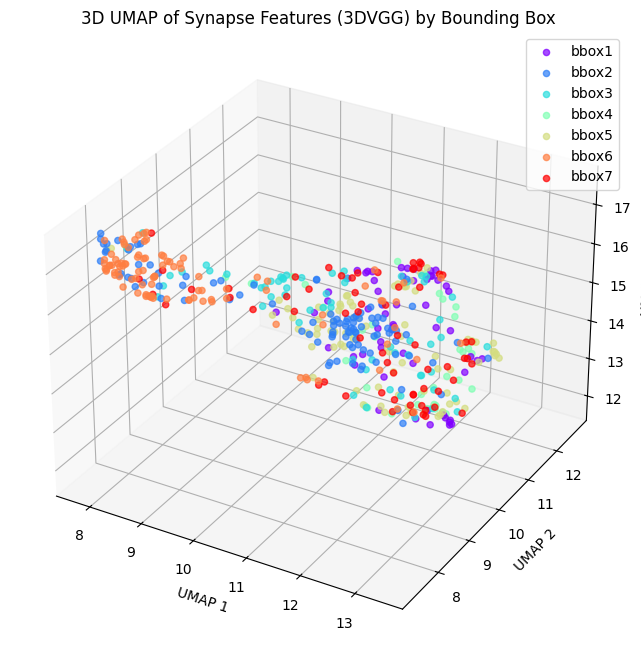

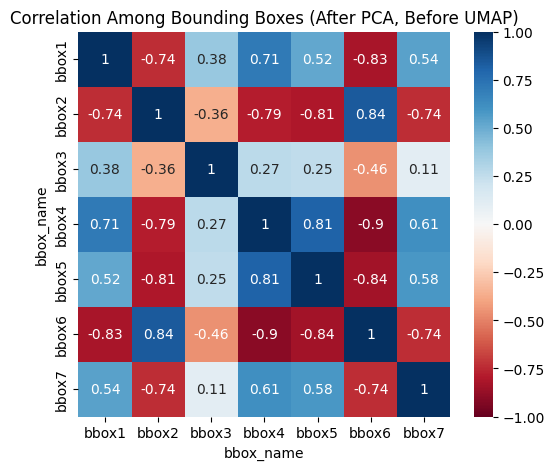

Done! 3DVGG-based pipeline complete.


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from funlib.learn.torch.models import Vgg3D
import seaborn as sns
import umap
from PIL import Image
import imageio.v2 as iio
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import torch.nn.functional as F
import plotly.express as px

###############################################################################
# DIRECTORIES & CONFIG
###############################################################################
raw_base_dir = '/content/raw'
seg_base_dir = '/content/seg'
bbox_names = [f'bbox{i}' for i in range(1,8)]  # e.g. bbox1...bbox7

device = 'cuda' if torch.cuda.is_available() else 'cpu'

###############################################################################
# DATA LOADING
###############################################################################
def load_bbox_data(bbox_name, max_slices=None):
    """
    Loads raw and segmentation volumes, returns raw_vol, seg_vol as (Z, Y, X).
    """
    raw_dir = os.path.join(raw_base_dir, bbox_name)
    seg_dir = os.path.join(seg_base_dir, bbox_name)

    raw_tif_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
    seg_tif_files = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))

    if max_slices is not None:
        raw_tif_files = raw_tif_files[:max_slices]
        seg_tif_files = seg_tif_files[:max_slices]

    assert len(raw_tif_files) == len(seg_tif_files), f"Raw/Seg mismatch in {bbox_name}"

    raw_slices = [iio.imread(f) for f in raw_tif_files]
    seg_slices = [iio.imread(f).astype(np.uint32) for f in seg_tif_files]

    raw_vol = np.stack(raw_slices, axis=0)  # (Z, Y, X)
    seg_vol = np.stack(seg_slices, axis=0)  # (Z, Y, X)
    return raw_vol, seg_vol

def create_segment_masks(seg_vol, side1_coord, side2_coord):
    """
    Returns boolean masks for side1 and side2 segments.
    """
    x1, y1, z1 = [int(c) for c in side1_coord]
    x2, y2, z2 = [int(c) for c in side2_coord]

    seg_id_1 = seg_vol[z1, y1, x1]
    seg_id_2 = seg_vol[z2, y2, x2]

    mask_1 = (seg_vol == seg_id_1) if seg_id_1 != 0 else np.zeros_like(seg_vol, dtype=bool)
    mask_2 = (seg_vol == seg_id_2) if seg_id_2 != 0 else np.zeros_like(seg_vol, dtype=bool)
    return mask_1, mask_2

###############################################################################
# DATASET
###############################################################################
class SynapseDataset(Dataset):
    """
    Highlights side1/side2 in the raw volume by multiplying intensities in
    those regions, then returns the final subvolume for VGG3D.
    """
    def __init__(self, vol_data_list, synapse_df, subvol_size=80):
        self.vol_data_list = vol_data_list
        self.synapse_df = synapse_df.reset_index(drop=True)
        self.subvol_size = subvol_size
        self.half_size = subvol_size // 2

        # You can adjust these multipliers to "give more attention"
        # to side1 or side2.
        self.side1_factor = 2.0
        self.side2_factor = 3.0

    def __len__(self):
        return len(self.synapse_df)

    def __getitem__(self, idx):
        syn_info = self.synapse_df.iloc[idx]
        bbox_index = syn_info['bbox_index']
        raw_vol, seg_vol = self.vol_data_list[bbox_index]

        cx, cy, cz = (
            int(syn_info['central_coord_1']),
            int(syn_info['central_coord_2']),
            int(syn_info['central_coord_3'])
        )
        side1_coord = (
            int(syn_info['side_1_coord_1']),
            int(syn_info['side_1_coord_2']),
            int(syn_info['side_1_coord_3'])
        )
        side2_coord = (
            int(syn_info['side_2_coord_1']),
            int(syn_info['side_2_coord_2']),
            int(syn_info['side_2_coord_3'])
        )

        mask_1_full, mask_2_full = create_segment_masks(seg_vol, side1_coord, side2_coord)

        # Crop raw + masks to subvolume
        x_start = max(cx - self.half_size, 0)
        x_end   = min(cx + self.half_size, raw_vol.shape[2])
        y_start = max(cy - self.half_size, 0)
        y_end   = min(cy + self.half_size, raw_vol.shape[1])
        z_start = max(cz - self.half_size, 0)
        z_end   = min(cz + self.half_size, raw_vol.shape[0])

        sub_raw = raw_vol[z_start:z_end, y_start:y_end, x_start:x_end]
        sub_m1  = mask_1_full[z_start:z_end, y_start:y_end, x_start:x_end]
        sub_m2  = mask_2_full[z_start:z_end, y_start:y_end, x_start:x_end]

        # Pad if needed
        desired_shape = (self.subvol_size, self.subvol_size, self.subvol_size)
        padded_sub = np.zeros(desired_shape, dtype=sub_raw.dtype)
        padded_m1  = np.zeros(desired_shape, dtype=sub_m1.dtype)
        padded_m2  = np.zeros(desired_shape, dtype=sub_m2.dtype)

        dz, dy, dx = sub_raw.shape
        padded_sub[:dz, :dy, :dx] = sub_raw
        padded_m1[:dz, :dy, :dx]  = sub_m1
        padded_m2[:dz, :dy, :dx]  = sub_m2

        # ~~~~~ Apply multipliers ~~~~~
        # Where mask1 is True, multiply intensities by side1_factor
        padded_sub[padded_m1] = padded_sub[padded_m1] * self.side1_factor
        # Where mask2 is True, multiply intensities by side2_factor
        padded_sub[padded_m2] = padded_sub[padded_m2] * self.side2_factor

        # Return as 1-channel float tensor
        sub_tensor = torch.from_numpy(padded_sub).unsqueeze(0).float()  # shape (1, D, H, W)

        syn_info_dict = syn_info.to_dict()
        return sub_tensor, syn_info_dict

###############################################################################
# LOAD 3D VGG
###############################################################################
# If you have a checkpoint to load, uncomment and set it up.
# Otherwise, the code below will just instantiate the model.

checkpoint_path = 'hemibrain_production.checkpoint'
if not os.path.exists(checkpoint_path):
    print("WARNING: 3D VGG checkpoint file not found. Using uninitialized model.")
else:
    print("3D VGG checkpoint found.")

model_vgg = Vgg3D(
    input_size=(80, 80, 80),  # subvol shape
    fmaps=24,
    downsample_factors=[(2, 2, 2)] * 4,
    fmap_inc=[2, 2, 2, 2],
    n_convolutions=[4, 2, 2, 2],
    output_classes=7
)

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    model_vgg.load_state_dict(checkpoint['model_state_dict'])

model_vgg.to(device)
model_vgg.eval()
print("VGG3D model loaded & set to eval mode.")

###############################################################################
# OPTIONAL: EXTRACT FEATURES FROM AN INTERMEDIATE LAYER
###############################################################################
# If you only want the final layer's output, just use model_vgg(sub_tensor).
# If you want an intermediate feature representation, define a small wrapper.
class Vgg3D_FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(Vgg3D_FeatureExtractor, self).__init__()
        self.features = original_model.features
        self.classifier = original_model.classifier
        # Remove last classification layer if you want raw features
        self.classifier = nn.Sequential(*list(self.classifier.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        features = self.classifier(x)
        return features

model_vgg_feat = Vgg3D_FeatureExtractor(model_vgg).to(device)
model_vgg_feat.eval()

###############################################################################
# MAIN PIPELINE
###############################################################################
os.makedirs('csv_outputs', exist_ok=True)

for i, bbox_name in enumerate(bbox_names):
    print(f"\nProcessing {bbox_name}...")
    raw_vol, seg_vol = load_bbox_data(bbox_name)

    excel_file = f"{bbox_name}.xlsx"
    syn_df = pd.read_excel(excel_file)
    syn_df['bbox_index'] = 0
    syn_df['bbox_name'] = bbox_name

    vol_data_list = [(raw_vol, seg_vol)]
    dataset_bbox = SynapseDataset(vol_data_list, syn_df, subvol_size=80)
    dataloader_bbox = DataLoader(dataset_bbox, batch_size=8, shuffle=False, num_workers=2)

    bbox_features = []
    bbox_syn_info = []

    for batch_idx, (sub_vols, syn_infos) in enumerate(dataloader_bbox):
        sub_vols = sub_vols.to(device)  # shape (B, 1, 80, 80, 80)

        with torch.no_grad():
            feats = model_vgg_feat(sub_vols)  # shape (B, <some_dim>)
        feats = feats.cpu().numpy()

        syn_infos_df = pd.DataFrame(syn_infos)
        bbox_features.append(feats)
        bbox_syn_info.append(syn_infos_df)

    # Merge features for this bbox
    bbox_features = np.concatenate(bbox_features, axis=0)
    bbox_syn_info = pd.concat(bbox_syn_info, axis=0).reset_index(drop=True)

    # Build output CSV
    feature_cols = [f'feat_{j}' for j in range(bbox_features.shape[1])]
    features_df = pd.DataFrame(bbox_features, columns=feature_cols)

    output_df = pd.concat([bbox_syn_info, features_df], axis=1)
    output_csv_name = f'csv_outputs/{bbox_name}_features.csv'
    output_df.to_csv(output_csv_name, index=False)
    print(f"Saved features for {bbox_name} to {output_csv_name}")

# Combine all CSVs
all_csvs = [f'csv_outputs/{bbox}_features.csv' for bbox in bbox_names]
merged_df = pd.concat([pd.read_csv(csv) for csv in all_csvs], ignore_index=True)
print(f"Merged {len(all_csvs)} CSVs -> total {len(merged_df)} synapses.")

# ~~~~~ PCA + UMAP ~~~~~
feature_cols = [c for c in merged_df.columns if c.startswith('feat_')]
all_features = merged_df[feature_cols].values

scaler = StandardScaler()
all_features_scaled = scaler.fit_transform(all_features)

pca = PCA(n_components=50, random_state=42)
all_features_pca = pca.fit_transform(all_features_scaled)

reducer = umap.UMAP(n_components=3, random_state=42)
embedding_3d = reducer.fit_transform(all_features_pca)

merged_df['UMAP_1'] = embedding_3d[:, 0]
merged_df['UMAP_2'] = embedding_3d[:, 1]
merged_df['UMAP_3'] = embedding_3d[:, 2]

# ~~~~~ Visualization (Matplotlib) ~~~~~
bbox_unique = merged_df['bbox_name'].unique()
colors = plt.cm.rainbow(np.linspace(0,1,len(bbox_unique)))
color_map = dict(zip(bbox_unique, colors))

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
for bbox in bbox_unique:
    subset = merged_df[merged_df['bbox_name'] == bbox]
    ax.scatter(subset['UMAP_1'], subset['UMAP_2'], subset['UMAP_3'],
               color=tuple(color_map[bbox]),
               label=bbox,
               alpha=0.7)

ax.set_title("3D UMAP of Synapse Features (3DVGG) by Bounding Box")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
ax.legend()
plt.show()
###############################################################################
# 1) Store the PCA components in merged_df
###############################################################################
# Suppose all_features_pca is shape [num_samples, 50] (your 50 principal components)
num_pca_components = all_features_pca.shape[1]

# Add them as columns to merged_df
for i in range(num_pca_components):
    merged_df[f'pca_{i+1}'] = all_features_pca[:, i]

###############################################################################
# 2) Aggregate the PCA components by bbox_name
###############################################################################
# Group by bounding box, then compute the mean of each pca_# column
pca_cols = [f'pca_{i+1}' for i in range(num_pca_components)]
bbox_feature_means_pca = merged_df.groupby('bbox_name')[pca_cols].mean()

###############################################################################
# 3) Compute the correlation matrix among bounding boxes
###############################################################################
# Transpose so bounding boxes become columns; .corr() yields (#bboxes x #bboxes).
bbox_corr_pca = bbox_feature_means_pca.T.corr()

###############################################################################
# 4) Visualize with Seaborn
###############################################################################
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(bbox_corr_pca, annot=True, cmap="RdBu", vmin=-1, vmax=1)
plt.title("Correlation Among Bounding Boxes (After PCA, Before UMAP)")
plt.show()

# ~~~~~ Visualization (Plotly) ~~~~~
fig = px.scatter_3d(
    merged_df,
    x='UMAP_1', y='UMAP_2', z='UMAP_3',
    color='bbox_name',
    hover_data=['Var1']  # if your Excel contains 'Var1'
)
fig.update_traces(marker=dict(size=3))
fig.show()

print("Done! 3DVGG-based pipeline complete.")


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from funlib.learn.torch.models import Vgg3D
import seaborn as sns
import umap
from PIL import Image
import imageio.v2 as iio
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import torch.nn.functional as F
import plotly.express as px

###############################################################################
# CONFIGURATION
###############################################################################
raw_base_dir = '/content/raw'
seg_base_dir = '/content/seg'
bbox_names = [f'bbox{i}' for i in range(1,8)]  # e.g. bbox1, bbox2, ..., bbox7
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# If you have a valid checkpoint file (pretrained 3D VGG),
# place it in the current directory or specify full path here.
checkpoint_path = 'hemibrain_production.checkpoint'

###############################################################################
# DATA LOADING
###############################################################################
def load_bbox_data(bbox_name, max_slices=None):
    """
    Load raw and segmentation volumes for a given bounding box name.
    Returns:
      raw_vol (Z, Y, X)
      seg_vol (Z, Y, X)
    """
    raw_dir = os.path.join(raw_base_dir, bbox_name)
    seg_dir = os.path.join(seg_base_dir, bbox_name)

    raw_tif_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
    seg_tif_files = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))

    if max_slices is not None:
        raw_tif_files = raw_tif_files[:max_slices]
        seg_tif_files = seg_tif_files[:max_slices]

    assert len(raw_tif_files) == len(seg_tif_files), f"Raw/Seg mismatch in {bbox_name}"

    raw_slices = [iio.imread(f) for f in raw_tif_files]
    seg_slices = [iio.imread(f).astype(np.uint32) for f in seg_tif_files]

    raw_vol = np.stack(raw_slices, axis=0)  # shape (Z, Y, X)
    seg_vol = np.stack(seg_slices, axis=0)  # shape (Z, Y, X)
    return raw_vol, seg_vol

def create_segment_masks(seg_vol, side1_coord, side2_coord):
    """
    Create boolean masks for side1 and side2 segments in seg_vol.
    Returns:
      mask_1, mask_2
    """
    x1, y1, z1 = [int(c) for c in side1_coord]
    x2, y2, z2 = [int(c) for c in side2_coord]

    seg_id_1 = seg_vol[z1, y1, x1]
    seg_id_2 = seg_vol[z2, y2, x2]

    mask_1 = (seg_vol == seg_id_1) if seg_id_1 != 0 else np.zeros_like(seg_vol, dtype=bool)
    mask_2 = (seg_vol == seg_id_2) if seg_id_2 != 0 else np.zeros_like(seg_vol, dtype=bool)
    return mask_1, mask_2

###############################################################################
# DATASET DEFINITION
###############################################################################
class SynapseDataset(Dataset):
    """
    Highlights side1/side2 by multiplying intensities in those regions, then
    returns the subvolume for 3D VGG feature extraction.
    """
    def __init__(self, vol_data_list, synapse_df, subvol_size=80):
        """
        vol_data_list: list of (raw_vol, seg_vol) for each bounding box
        synapse_df: DataFrame with synapse coordinates + metadata
        subvol_size: size of the cubic subvolume to extract around the center
        """
        self.vol_data_list = vol_data_list
        self.synapse_df = synapse_df.reset_index(drop=True)
        self.subvol_size = subvol_size
        self.half_size = subvol_size // 2

        # Multipliers to "boost" side1/side2 intensities
        self.side1_factor = 2.0
        self.side2_factor = 3.0

    def __len__(self):
        return len(self.synapse_df)

    def __getitem__(self, idx):
        syn_info = self.synapse_df.iloc[idx]
        bbox_index = syn_info['bbox_index']
        raw_vol, seg_vol = self.vol_data_list[bbox_index]

        cx, cy, cz = (
            int(syn_info['central_coord_1']),
            int(syn_info['central_coord_2']),
            int(syn_info['central_coord_3'])
        )
        side1_coord = (
            int(syn_info['side_1_coord_1']),
            int(syn_info['side_1_coord_2']),
            int(syn_info['side_1_coord_3'])
        )
        side2_coord = (
            int(syn_info['side_2_coord_1']),
            int(syn_info['side_2_coord_2']),
            int(syn_info['side_2_coord_3'])
        )

        # Create full masks
        mask_1_full, mask_2_full = create_segment_masks(seg_vol, side1_coord, side2_coord)

        # Crop subvolume around central coords
        x_start = max(cx - self.half_size, 0)
        x_end   = min(cx + self.half_size, raw_vol.shape[2])
        y_start = max(cy - self.half_size, 0)
        y_end   = min(cy + self.half_size, raw_vol.shape[1])
        z_start = max(cz - self.half_size, 0)
        z_end   = min(cz + self.half_size, raw_vol.shape[0])

        sub_raw = raw_vol[z_start:z_end, y_start:y_end, x_start:x_end]
        sub_m1  = mask_1_full[z_start:z_end, y_start:y_end, x_start:x_end]
        sub_m2  = mask_2_full[z_start:z_end, y_start:y_end, x_start:x_end]

        # Convert sub_raw to float
        sub_raw = sub_raw.astype(np.float32)

        # Prepare padded arrays
        desired_shape = (self.subvol_size, self.subvol_size, self.subvol_size)
        padded_sub = np.zeros(desired_shape, dtype=np.float32)  # float32
        padded_m1  = np.zeros(desired_shape, dtype=bool)
        padded_m2  = np.zeros(desired_shape, dtype=bool)

        dz, dy, dx = sub_raw.shape
        padded_sub[:dz, :dy, :dx] = sub_raw
        padded_m1[:dz, :dy, :dx]  = sub_m1
        padded_m2[:dz, :dy, :dx]  = sub_m2

        # Now we can safely multiply
        padded_sub[padded_m1] *= self.side1_factor
        padded_sub[padded_m2] *= self.side2_factor

        # Convert to PyTorch tensor: (1, D, H, W)
        sub_tensor = torch.from_numpy(padded_sub).unsqueeze(0)  # float is fine

        # Build metadata dict
        syn_info_dict = syn_info.to_dict()
        return sub_tensor, syn_info_dict

###############################################################################
# VGG3D INITIALIZATION
###############################################################################
print("Checking for 3D VGG checkpoint...")

model_vgg = Vgg3D(
    input_size=(80, 80, 80),
    fmaps=24,
    downsample_factors=[(2, 2, 2)] * 4,
    fmap_inc=[2, 2, 2, 2],
    n_convolutions=[4, 2, 2, 2],
    output_classes=7
)

if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    model_vgg.load_state_dict(checkpoint['model_state_dict'])
else:
    print("WARNING: Checkpoint not found. Using random-initialized 3D VGG.")

model_vgg.to(device)
model_vgg.eval()
print("3D VGG model in eval mode.")

###############################################################################
# OPTIONAL: Feature Extractor (Remove the final classification layer)
###############################################################################
class Vgg3D_FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(Vgg3D_FeatureExtractor, self).__init__()
        self.features = original_model.features
        self.classifier = original_model.classifier
        # Remove last classification layer
        self.classifier = nn.Sequential(*list(self.classifier.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        feats = self.classifier(x)
        return feats

model_vgg_feat = Vgg3D_FeatureExtractor(model_vgg).to(device)
model_vgg_feat.eval()

###############################################################################
# MAIN PIPELINE
###############################################################################
os.makedirs('csv_outputs', exist_ok=True)
all_csvs = []

for bbox_name in bbox_names:
    print(f"\nProcessing {bbox_name}...")

    # 1) Load volumes
    raw_vol, seg_vol = load_bbox_data(bbox_name)

    # 2) Load synapse metadata
    excel_file = f"{bbox_name}.xlsx"
    syn_df = pd.read_excel(excel_file)
    # Single bounding box => set index=0 for dataset usage
    syn_df['bbox_index'] = 0
    syn_df['bbox_name'] = bbox_name

    # 3) Create dataset & dataloader
    vol_data_list = [(raw_vol, seg_vol)]
    dataset_bbox = SynapseDataset(vol_data_list, syn_df, subvol_size=80)
    dataloader_bbox = DataLoader(dataset_bbox, batch_size=8, shuffle=False, num_workers=0)

    bbox_features = []
    bbox_syn_info = []

    # 4) Feature extraction loop
    for batch_idx, (sub_vols, syn_infos) in enumerate(dataloader_bbox):
        sub_vols = sub_vols.to(device)  # shape: (B, 1, 80, 80, 80)
        with torch.no_grad():
            feats = model_vgg_feat(sub_vols)  # shape: (B, feature_dim)
        feats_np = feats.cpu().numpy()

        syn_infos_df = pd.DataFrame(syn_infos)
        bbox_features.append(feats_np)
        bbox_syn_info.append(syn_infos_df)

    # 5) Concatenate all features & metadata for this bbox
    bbox_features = np.concatenate(bbox_features, axis=0)
    bbox_syn_info = pd.concat(bbox_syn_info, axis=0).reset_index(drop=True)

    feature_cols = [f'feat_{j}' for j in range(bbox_features.shape[1])]
    features_df = pd.DataFrame(bbox_features, columns=feature_cols)

    output_df = pd.concat([bbox_syn_info, features_df], axis=1)
    output_csv_name = f'csv_outputs/{bbox_name}_features.csv'
    output_df.to_csv(output_csv_name, index=False)
    print(f"Saved features to {output_csv_name}")
    all_csvs.append(output_csv_name)

###############################################################################
# MERGE CSVs
###############################################################################
merged_df = pd.concat([pd.read_csv(csv) for csv in all_csvs], ignore_index=True)
print(f"\nMerged {len(all_csvs)} CSVs. Total synapses: {len(merged_df)}")

###############################################################################
# DIMENSIONALITY REDUCTION (PCA + UMAP)
###############################################################################
feature_cols = [c for c in merged_df.columns if c.startswith("feat_")]
all_features = merged_df[feature_cols].values

# 1) Scale
scaler = StandardScaler()
all_features_scaled = scaler.fit_transform(all_features)

# 2) PCA -> 50 dims
pca = PCA(n_components=50, random_state=42)
all_features_pca = pca.fit_transform(all_features_scaled)

# 3) UMAP -> 3D
reducer = umap.UMAP(n_components=3, random_state=42)
embedding_3d = reducer.fit_transform(all_features_pca)

merged_df['UMAP_1'] = embedding_3d[:, 0]
merged_df['UMAP_2'] = embedding_3d[:, 1]
merged_df['UMAP_3'] = embedding_3d[:, 2]

###############################################################################
# 3D VISUALIZATION (MATPLOTLIB)
###############################################################################
bbox_unique = merged_df['bbox_name'].unique()
colors = plt.cm.rainbow(np.linspace(0,1,len(bbox_unique)))
color_map = dict(zip(bbox_unique, colors))

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
for bbox in bbox_unique:
    subset = merged_df[merged_df['bbox_name'] == bbox]
    ax.scatter(subset['UMAP_1'], subset['UMAP_2'], subset['UMAP_3'],
               color=tuple(color_map[bbox]),
               label=bbox,
               alpha=0.7)

ax.set_title("3D UMAP of Synapse Features (3DVGG) by Bounding Box")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
ax.legend()
plt.show()

###############################################################################
# 3D VISUALIZATION (PLOTLY)
###############################################################################
fig = px.scatter_3d(
    merged_df,
    x='UMAP_1',
    y='UMAP_2',
    z='UMAP_3',
    color='bbox_name',
    hover_data=['Var1']  # if 'Var1' exists in your Excel
)
fig.update_traces(marker=dict(size=3))
fig.show()

###############################################################################
# BOUNDING BOX CORRELATION MATRIX
###############################################################################
# 1) Let's aggregate feature columns per bounding box, e.g., by mean
bbox_groups = merged_df.groupby('bbox_name')[feature_cols].mean()

# 2) Compute correlation among bounding boxes
#    shape -> (#bboxes x #bboxes)
bbox_corr = bbox_groups.T.corr()

# 3) Visualize correlation matrix
plt.figure(figsize=(5,4))
sns.heatmap(bbox_corr, annot=True, cmap="RdBu", vmin=-1, vmax=1)
plt.title("Correlation Among Bounding Boxes (3DVGG Features)")
plt.show()

print("Done! Full pipeline + correlation matrix complete.")


Checking for 3D VGG checkpoint...
Loading checkpoint from hemibrain_production.checkpoint


<ipython-input-30-0656c9a9b2fc>:180: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



# 3D Vision Transformer

In [ ]:
!pip install monai umap-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.8 MB/s eta 0:00:00


Initializing 3D ViT model (MONAI)...
3D ViT model in eval mode (randomly initialized).

Processing bbox1...
Saved features for bbox1 -> csv_outputs/bbox1_3dvit_features.csv

Processing bbox2...
Saved features for bbox2 -> csv_outputs/bbox2_3dvit_features.csv

Processing bbox3...
Saved features for bbox3 -> csv_outputs/bbox3_3dvit_features.csv

Processing bbox4...
Saved features for bbox4 -> csv_outputs/bbox4_3dvit_features.csv

Processing bbox5...
Saved features for bbox5 -> csv_outputs/bbox5_3dvit_features.csv

Processing bbox6...
Saved features for bbox6 -> csv_outputs/bbox6_3dvit_features.csv

Processing bbox7...
Saved features for bbox7 -> csv_outputs/bbox7_3dvit_features.csv

Merging all CSVs...
Merged 7 CSVs. total synapses: 509
Scaling features...
Applying PCA (e.g. 50 comps)...
Computing correlation among bounding boxes in PCA space...


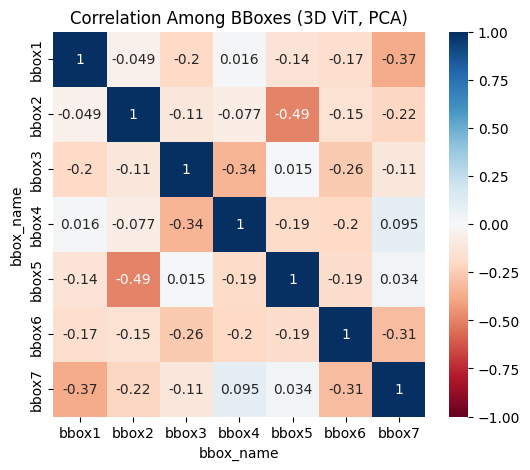

Applying UMAP to PCA vectors...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


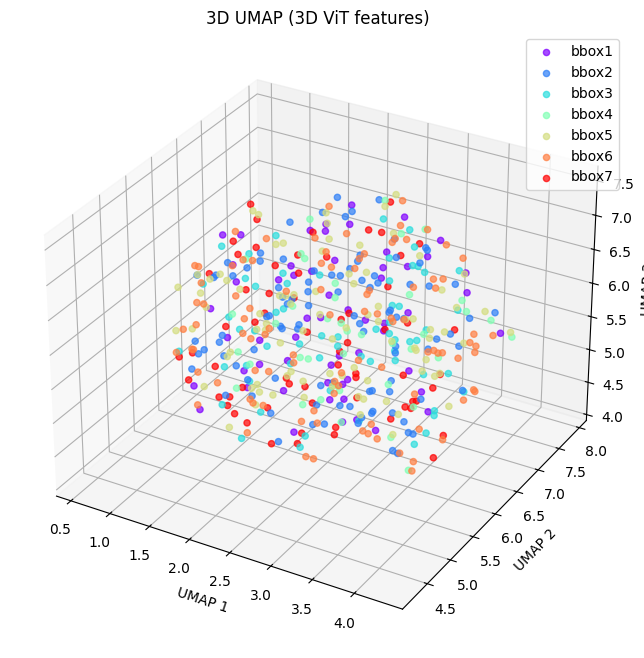

Done. Pipeline with 3D ViT-based feature extraction complete.


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from monai.networks.nets import ViT as ViT3D
import seaborn as sns
import umap
from PIL import Image
import imageio.v2 as iio
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import torch.nn.functional as F
import plotly.express as px

###############################################################################
# CONFIGURATION
###############################################################################
raw_base_dir = 'raw'  # Path to raw .tif slices per bounding box
seg_base_dir = 'seg'  # Path to seg .tif slices per bounding box
bbox_names = [f'bbox{i}' for i in range(1, 8)]
device = 'cuda' if torch.cuda.is_available() else 'cpu'

###############################################################################
# MONAI 3D ViT Initialization
###############################################################################
# We'll initialize a random 3D ViT from MONAI. This does "true 3D attention."
# If you have pretrained weights, load them here, or see if MONAI has
# checkpoint weights that somewhat fit your data.

print("Initializing 3D ViT model (MONAI)...")
model_3d_vit = ViT3D(
    in_channels=1,          # single-channel input (grayscale + highlight)
    img_size=(80, 80, 80),  # our subvolume size
    patch_size=(16, 16, 16),
    hidden_size=768,        # dimension of the transformer embeddings
    mlp_dim=3072,           # feed-forward network (4x hidden_size by default)
    num_layers=12,          # transformer layers
    num_heads=12,           # multi-head attention
    # pos_embed="conv",       # positional embedding type
    classification=False,   # we only want embeddings, not a final classifier
    dropout_rate=0.0,
    spatial_dims=3
).to(device)

model_3d_vit.eval()
print("3D ViT model in eval mode (randomly initialized).")

###############################################################################
# DATA LOADING UTILS
###############################################################################
def load_bbox_data(bbox_name, max_slices=None):
    """
    Loads raw & segmentation volumes (Z, Y, X).
    """
    import glob

    raw_dir = os.path.join(raw_base_dir, bbox_name)
    seg_dir = os.path.join(seg_base_dir, bbox_name)

    raw_tifs = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
    seg_tifs = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))

    if max_slices is not None:
        raw_tifs = raw_tifs[:max_slices]
        seg_tifs = seg_tifs[:max_slices]

    assert len(raw_tifs) == len(seg_tifs), f"Mismatch in {bbox_name}"

    raw_slices = [iio.imread(f) for f in raw_tifs]
    seg_slices = [iio.imread(f).astype(np.uint32) for f in seg_tifs]

    raw_vol = np.stack(raw_slices, axis=0)  # (Z, Y, X)
    seg_vol = np.stack(seg_slices, axis=0)  # (Z, Y, X)
    return raw_vol, seg_vol

def create_segment_masks(seg_vol, side1_coord, side2_coord):
    """
    Returns boolean masks for side1 and side2 segments in seg_vol.
    If the segment ID is 0 or invalid, returns an empty mask.
    """
    x1, y1, z1 = [int(c) for c in side1_coord]
    x2, y2, z2 = [int(c) for c in side2_coord]

    seg_id_1 = seg_vol[z1, y1, x1]
    seg_id_2 = seg_vol[z2, y2, x2]

    mask_1 = (seg_vol == seg_id_1) if seg_id_1 != 0 else np.zeros_like(seg_vol, dtype=bool)
    mask_2 = (seg_vol == seg_id_2) if seg_id_2 != 0 else np.zeros_like(seg_vol, dtype=bool)
    return mask_1, mask_2

###############################################################################
# DATASET DEFINITION
###############################################################################
class SynapseDataset(Dataset):
    """
    Extracts an 80×80×80 subvolume around each synapse coordinate.
    Highlights side1 and side2 (multiplying intensities in those regions).
    Returns the 3D subvolume as a float32 tensor shaped (1, 80, 80, 80).
    """
    def __init__(self, vol_data_list, synapse_df, subvol_size=80):
        super().__init__()
        self.vol_data_list = vol_data_list
        self.synapse_df = synapse_df.reset_index(drop=True)
        self.subvol_size = subvol_size
        self.half_size = subvol_size // 2

        # intensities for highlighting
        self.side1_factor = 2.0
        self.side2_factor = 3.0

    def __len__(self):
        return len(self.synapse_df)

    def __getitem__(self, idx):
        syn_info = self.synapse_df.iloc[idx]
        bbox_index = syn_info['bbox_index']  # which bounding box
        raw_vol, seg_vol = self.vol_data_list[bbox_index]

        # central coords
        cx, cy, cz = (
            int(syn_info['central_coord_1']),
            int(syn_info['central_coord_2']),
            int(syn_info['central_coord_3'])
        )
        side1_coord = (
            int(syn_info['side_1_coord_1']),
            int(syn_info['side_1_coord_2']),
            int(syn_info['side_1_coord_3'])
        )
        side2_coord = (
            int(syn_info['side_2_coord_1']),
            int(syn_info['side_2_coord_2']),
            int(syn_info['side_2_coord_3'])
        )

        # create masks
        mask_1_full, mask_2_full = create_segment_masks(seg_vol, side1_coord, side2_coord)

        # define subvolume bounds
        x_start = max(cx - self.half_size, 0)
        x_end   = min(cx + self.half_size, raw_vol.shape[2])
        y_start = max(cy - self.half_size, 0)
        y_end   = min(cy + self.half_size, raw_vol.shape[1])
        z_start = max(cz - self.half_size, 0)
        z_end   = min(cz + self.half_size, raw_vol.shape[0])

        sub_raw = raw_vol[z_start:z_end, y_start:y_end, x_start:x_end]
        sub_m1  = mask_1_full[z_start:z_end, y_start:y_end, x_start:x_end]
        sub_m2  = mask_2_full[z_start:z_end, y_start:y_end, x_start:x_end]

        # pad if near edges
        desired_shape = (self.subvol_size, self.subvol_size, self.subvol_size)
        sub_vol = np.zeros(desired_shape, dtype=np.float32)
        mask_1  = np.zeros(desired_shape, dtype=bool)
        mask_2  = np.zeros(desired_shape, dtype=bool)

        dz, dy, dx = sub_raw.shape
        sub_vol[:dz, :dy, :dx] = sub_raw.astype(np.float32)
        mask_1[:dz, :dy, :dx]  = sub_m1
        mask_2[:dz, :dy, :dx]  = sub_m2

        # highlight side1 and side2
        sub_vol[mask_1] *= self.side1_factor
        sub_vol[mask_2] *= self.side2_factor

        # optionally normalize
        # sub_vol /= (sub_vol.max() + 1e-7)

        # shape (1, 80, 80, 80)
        vol_tensor = torch.from_numpy(sub_vol).unsqueeze(0)  # channel=1

        syn_info_dict = syn_info.to_dict()
        return vol_tensor, syn_info_dict

###############################################################################
# EMBEDDING FUNCTION (3D ViT)
###############################################################################
@torch.no_grad()
def get_3d_vit_embedding(vol_tensor, model_3d):
    # 1) Forward pass
    output = model_3d(vol_tensor)

    # 2) If output is a tuple, grab the main tensor
    if isinstance(output, (list, tuple)):
        feats = output[0]
    else:
        feats = output

    # 3) Flatten & mean-pool the leftover dims
    if feats.ndim > 2:
        B, C = feats.shape[:2]     # e.g. (1, 768, ...)
        feats = feats.view(B, C, -1)  # flatten e.g. (1, 768, D'×H'×W')
        feats = feats.mean(dim=2)     # now shape is (1, 768)

    return feats.cpu().numpy()


###############################################################################
# MAIN PIPELINE
###############################################################################
os.makedirs('csv_outputs', exist_ok=True)
all_csvs = []

for bbox_name in bbox_names:
    print(f"\nProcessing {bbox_name}...")
    # load volumes
    raw_vol, seg_vol = load_bbox_data(bbox_name)
    excel_file = f'{bbox_name}.xlsx'
    if not os.path.exists(excel_file):
        print(f"Skipping {bbox_name}: {excel_file} not found.")
        continue

    syn_df = pd.read_excel(excel_file)
    syn_df['bbox_index'] = 0
    syn_df['bbox_name'] = bbox_name

    # create dataset + loader
    vol_data_list = [(raw_vol, seg_vol)]
    dataset_bbox = SynapseDataset(vol_data_list, syn_df, subvol_size=80)
    loader_bbox = DataLoader(dataset_bbox, batch_size=1, shuffle=False, num_workers=2)

    bbox_features = []
    bbox_info = []

    for _, batch in enumerate(loader_bbox):
        vol_tensors, syn_info = batch
        # vol_tensors shape: (B=1, C=1, D=80, H=80, W=80)
        vol_tensors = vol_tensors.to(device)
        # get 3D ViT embedding
        emb = get_3d_vit_embedding(vol_tensors, model_3d_vit)  # shape (1, 768)
        bbox_features.append(emb)

        info_df = pd.DataFrame(syn_info)
        bbox_info.append(info_df)

    # concat
    bbox_features = np.concatenate(bbox_features, axis=0)  # shape (#synapses, 768)
    bbox_info = pd.concat(bbox_info, axis=0).reset_index(drop=True)

    # build a features df
    feat_cols = [f'vit3d_feat_{i}' for i in range(bbox_features.shape[1])]
    feat_df = pd.DataFrame(bbox_features, columns=feat_cols)

    output_df = pd.concat([bbox_info, feat_df], axis=1)
    out_csv = f'csv_outputs/{bbox_name}_3dvit_features.csv'
    output_df.to_csv(out_csv, index=False)
    print(f"Saved features for {bbox_name} -> {out_csv}")
    all_csvs.append(out_csv)

###############################################################################
# MERGE + PCA + CORRELATION
###############################################################################
print("\nMerging all CSVs...")
merged_df = pd.concat([pd.read_csv(f) for f in all_csvs], ignore_index=True)
print(f"Merged {len(all_csvs)} CSVs. total synapses: {len(merged_df)}")

# pick columns with 'vit3d_feat_'
feature_cols = [c for c in merged_df.columns if c.startswith('vit3d_feat_')]
all_features = merged_df[feature_cols].values  # shape (#synapses, hidden_dim)

print("Scaling features...")
scaler = StandardScaler()
features_scaled = scaler.fit_transform(all_features)

print("Applying PCA (e.g. 50 comps)...")
pca = PCA(n_components=50, random_state=42)
features_pca = pca.fit_transform(features_scaled)

# add PCA columns
for i in range(50):
    merged_df[f'pca_{i+1}'] = features_pca[:, i]

# group by bounding box, compute mean
pca_cols = [f'pca_{i+1}' for i in range(50)]
bbox_means = merged_df.groupby('bbox_name')[pca_cols].mean()

print("Computing correlation among bounding boxes in PCA space...")
bbox_corr = bbox_means.T.corr()  # shape (#bboxes, #bboxes)

# visualize
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.heatmap(bbox_corr, annot=True, cmap='RdBu', vmin=-1, vmax=1)
plt.title("Correlation Among BBoxes (3D ViT, PCA)")
plt.show()

###############################################################################
# UMAP
###############################################################################
print("Applying UMAP to PCA vectors...")
reducer = umap.UMAP(n_components=3, random_state=42)
embedding_3d = reducer.fit_transform(features_pca)

merged_df['UMAP_1'] = embedding_3d[:, 0]
merged_df['UMAP_2'] = embedding_3d[:, 1]
merged_df['UMAP_3'] = embedding_3d[:, 2]

# 3D matplotlib
bbox_unique = merged_df['bbox_name'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(bbox_unique)))
color_map = dict(zip(bbox_unique, colors))

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
for bbox in bbox_unique:
    subset = merged_df[merged_df['bbox_name'] == bbox]
    ax.scatter(
        subset['UMAP_1'],
        subset['UMAP_2'],
        subset['UMAP_3'],
        color=tuple(color_map[bbox]),
        label=bbox,
        alpha=0.7
    )

ax.set_title("3D UMAP (3D ViT features)")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
ax.legend()
plt.show()

# plotly
import plotly.express as px
fig = px.scatter_3d(
    merged_df,
    x='UMAP_1', y='UMAP_2', z='UMAP_3',
    color='bbox_name',
    hover_data=['Var1']  # if present in your Excel
)
fig.update_traces(marker=dict(size=4))
fig.show()

print("Done. Pipeline with 3D ViT-based feature extraction complete.")


In [ ]:
gs://fc-212b2d2b-6b73-4461-87a0-62164cd9b59a/ext/MedicalNet/pretrain/resnet_10_23dataset.pth